In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
import vaex
from functools import lru_cache

import sys
sys.path.append('../../../')

from utils.plot import config_matplotlib, figsize, fig_save_and_show, plot_events_data
from utils.optimization import MyOptimizationProblem, convert_to_model_params, plot_optimization_params, plot_optimization_error, plot_compare, compute_metrics, estimate_polynomial_coefficient_bounds, save_model_params_to_json, load_model_params_from_json
from utils.data import get_events, get_sections, load_df, process_df, export_dataframe_to_latex
from utils.sensitivity_analysis import describe_param_with_uniform_distribution, describe_param_with_log_uniform_distribution, describe_param_with_triangular_distribution, describe_param_with_normal_distribution, describe_param_with_truncated_normal_distribution, describe_param_with_log_normal_distribution, wrapped_model_function, create_problem_spec_and_sample, plot_sampled_distribuitions, evaluate_problem, analyze_time_step, analyze_problem, sobol_sensitivity_analysis_from_model_params_to_outputs, plot_sensitivity_analysis, plot_sensitivity_analysis_heatmaps, get_region_mean, plot_sensitivity_analysis_bars

import warnings
warnings.filterwarnings("ignore")

config_matplotlib()
latex_img_path = '/home/joaoantoniocardoso/workspace_TCC/repo/thesis/assets/generated/'
latex_tex_path = '/home/joaoantoniocardoso/workspace_TCC/repo/thesis/tex/generated/'

# Data

In [2]:
generation_params = load_model_params_from_json(
    "../../../models/2020/generation/generation_params.json"
)

In [3]:
%%time

filename = "../../../models/2020/boat_data_50ms.csv"
rename_columns = {
    "Battery Pack Voltage": "batt_v",
    "Battery Output Current": "batt_i_out",
    "ESC Duty Cycle": "esc_d",
    "Motor Angular Speed": "motor_w",
    "MPPTs Input Power": "mppts_p_in",
}

df = vaex.from_csv(filename)[["timestamp", *rename_columns.keys()]].to_pandas_df().rename(columns=rename_columns)
df["timestamp"] = pd.DatetimeIndex(df["timestamp"])
df = df.set_index("timestamp", drop=True)
df = df.interpolate(method="time", limit=50, limit_area="inside", limit_direction="both")
# df = df.resample("1s").mean()
df["t"] = df.index.to_series().diff().median().total_seconds() * np.arange(len(df.index))
df = df[["t", *rename_columns.values()]]

# This is an approximation of the ESC"s input current.
# Note: only trully valid when battery is not charging, 
# however, since it"s not easy to be known,
# here we are just applying that when duty cycle or RPM are zeroed:
oth_p_in = 1.5 * 18
df["oth_i_in"] = oth_p_in / df["batt_v"]
df["mppts_i_out"] = generation_params["mppt_eta"] * df["mppts_p_in"] / df["batt_v"]
df["esc_i_in"] = df["batt_i_out"] + df["mppts_i_out"] - df["oth_i_in"]
mask = (df["motor_w"] <= 0) | (df["esc_d"] == 0)
df.loc[mask, "esc_i_in"] = 0
df = df.drop(columns=["mppts_p_in", "mppts_i_out", "batt_i_out", "oth_i_in"])  # Remove further unused columns

# Best approximation we have for boat speed, using 2022 motor_v -> speed model:
@lru_cache(maxsize=1)
def get_speed_map_2022():
    import importlib.util
    from pathlib import Path

    model_path = Path.cwd().resolve().parents[1] / "2022" / "hull" / "model.py"
    module_name = "2022.hull.model"
    spec = importlib.util.spec_from_file_location(module_name, model_path)
    if spec is None or spec.loader is None:
        raise ImportError(f"Failed to load {model_path}")
    module = importlib.util.module_from_spec(spec)
    sys.modules[module_name] = module
    spec.loader.exec_module(module)
    return module.get_2022_motor_voltage_speed_map()

df['hull_u'] = get_speed_map_2022().speed_mps_from_motor_v(df['batt_v']*df['esc_d'], clip=True)

display(df.describe())

t        batt_v         esc_d       motor_w      esc_i_in  \
count  7.018608e+06  2.433588e+06  7.018608e+06  2.883060e+06  6.696360e+06   
mean   1.754652e+05  3.907144e+01  3.167295e-02  2.428442e+01  1.061002e+00   
std    1.013049e+05  3.066344e+00  1.243552e-01  5.739672e+01  7.722529e+00   
min    0.000000e+00  2.590301e+01  0.000000e+00  0.000000e+00  0.000000e+00   
25%    8.773259e+04  3.767710e+01  0.000000e+00  0.000000e+00  0.000000e+00   
50%    1.754652e+05  3.858865e+01  0.000000e+00  0.000000e+00  0.000000e+00   
75%    2.631978e+05  3.967973e+01  0.000000e+00  0.000000e+00  0.000000e+00   
max    3.509304e+05  4.945120e+01  1.000000e+00  3.766722e+02  1.704974e+02   

             hull_u  
count  2.433588e+06  
mean   4.727614e-01  
std    1.075813e+00  
min    0.000000e+00  
25%    0.000000e+00  
50%    0.000000e+00  
75%    0.000000e+00  
max    6.274921e+00

CPU times: user 20.2 s, sys: 5.93 s, total: 26.1 s
Wall time: 24.1 s


Train size ≃ 4.36%
Test size ≃ 95.64%


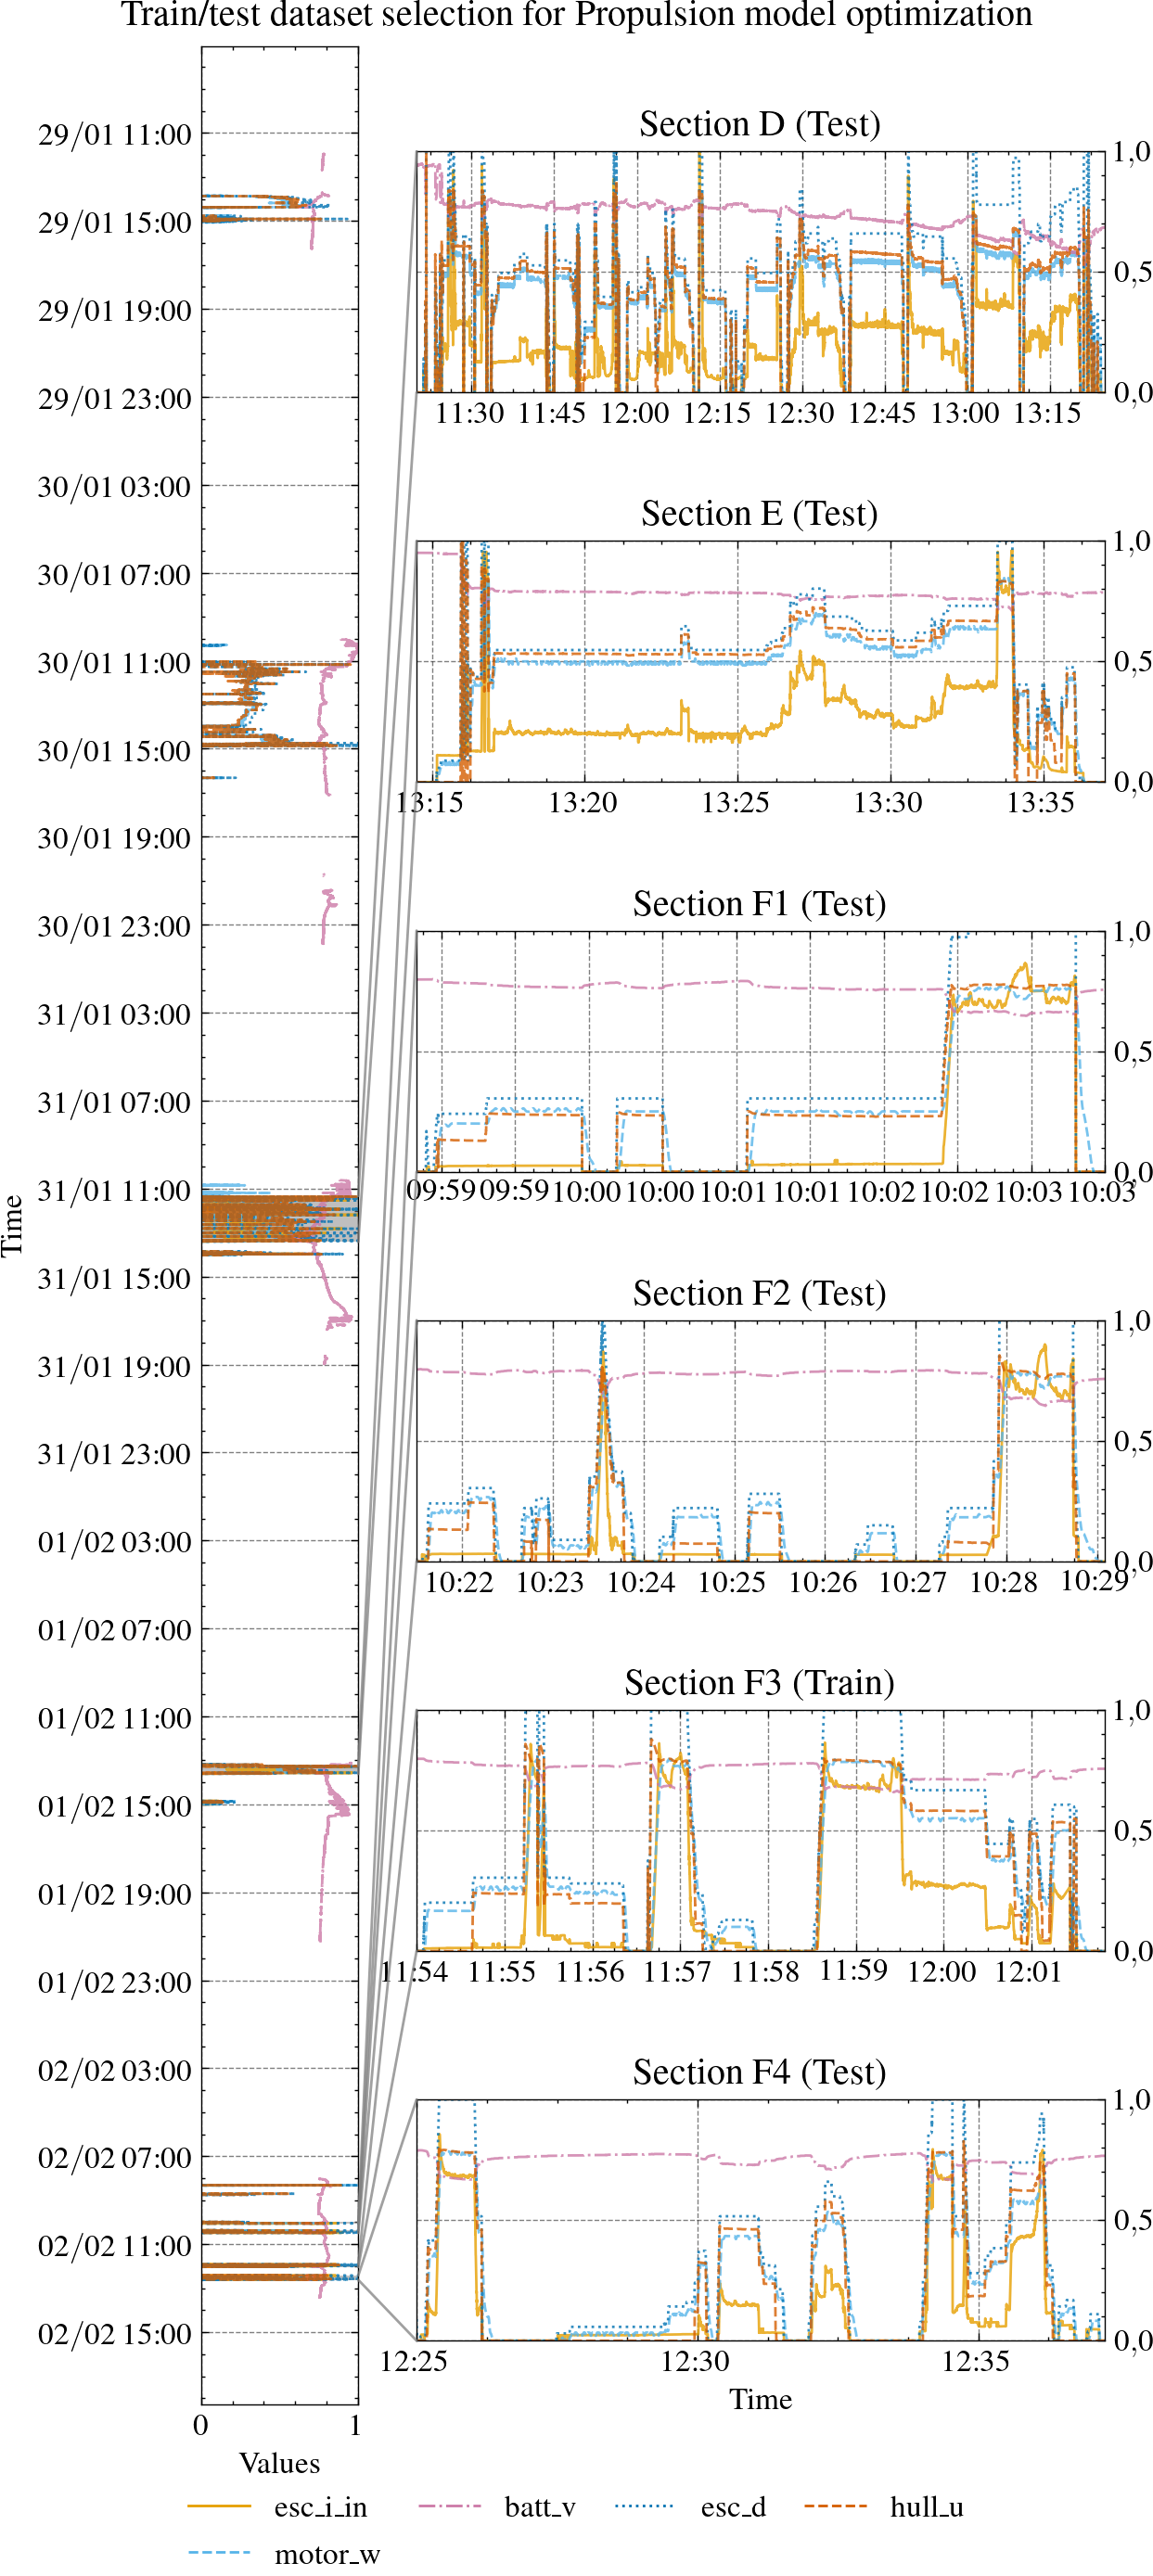

In [4]:
sections, tzinfo = get_sections()

# Customizing ranges:
sections.loc['Section D', 'start'] = pd.Timestamp('2020-01-31 11:20:00')
sections.loc['Section D', 'end'] = pd.Timestamp('2020-01-31 13:25:00')
sections.loc['Section E'] = [pd.Timestamp('2020-02-01 13:14:30'), pd.Timestamp('2020-02-01 13:37:00')]
sections.loc['Section F1'] = [pd.Timestamp("2020-02-02 09:58:50"), pd.Timestamp("2020-02-02 10:03:30")]
sections.loc['Section F2'] = [pd.Timestamp("2020-02-02 10:21:30"), pd.Timestamp("2020-02-02 10:29:05")]
sections.loc['Section F3'] = [pd.Timestamp("2020-02-02 11:54:00"), pd.Timestamp("2020-02-02 12:01:50")]
sections.loc['Section F4'] = [pd.Timestamp("2020-02-02 12:25:00"), pd.Timestamp("2020-02-02 12:37:15")]
sections = sections.loc[['Section D', 'Section E', 'Section F1', 'Section F2', 'Section F3', 'Section F4']]

train_section_name = 'Section F3'
train_test_sections = sections.reset_index().to_dict(orient='records')
train_section = sections.loc[sections.index == train_section_name].reset_index().to_dict(orient='records')[0]
test_sections = sections.loc[sections.index != train_section_name].reset_index().to_dict(orient='records')

train_size = 0
test_size = 0
for i in range(len(train_test_sections)):
    if train_test_sections[i]['name'] == train_section_name:
        train_test_sections[i]['name'] = train_test_sections[i]['name'] + ' (Train)'
        train_size += df.loc[train_test_sections[i]['start']:train_test_sections[i]['end']].size
    else:
        train_test_sections[i]['name'] = train_test_sections[i]['name'] + ' (Test)'
        test_size += df.loc[train_test_sections[i]['start']:train_test_sections[i]['end']].size

total_size = train_size+test_size
print(f'Train size ≃ {100*train_size/total_size:.2f}%')
print(f'Test size ≃ {100*test_size/total_size:.2f}%')

fig_save_and_show(
    filename=f'{latex_img_path}/propulsion_optimization_dataset.pdf',
    show_title=f'Train/test dataset selection for Propulsion model optimization',
    save_title=f'Dataset da embarcação durante o DSB de 2019',
    ncol=4,
    fig=plot_events_data(
        events=train_test_sections,
        df=df,
        column_names=['esc_i_in', 'motor_w', 'batt_v', 'esc_d', 'hull_u'],
        normalize=True,
    )
);


# Propulsion System model

In [5]:
from model import Propulsion, get_hull_areas
from utils.models import eval_poly

Propulsion.build({})

<NonlinearIOSystem propulsion: ['batt_v', 'esc_d'] -> ['motor_v', 'motor_w', 'motor_i', 'motor_q_load', 'esc_i_in', 'prop_w', 'prop_j', 'prop_k_q', 'prop_k_t', 'prop_q', 'prop_t', 'prop_t_e', 'hull_u', 'hull_r_t']>

In [6]:
motor_params_loaded = load_model_params_from_json('../../../models/2020/motor/me0909_free_rotor_step_params.json')
esc_params_loaded = load_model_params_from_json('../../../models/2020/esc/mam17_params.json')
propulsive_initial_params = load_model_params_from_json('../../../models/2020/propeller/data/propulsive_initial_params.json')

In [7]:
propulsion_params = motor_params_loaded | esc_params_loaded | {
    'rho_water': propulsive_initial_params['water_rho'],  # Estimated from public ocean dataset
    'rho_air': propulsive_initial_params['air_rho'],  # Estimated from public ocean dataset
    'trans_eta': propulsive_initial_params['trans_eta'],  # Arbitrary
    'trans_I_r_in': 0,  # Ignored
    'trans_I_r_out': 0,  # Ignored
    'trans_k': propulsive_initial_params['trans_k'],  # Manually counted
    'prop_D': propulsive_initial_params['prop_D'],  # From manufacturer's specs
    'prop_k_T_coeffs': propulsive_initial_params['prop_k_T_coeffs'],
    'prop_k_Q_coeffs': propulsive_initial_params['prop_k_Q_coeffs'],
    'prop_eta_R': 1.0,  # Unknown
    'prop_I_r': propulsive_initial_params['prop_I_r'],  # Estiamted from dimensions
    'hull_C_T': propulsive_initial_params['hull_C_T'],  # Estimated from data
    'hull_M': propulsive_initial_params['hull_M'],  # Measured (fully loaded, with pilot)
    'hull_M_a': 0,  # Unknown
    'hull_S_water': propulsive_initial_params['hull_S_water'],  # Estimated from hydrostatics
    'hull_S_air': propulsive_initial_params['hull_S_air'],  # Estimated from hydrostatics
    'hull_T_ded': propulsive_initial_params['hull_T_ded'],  # Estimated from models/2020/propeller/propeller.ipynb
    'hull_W': propulsive_initial_params['hull_W'],  # Estimated from models/2020/propeller/propeller.ipynb
    'prop_J_max': 1.5,
}
propulsion_params

{'motor_B': 0.001401819826389131,
 'motor_I_r': 0.011815137847671575,
 'motor_I_r_load': 0,
 'motor_K_Q': 0.10638460838741098,
 'motor_K_V': 0.10178006369696158,
 'motor_L_A': 6.24949639106588e-05,
 'motor_R_A': 0.0195442230227981,
 'esc_E_off': 0.00011,
 'esc_E_on': 7e-05,
 'esc_F_s': 12550,
 'esc_Q_rr': 1.9e-07,
 'esc_R_ds_on': 0.006428129677311848,
 'esc_V_F': 2.884681806089211,
 'esc_V_ds_ov': 1.2222222222222223,
 'esc_r_D': 0.003448696395697723,
 'rho_water': 1023,
 'rho_air': 1.1839,
 'trans_eta': 0.99,
 'trans_I_r_in': 0,
 'trans_I_r_out': 0,
 'trans_k': 0.6363636363636364,
 'prop_D': 0.2286,
 'prop_k_T_coeffs': array([ 0.3721783 , -0.10836873, -0.1673824 ,  0.028249  ]),
 'prop_k_Q_coeffs': array([ 0.05473265, -0.01755622, -0.0005334 , -0.01076869]),
 'prop_eta_R': 1.0,
 'prop_I_r': 0.0005545487788185924,
 'hull_C_T': 0.010878369245660298,
 'hull_M': 293.7,
 'hull_M_a': 0,
 'hull_S_water': 4.050226176680205,
 'hull_S_air': 4.188174709710495,
 'hull_T_ded': 0.09086582383384416,


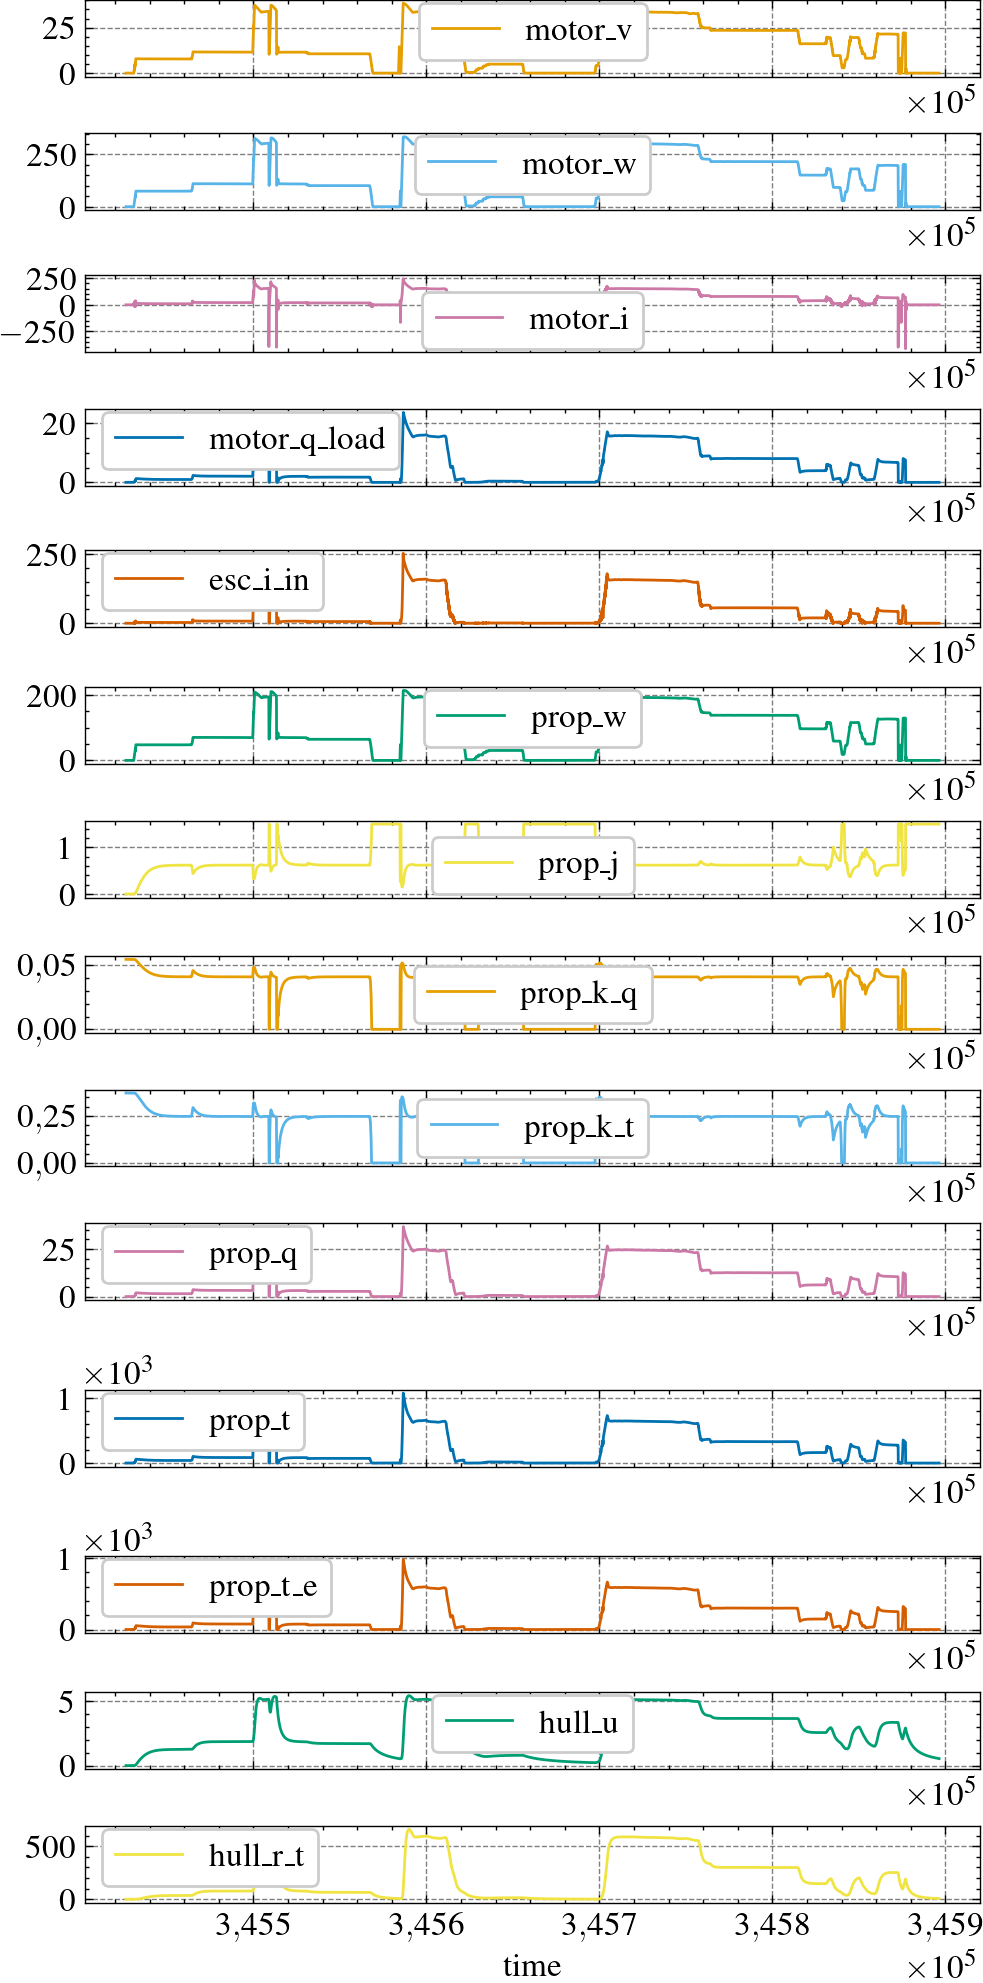

In [8]:
# Select the optimization data
data_cols = ['motor_w', 'esc_i_in', 'hull_u']
input_cols = ['batt_v', 'esc_d']

df_train = df.loc[train_section['start']:train_section['end'], ['t'] + data_cols + input_cols]
assert np.isfinite(df_train.to_numpy()).all()
assert df_train.isna().sum().sum() == 0

# Time array
T = np.ascontiguousarray(df_train['t'].to_numpy())

# Inputs
U = np.ascontiguousarray(df_train[input_cols].to_numpy().T)

# Model
propulsion = Propulsion.build(propulsion_params)

# Initial state
X0 = Propulsion.initial_state(
    X0=dict(),
    U0=U[:,0],
    params=propulsion_params,
)

# Simulation
res = ct.input_output_response(propulsion, T=T, U=U, X0=X0, solve_ivp_method='Radau') # type: ignore
ydata = res.to_pandas().set_index('time')[res.output_labels]

ydata.plot(subplots=True, figsize=(5,10))
plt.show();

# Optimization

In [9]:
from sklearn.preprocessing import RobustScaler, StandardScaler
from pymoo.optimize import minimize
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.operators.sampling.lhs import LHS
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.parallelization.starmap import StarmapParallelization
from multiprocessing.pool import ThreadPool
from multiprocessing import Pool

In [10]:
import numpy as np
from dataclasses import dataclass
from typing import Sequence, Optional

def _collect_coeffs(x: np.ndarray,
                    opt_param_order: Sequence[str],
                    prefix: str) -> np.ndarray:
    """Extract polynomial coeffs for a given prefix from x."""
    coeffs = []
    for i, name in enumerate(opt_param_order):
        if name.startswith(prefix + "_"):
            coeffs.append(float(x[i]))
    return np.asarray(coeffs, dtype=float)

@dataclass
class HullWakeConstraint:
    """
    Penalize hull_W far from a reference value, and outside [w_min, w_max].

    violation = max( |w - w_ref| - tol, w_min - w, w - w_max, 0 )
    """
    opt_param_order: Sequence[str]
    name: str = "hull_W"
    w_ref: float = 0.1425
    tol: float = 0.05     # allowed ± band without penalty
    w_min: float = 0.0
    w_max: float = 0.4

    def __call__(self, x: np.ndarray) -> float:
        # locate hull_W in x
        try:
            idx = self.opt_param_order.index(self.name)
        except ValueError:
            # not being optimized here -> no violation
            return -1.0

        w = float(x[idx])

        # box constraint: w_min <= w <= w_max
        box_low  = self.w_min - w
        box_high = w - self.w_max

        # soft prior around w_ref
        prior_violation = abs(w - self.w_ref) - self.tol

        violation = max(box_low, box_high, prior_violation, 0.0)
        return float(violation)
    
@dataclass
class HullThrustDeductionConstraint:
    """
    Enforce:
      - 0 <= t <= t_max
      - t ≈ k_R * w with k_R in [kR_min, kR_max]
    where:
      w = hull_W
      t = hull_T_ded
    """
    opt_param_order: Sequence[str]
    wake_name: str = "hull_W"
    tded_name: str = "hull_T_ded"
    t_max: float = 0.3
    kR_min: float = 0.4
    kR_max: float = 0.8

    def __call__(self, x: np.ndarray) -> float:
        names = self.opt_param_order
        try:
            i_w = names.index(self.wake_name)
            i_t = names.index(self.tded_name)
        except ValueError:
            # not both present -> inactive
            return -1.0

        w = float(x[i_w])
        t = float(x[i_t])

        # basic box constraints on t
        low_violation  = -t          # t >= 0
        high_violation = t - self.t_max   # t <= t_max

        # if w <= 0, we can't define k_R properly; penalize strongly
        if w <= 0.0:
            kR_violation = 1.0
        else:
            kR = t / w
            kR_low  = self.kR_min - kR
            kR_high = kR - self.kR_max
            kR_violation = max(kR_low, kR_high, 0.0)

        violation = max(low_violation, high_violation, kR_violation, 0.0)
        return float(violation)

@dataclass
class PolyOutputConstraint:
    """
    Enforce k_min <= k(J) <= k_max over J in [J_min, J_max].

    No monotonicity here; only box bounds on the curve values.
    """
    opt_param_order: Sequence[str]
    coeff_name_prefix: str
    J_min: float = 0.0
    J_max: float = 1.5
    n_grid: int = 80
    k_min: Optional[float] = None
    k_max: Optional[float] = None

    def __post_init__(self):
        self.J_grid = np.linspace(self.J_min, self.J_max, self.n_grid)

    def __call__(self, x: np.ndarray) -> float:
        coeffs = _collect_coeffs(x, self.opt_param_order, self.coeff_name_prefix)
        if coeffs.size == 0:
            return -1.0

        k_vals = eval_poly(coeffs, self.J_grid)

        v_low = 0.0
        v_high = 0.0
        if self.k_min is not None:
            v_low = np.max(self.k_min - k_vals)   # >0 if any point < k_min
        if self.k_max is not None:
            v_high = np.max(k_vals - self.k_max)  # >0 if any point > k_max

        return float(max(v_low, v_high, 0.0))

@dataclass
class EfficiencyConstraint:
    """
    Enforce 0 <= eta0(J) <= eta_max, where
        eta0(J) = J*K_T(J) / (2*pi*K_Q(J))
    over J in [J_min, J_max].
    """
    opt_param_order: Sequence[str]
    kt_prefix: str
    kq_prefix: str
    J_min: float = 0.1
    J_max: float = 1.1      # only where you actually operate
    n_grid: int = 80
    eta_max: float = 0.75
    kq_eps: float = 1e-4    # minimum |K_Q| to avoid singularities

    def __post_init__(self):
        self.J_grid = np.linspace(self.J_min, self.J_max, self.n_grid)

    def __call__(self, x: np.ndarray) -> float:
        KT_coeffs = _collect_coeffs(x, self.opt_param_order, self.kt_prefix)
        KQ_coeffs = _collect_coeffs(x, self.opt_param_order, self.kq_prefix)
        if KT_coeffs.size == 0 or KQ_coeffs.size == 0:
            return -1.0

        KT = eval_poly(KT_coeffs, self.J_grid)
        KQ = eval_poly(KQ_coeffs, self.J_grid)

        min_abs_KQ = np.min(np.abs(KQ))
        v_kq = max(self.kq_eps - min_abs_KQ, 0.0)

        with np.errstate(divide="ignore", invalid="ignore"):
            eta = self.J_grid * KT / (2.0 * np.pi * KQ)
        eta = np.where(np.isfinite(eta), eta, 0.0)

        v_neg  = np.max(-eta)                 # >0 if any eta < 0
        v_high = np.max(eta - self.eta_max)   # >0 if any eta > eta_max

        return float(max(v_kq, v_neg, v_high, 0.0))

@dataclass
class BSeriesPriorConstraint:
    """
    Keep polynomial coefficients close to a 'template' (e.g. B-series) set.

    For each coefficient i:
        |c_i - c_i_ref| <= max(rel_tol*|c_i_ref|, abs_min)

    violation = max_i( |c_i - c_i_ref| - allowed_i , 0 )
    """
    opt_param_order: Sequence[str]
    coeff_name_prefix: str          # "prop_k_T_coeffs" or "prop_k_Q_coeffs"
    ref_coeffs: np.ndarray          # B-series coefficients (length >= n_optimized)
    rel_tol: float = 0.5            # 50% relative allowed deviation
    abs_min: float = 1e-3           # minimum absolute band

    def __call__(self, x: np.ndarray) -> float:
        coeffs = _collect_coeffs(x, self.opt_param_order, self.coeff_name_prefix)
        if coeffs.size == 0:
            return -1.0

        ref = np.asarray(self.ref_coeffs, dtype=float)[:coeffs.size]
        diff = np.abs(coeffs - ref)
        allowed = np.maximum(self.rel_tol * np.abs(ref), self.abs_min)

        v = np.max(diff - allowed)
        return float(max(v, 0.0))


In [11]:
# Check constraints feasibility

def make_constraints(model, model_params, params_bounds):
    constraint_funcs = []
    param_names = list(params_bounds.keys())

    n_kT = sum(1 for k in param_names if k.startswith("prop_k_T_coeffs_"))
    n_kQ = sum(1 for k in param_names if k.startswith("prop_k_Q_coeffs_"))

    # B-series reference coeffs: take them from model_params
    # (these should be your _estimate_bseries_poly_coeffs(...) result
    # before starting the optimization).
    kt_ref = np.asarray(model_params["prop_k_T_coeffs"], dtype=float)
    kq_ref = np.asarray(model_params["prop_k_Q_coeffs"], dtype=float)

    # 1) value bounds on K_T and K_Q in J-range of interest
    # if n_kT > 0:
    #     constraint_funcs.append(
    #         PolyOutputConstraint(
    #             opt_param_order=param_names,
    #             coeff_name_prefix="prop_k_T_coeffs",
    #             J_min=0.1,
    #             J_max=0.5,
    #             n_grid=100,
    #             k_min=-0.1,
    #             k_max=1,
    #         )
    #     )
    # if n_kQ > 0:
    #     constraint_funcs.append(
    #         PolyOutputConstraint(
    #             opt_param_order=param_names,
    #             coeff_name_prefix="prop_k_Q_coeffs",
    #             J_min=0.1,
    #             J_max=0.5,
    #             n_grid=100,
    #             k_min=-0.01,
    #             k_max=0.1,
    #         )
    #     )

    # 2) efficiency cap
    if n_kT > 0 and n_kQ > 0:
        constraint_funcs.append(
            EfficiencyConstraint(
                opt_param_order=param_names,
                kt_prefix="prop_k_T_coeffs",
                kq_prefix="prop_k_Q_coeffs",
                J_min=0,
                J_max=1.5,
                n_grid=100,
                # eta_max=0.6,   # open-water efficiency cap
                eta_max=0.7,   # open-water efficiency cap
                # eta_max=1.0,   # open-water efficiency cap  -> This works, but seems unrealistic
                kq_eps=1e-4,
            )
        )

    # 3) B-series proximity
    if n_kT > 0:
        constraint_funcs.append(
            BSeriesPriorConstraint(
                opt_param_order=param_names,
                coeff_name_prefix="prop_k_T_coeffs",
                ref_coeffs=kt_ref,
                rel_tol=0.4,   # allow ±x% per coefficient
                abs_min=1e-3,
            )
        )
    if n_kQ > 0:
        constraint_funcs.append(
            BSeriesPriorConstraint(
                opt_param_order=param_names,
                coeff_name_prefix="prop_k_Q_coeffs",
                ref_coeffs=kq_ref,
                rel_tol=0.4,
                abs_min=1e-3,
            )
        )

    if "hull_W" in param_names:
        constraint_funcs.append(
            HullWakeConstraint(
                opt_param_order=param_names,
                w_ref=0.1425,
                tol=0.05,
                w_min=0.0,
                w_max=0.4,
            )
        )

    if "hull_W" in param_names and "hull_T_ded" in param_names:
        constraint_funcs.append(
            HullThrustDeductionConstraint(
                opt_param_order=param_names,
                wake_name="hull_W",
                tded_name="hull_T_ded",
                t_max=0.2,
                kR_min=0.5,
                kR_max=0.7,
            )
        )

    return constraint_funcs


def build_params_bounds():
    params_bounds = {
        'trans_eta': dict(min=0.1, max=0.99),
        'hull_C_T': dict(min=0, max=0.1),
        'hull_M_a': dict(min=0, max=1000),
        'hull_W': dict(min=0.0, max=1.0),
        'hull_T_ded': dict(min=0.0, max=1.0),
        'prop_I_r': dict(min=1e-6, max=1.0),
        'prop_eta_R': dict(min=0.0, max=1.0),
    }

    poly_specs = [
        # {'name': 'prop_k_T_coeffs', 'n_coeffs': 4, 'x_interval': (0, 1.5), 'y_bounds': (-0.1, 1)},
        # {'name': 'prop_k_Q_coeffs', 'n_coeffs': 4, 'x_interval': (0, 1.5), 'y_bounds': (-0.01, 0.1)},
    ]

    for spec in poly_specs:
        coeff_bounds = estimate_polynomial_coefficient_bounds(
            x_interval=spec['x_interval'],
            y_bounds=spec['y_bounds'],
            degree=spec['n_coeffs'] - 1,
        )
        for i in range(spec['n_coeffs']):
            params_bounds[f"{spec['name']}_{i}"] = dict(
                min=coeff_bounds[i][0],
                max=coeff_bounds[i][1],
            )

    param_names = list(params_bounds.keys())
    return params_bounds, param_names


def build_x_from_model_params(model_params, params_bounds):
    """
    Build the optimization vector x in the same order as param_names
    using model_params for values. For polynomial coefficients, split
    model_params["prop_k_T_coeffs"] / ["prop_k_Q_coeffs"] into scalars.
    """
    param_names = list(params_bounds.keys())
    x_vals = []

    kT = np.asarray(model_params.get("prop_k_T_coeffs", []), dtype=float)
    kQ = np.asarray(model_params.get("prop_k_Q_coeffs", []), dtype=float)

    for name in param_names:
        if name.startswith("prop_k_T_coeffs_"):
            idx = int(name.split("_")[-1])
            if idx < len(kT):
                x_vals.append(float(kT[idx]))
            else:
                # fallback: center of bounds if coeff missing
                b = params_bounds[name]
                x_vals.append(0.5 * (b["min"] + b["max"]))
        elif name.startswith("prop_k_Q_coeffs_"):
            idx = int(name.split("_")[-1])
            if idx < len(kQ):
                x_vals.append(float(kQ[idx]))
            else:
                b = params_bounds[name]
                x_vals.append(0.5 * (b["min"] + b["max"]))
        else:
            # scalar parameter (hull_C_T, hull_W, hull_T_ded, prop_I_r, ...)
            if name in model_params:
                x_vals.append(float(model_params[name]))
            else:
                # if absent, put it at the middle of its box; this keeps hull
                # constraints from trivially failing if you only care about K_T/K_Q
                b = params_bounds[name]
                x_vals.append(0.5 * (b["min"] + b["max"]))

    return np.asarray(x_vals, dtype=float), param_names


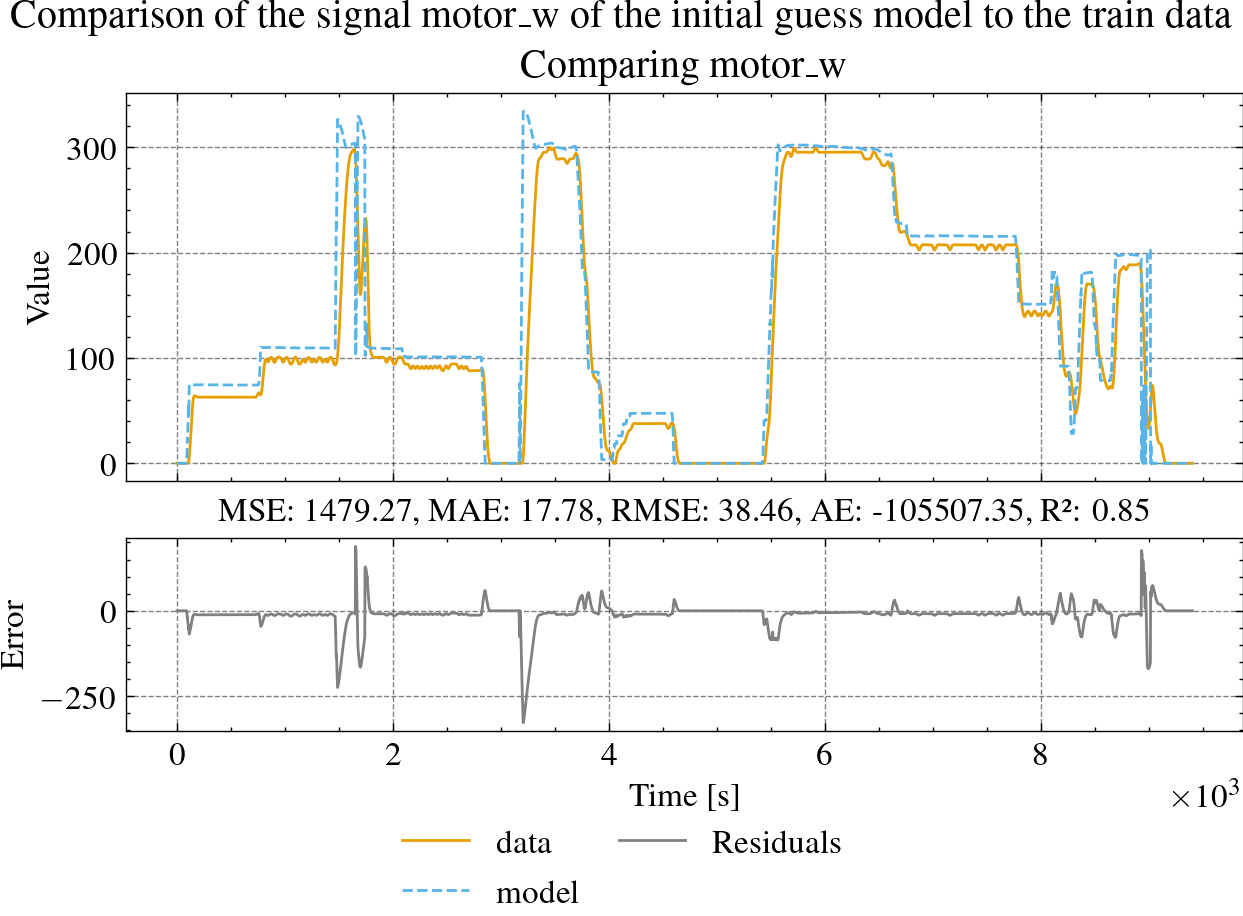

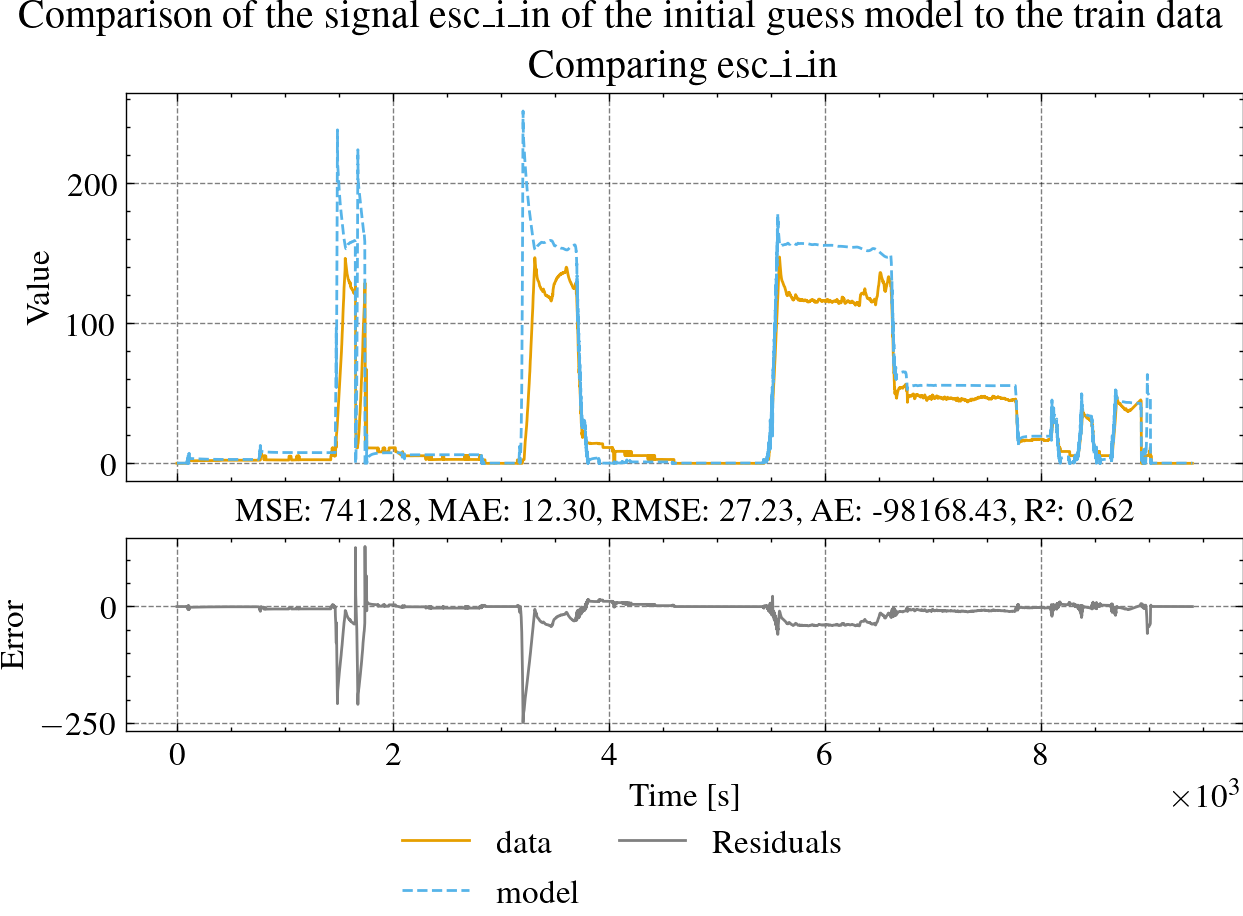

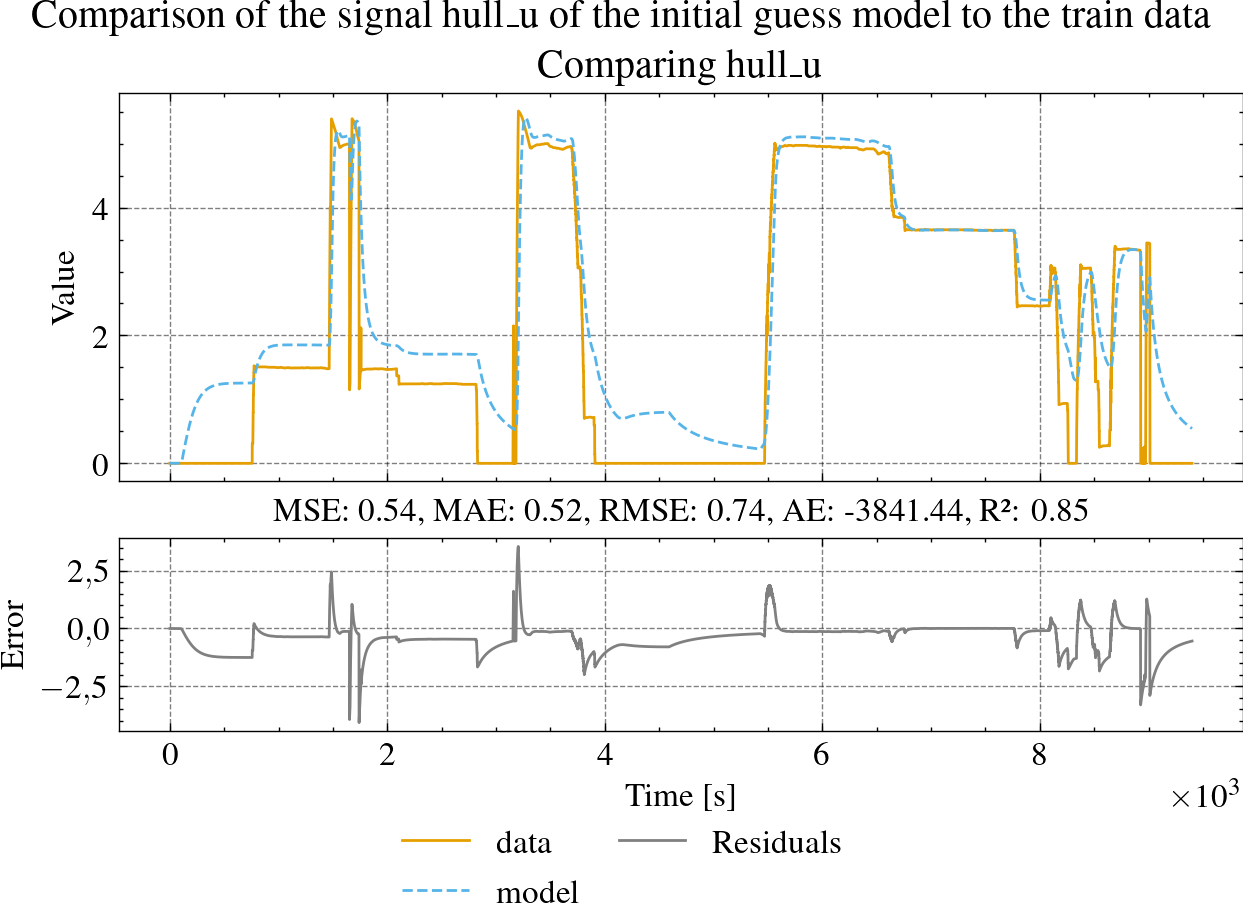

In [12]:
# Check error before optimization

def model_function(T, U, X0, **params):
    return ct.input_output_response(
        Propulsion.build(params=params),
        T=T,
        U=U,
        X0=X0,
        solve_ivp_method='Radau',
    ).to_pandas()

model = Propulsion
input_initial_state = {}
T = np.ascontiguousarray(df_train['t'].to_numpy())
U = np.ascontiguousarray(df_train[input_cols].to_numpy().T)
X0 = model.initial_state(X0=input_initial_state, U0=U[:,0], params=propulsion_params)
initial_guess_data = model_function(T, U, X0, **(propulsion_params))

for col in data_cols:
    fig_save_and_show(
        filename=f'{latex_img_path}/propulsion_initial_guess_residuals_{col}_train.pdf',
        show_title=f'Comparison of the signal {col} of the initial guess model to the train data',
        save_title=f'Comparação do sinal {col} do modelo estimado inicialmente com os dados de treino',
        ncol=2,
        fig=plot_compare(df_train, initial_guess_data, col, show=False),
    )

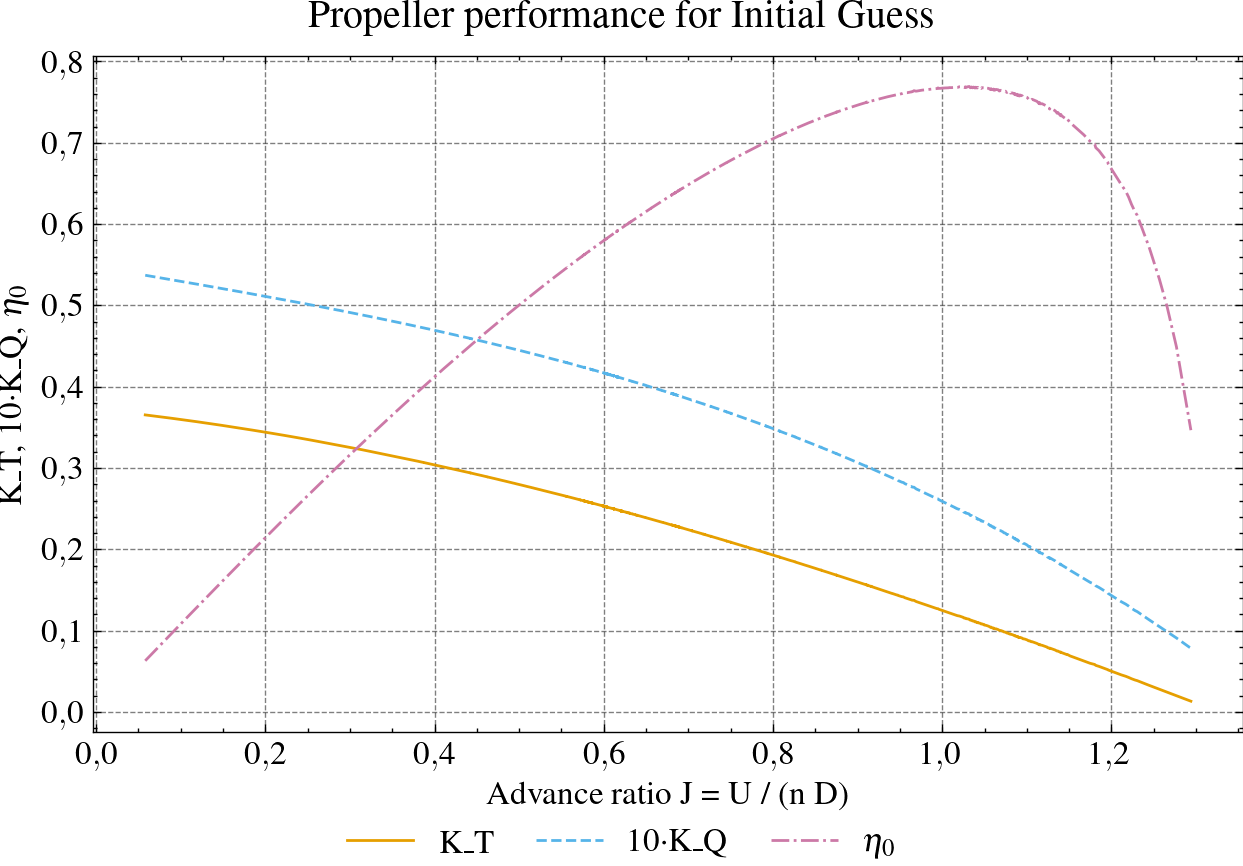

In [13]:
# Check Propeller curve before optimization

def filter_prop_p_outints(df, params):
    df = df.copy()

    prop_D     = params["prop_D"]
    rho_water  = params["rho_water"]
    hull_W  = params["hull_W"]
    trans_k = params['trans_k']

    # Kinematics
    prop_w = df["motor_w"] * trans_k
    df["prop_n"] = prop_w / (2*np.pi)                       # [rev/s]
    df["u_rel"]  = (1.0 - hull_W) * df["hull_u"]               # inflow at prop
    df["J"]      = df["u_rel"] / (df["prop_n"] * prop_D)

    # Basic operating filters
    m = (
        (df["prop_n"].abs() > 1)      # ~>12 rpm
        & (df["u_rel"] > 0.1)           # avoid U≈0
        & (df["prop_t"] > 1.0)          # avoid almost-zero thrust
        & (df["prop_q"] > 0.05)         # positive, non-trivial torque
        & (df["J"] > 0)
        & np.isfinite(df["J"])
    )
    df = df[m].copy()

    # Dimensionless coefficients
    df["K_T"] = df["prop_t"] / (rho_water * df["prop_n"]**2 * prop_D**4)
    df["K_Q"] = df["prop_q"] / (rho_water * df["prop_n"]**2 * prop_D**5)

    # Efficiency
    df["eta0"] = df["J"] * df["K_T"] / (2*np.pi * df["K_Q"])

    # Filter absurd efficiencies and J outliers
    m_eta = (
        (df["eta0"] > 0.0) & (df["eta0"] < 1) &
        (df["J"] < 1.5)
    )
    df = df[m_eta].copy()
    return df

df_prop = filter_prop_p_outints(initial_guess_data, propulsion_params).sort_values("J")

fig, ax1 = plt.subplots(figsize=figsize())
ax1.plot(df_prop["J"], df_prop["K_T"], label="K_T")
ax1.plot(df_prop["J"], 10.0 * df_prop["K_Q"], label="10·K_Q")
ax1.plot(df_prop["J"], df_prop["eta0"], label=r'$\eta_0$')
ax1.set_xlabel("Advance ratio J = U / (n D)")
ax1.set_ylabel(r'K_T, 10·K_Q, $\eta_0$')
ax1.grid(True)
fig_save_and_show(
    filename=f"{latex_img_path}/propeller_performance_from_simulation_initial_guess.pdf",
    show_title="Propeller performance for Initial Guess",
    save_title="Performance do hélice para estimativa inicial",
    ncol=3,
    fig=fig,
);

n_gen  |  n_eval  |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |      280 |  0.0002822057 |  3.3846798426 |             - |             -
     2 |      560 |  0.000000E+00 |  1.1882994051 |  4.018313E+01 |  2.875145E+01
     3 |      840 |  0.000000E+00 |  0.6915457007 |  4.018313E+01 |  2.875145E+01
     4 |     1120 |  0.000000E+00 |  0.5160317856 |  7.960830E+01 |  2.875145E+01
     5 |     1400 |  0.000000E+00 |  0.3973654089 |  4.967677E+01 |  2.8251442090
     6 |     1680 |  0.000000E+00 |  0.3010159070 |  3.750059E+01 |  2.8251442090
     7 |     1960 |  0.000000E+00 |  0.2271782963 |  2.778420E+01 |  1.5615338019
     8 |     2240 |  0.000000E+00 |  0.1686078674 |  2.083271E+01 |  1.5615338019
     9 |     2520 |  0.000000E+00 |  0.1242802513 |  2.228562E+01 |  0.6958620686
    10 |     2800 |  0.000000E+00 |  0.0826612157 |  1.967995E+01 |  0.6020582404
    11 |     3080 |  0.000000E+00 |  0.0548137836 |  2.174110E+01 |  0.6020582404
    12 |     336

{'trans_eta': 0.99,
 'hull_C_T': 0.010878369245660298,
 'hull_M_a': 0,
 'hull_W': 0.1514430397230736,
 'hull_T_ded': 0.09086582383384416,
 'prop_I_r': 0.0005545487788185924,
 'prop_eta_R': 1.0}

Best parameters found:


{'trans_eta': 0.9899978997253387,
 'hull_C_T': 0.01060934556478102,
 'hull_M_a': 1.813031448449969,
 'hull_W': 0.09320662867117831,
 'hull_T_ded': 0.04812126617827417,
 'prop_I_r': 3.732012269569299e-05,
 'prop_eta_R': 0.9997285442770794}

Objective value at solution: [0.20878898]


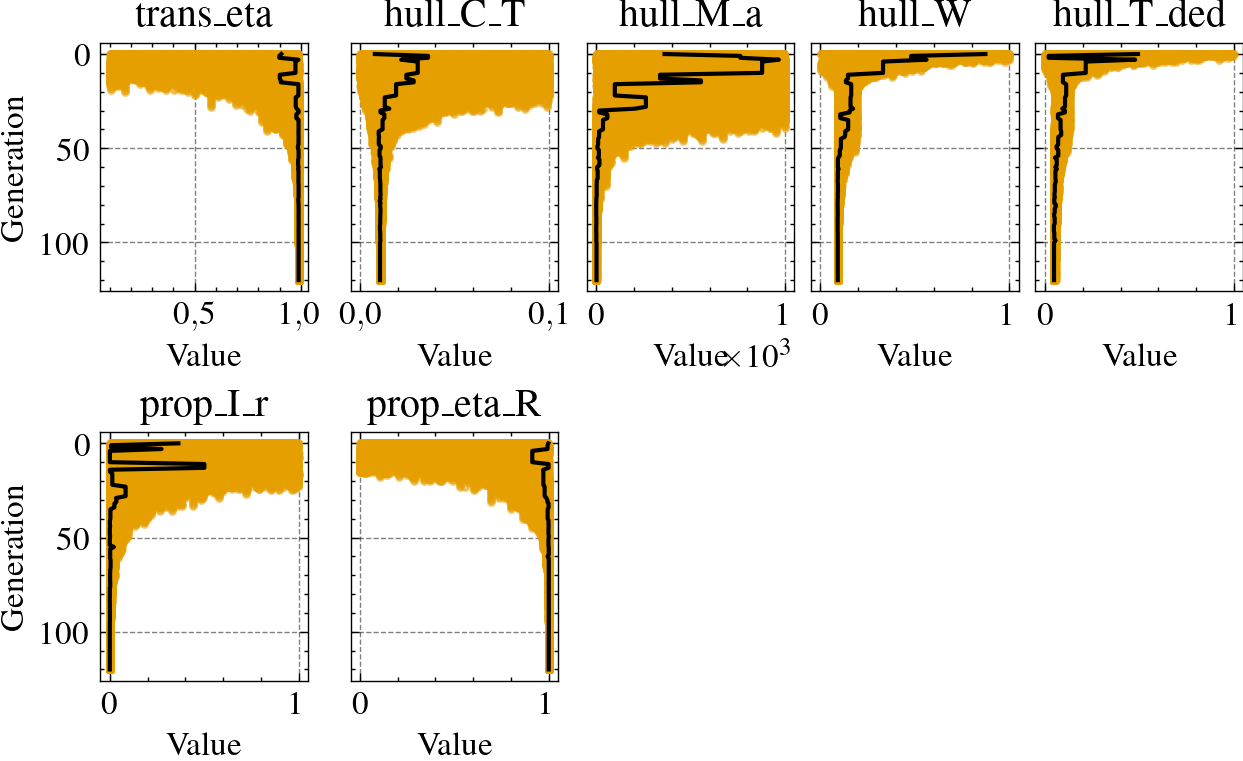

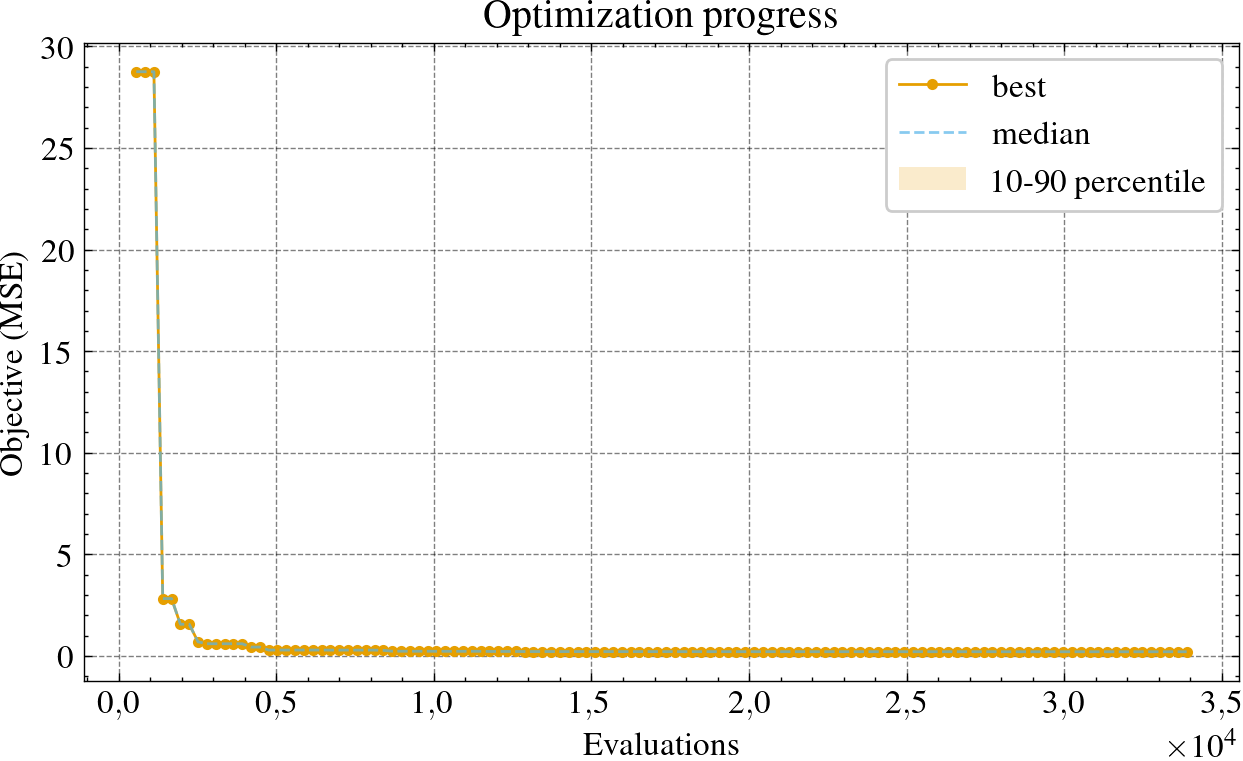

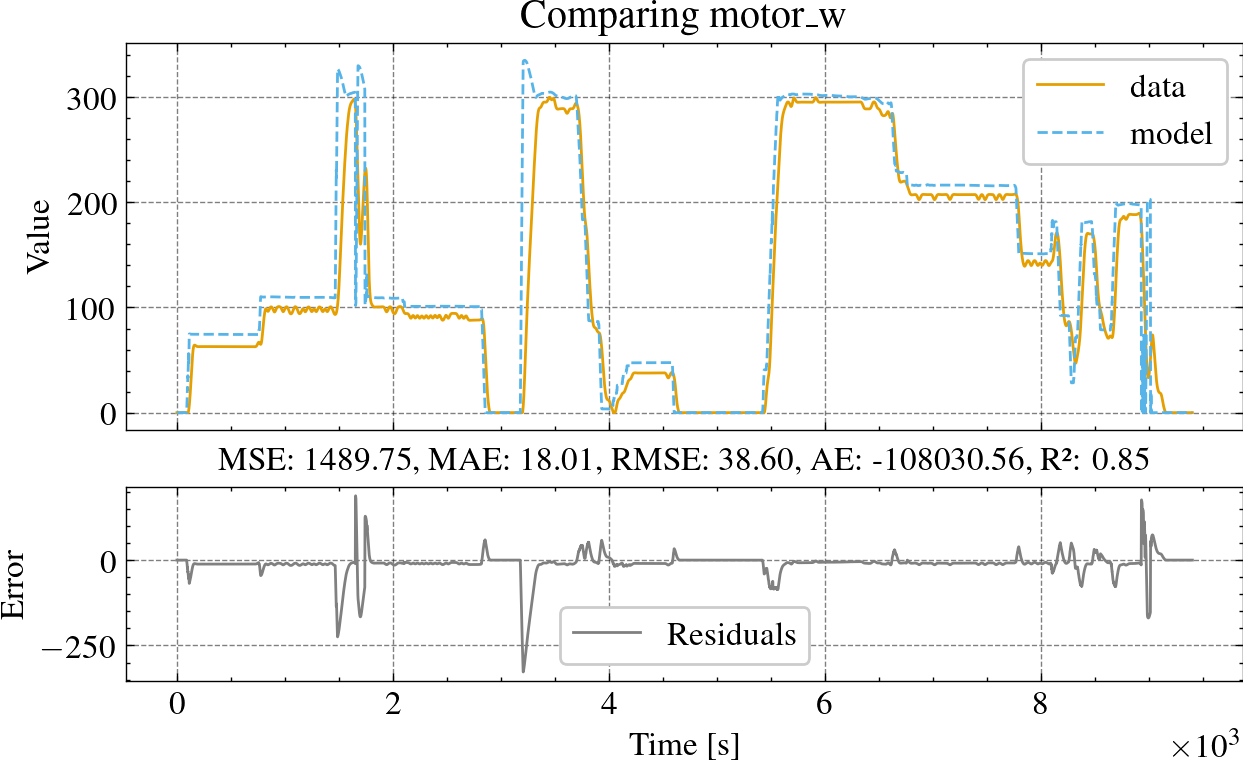

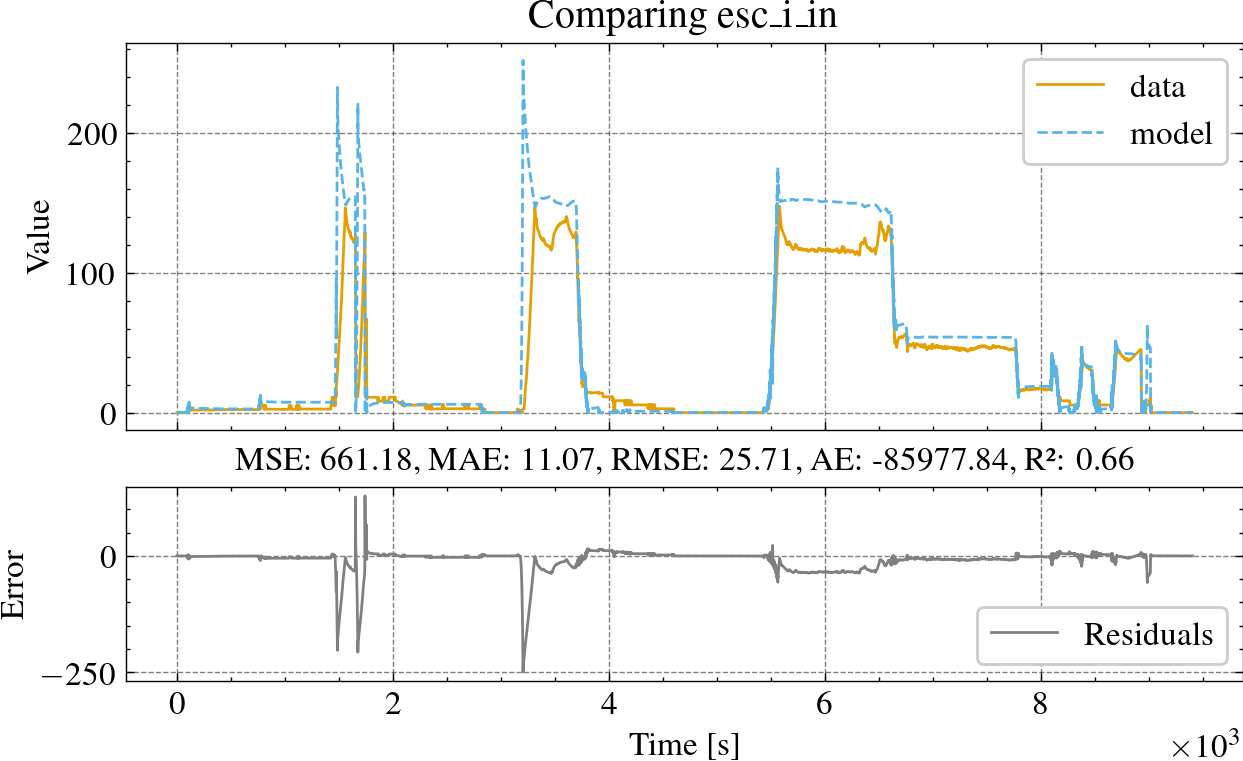

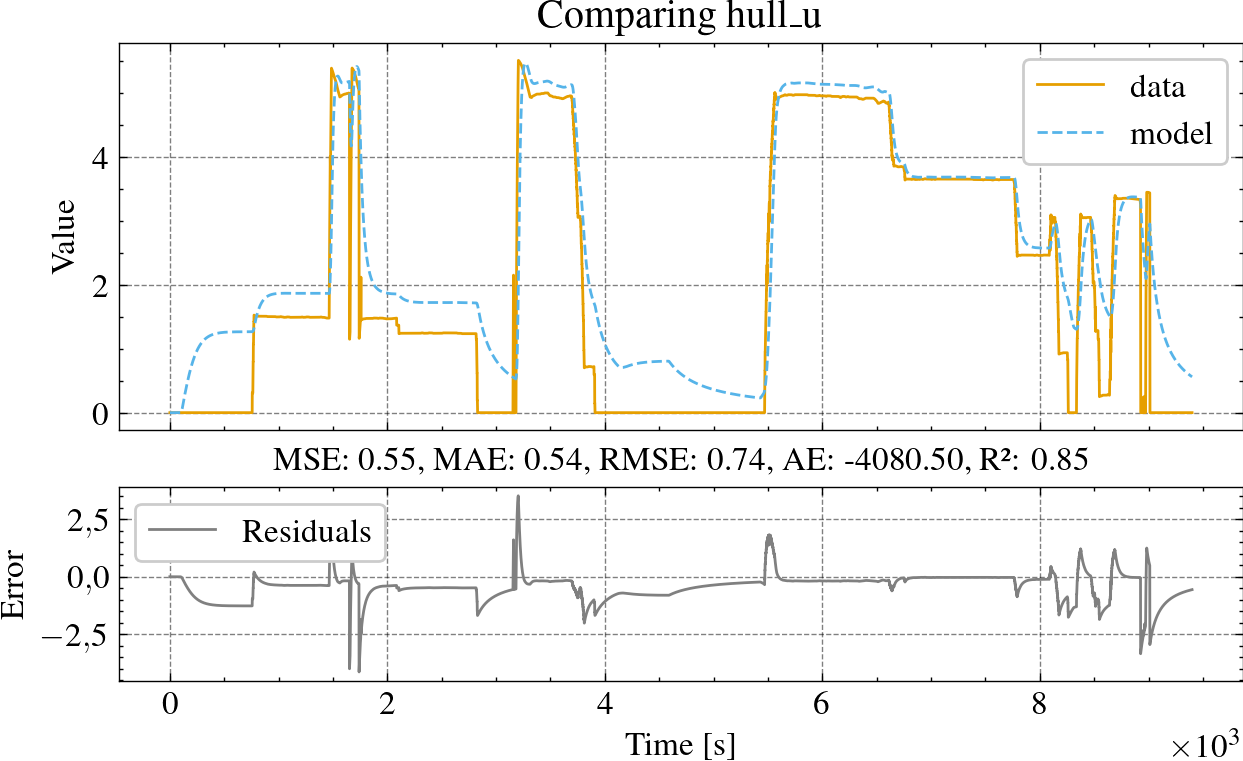

CPU times: user 12.1 s, sys: 4.93 s, total: 17.1 s
Wall time: 32min 40s


In [14]:
%%time
## PROPULSION OPTIMIZATION

# Select the optimization data
data_cols = ['motor_w', 'esc_i_in', 'hull_u']
input_cols = ['batt_v', 'esc_d']

# Put simulation data into df
df_train = df.loc[train_section['start']:train_section['end'], ['t'] + data_cols + input_cols]
# df_train = df.loc[train_section['start']:train_section['end'], ['t'] + data_cols + input_cols][130:] # Only the peak of the Section F1 is enough

# Set model states initial conditions
input_initial_state = {}

# Initialize Parameters
params_bounds, _ = build_params_bounds()

# Initialize the thread pool and create the runner
n_processes = 32
pool = Pool(processes=n_processes)
runner = StarmapParallelization(pool.starmap)

try:
    # Initialize the problem
    model = Propulsion
    model_params = propulsion_params
    constraint_funcs = make_constraints(model, model_params, params_bounds)
    problem = MyOptimizationProblem(
        model=model,
        model_function=model_function,
        training_data=df_train,
        training_data_columns=data_cols,
        model_params=model_params,
        opt_params_bounds=params_bounds,
        input_initial_state=input_initial_state,
        input_columns=input_cols,
        # data_scaler=RobustScaler,
        data_scaler=StandardScaler,
        elementwise_runner=runner,
        constraint_funcs=constraint_funcs,
        # print_exceptions=True,
    )

    algorithm = DE(
        # pop_size=100*len(params_bounds),
        pop_size=40*len(params_bounds),
        sampling=LHS(),
        variant="DE/rand/1/bin",
        # variant="DE/best/1/bin",
        F=0.5,
        CR=0.9,
        dither='vector',
    )

    # Specify termination criteria
    termination = DefaultSingleObjectiveTermination(
        xtol=1e-8,
        cvtol=1e-6,
        ftol=1e-6,
        period=20,
        # period=100,
        n_max_gen=1000,
        n_max_evals=1000000
    )

    # Run the optimization
    result = minimize(
        problem,
        algorithm,
        termination=termination,
        seed=42,
        verbose=True,
        save_history=True,
    )
    print('Threads:', result.exec_time)
finally:
    pool.close()
    pool.join()

# Print the results
best_params = convert_to_model_params({k: result.X[i] for (i, k) in enumerate(params_bounds.keys())})
original_params = {k: convert_to_model_params(model_params)[k] for k in best_params.keys()}
print("Original parameters were:")
display(original_params)
print("Best parameters found:")
display(best_params)
print("Objective value at solution:", result.F)

plot_optimization_params(result, params_bounds)
plot_optimization_error(result, params_bounds)

T = np.ascontiguousarray(df_train['t'].to_numpy())
U = np.ascontiguousarray(df_train[input_cols].to_numpy().T)
X0 = model.initial_state(X0=input_initial_state, U0=U[:,0], params=model_params | best_params)

best_fit_data = model_function(T, U, X0, **(model_params | best_params))

for col in data_cols:
    plot_compare(df_train, best_fit_data, col)


In [15]:
# pause

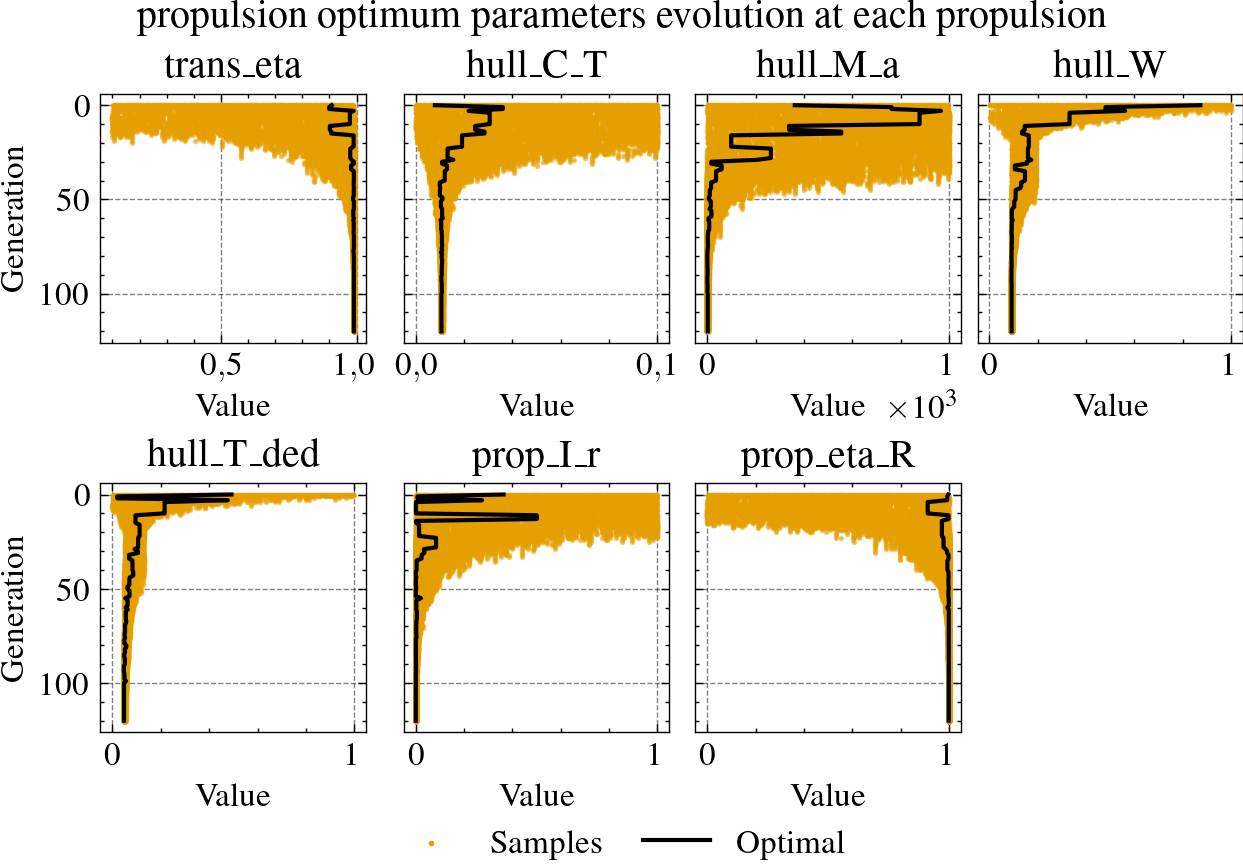

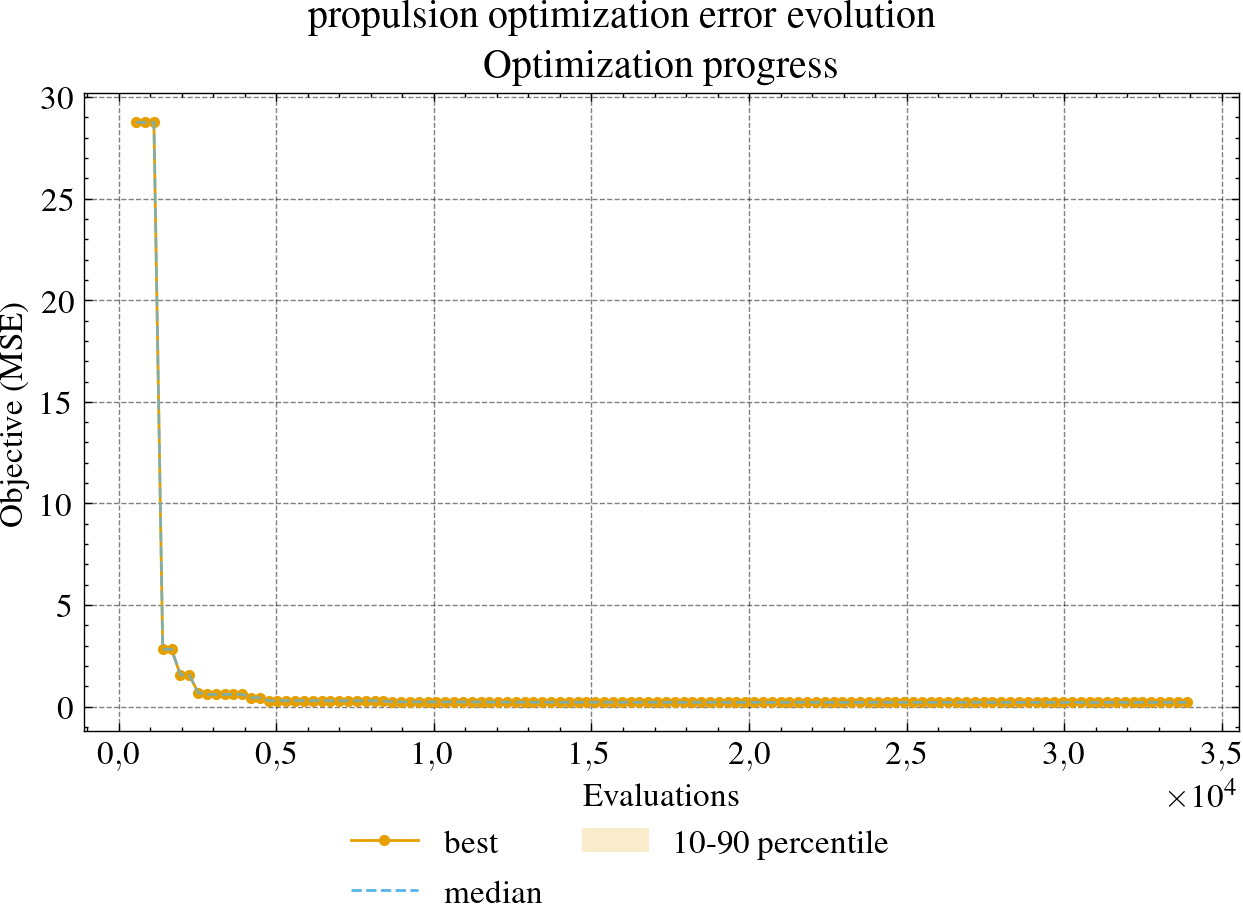

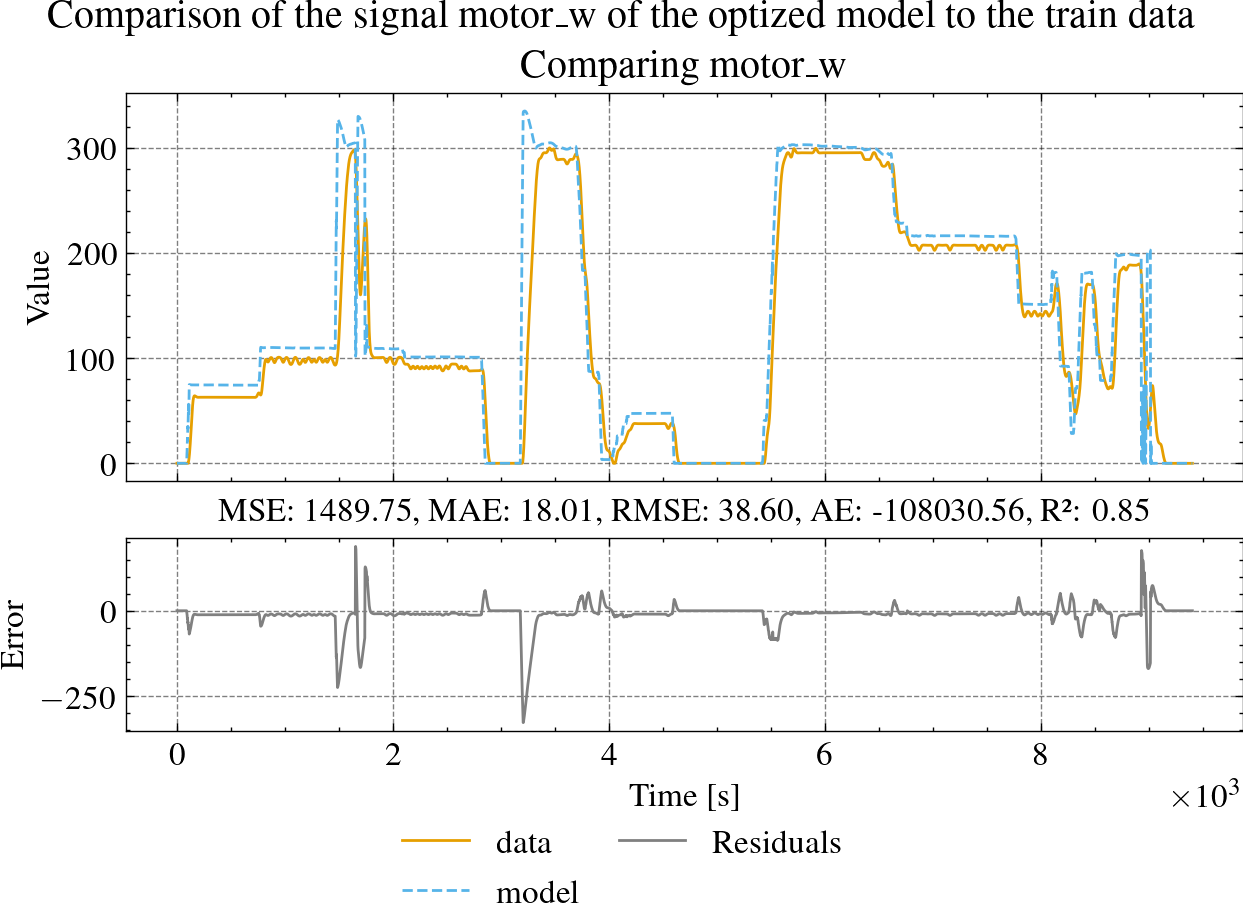

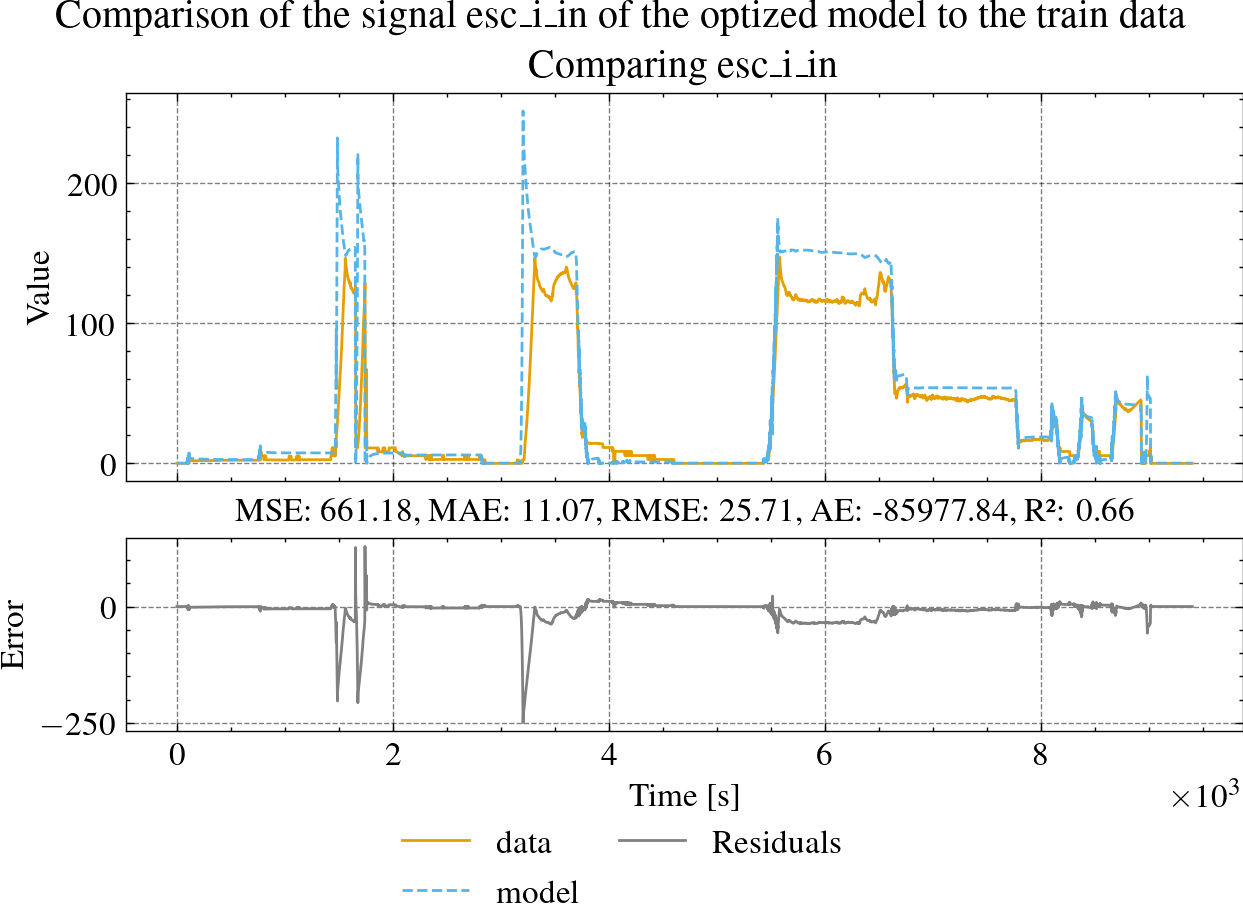

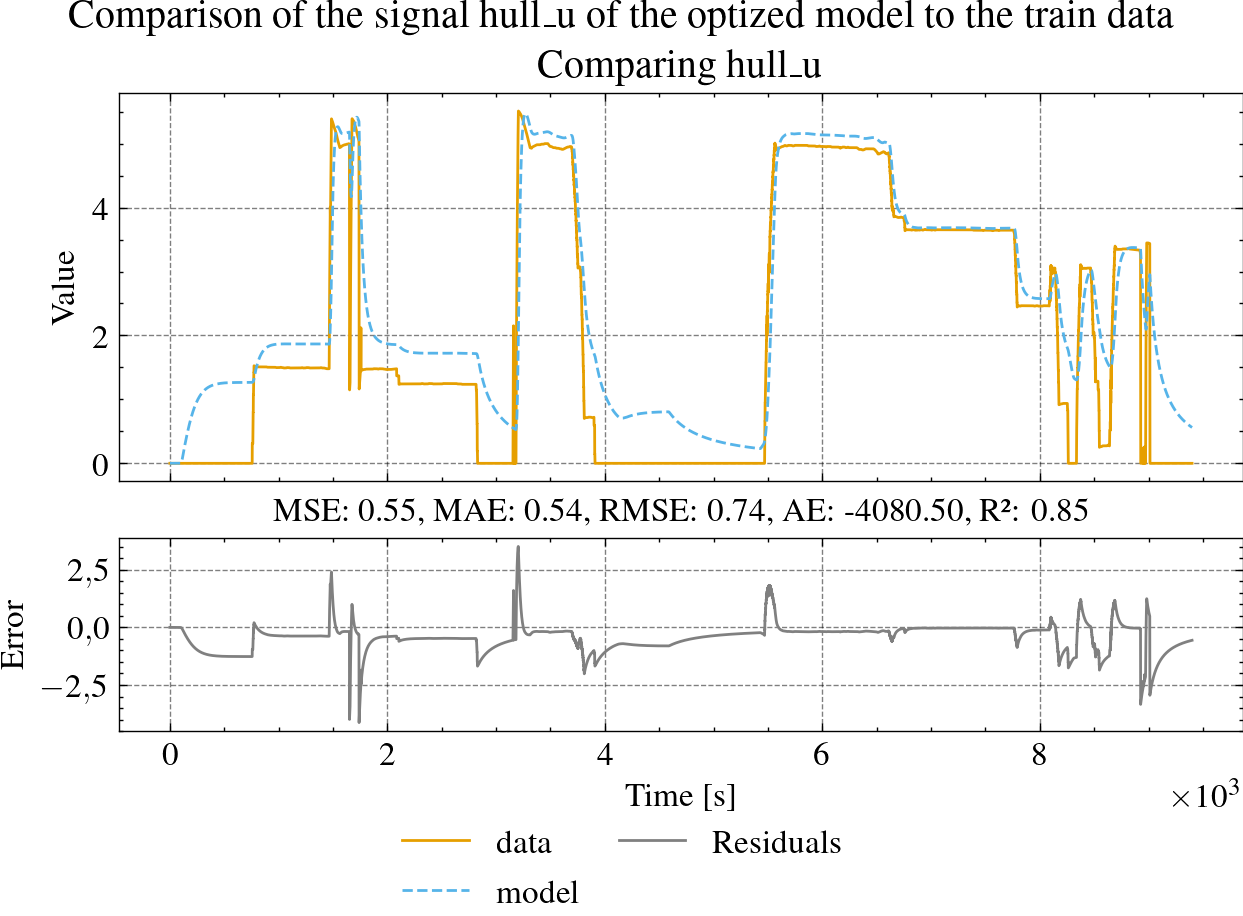

{'esc_E_off': 0.00011,
 'esc_E_on': 7e-05,
 'esc_F_s': 12550,
 'esc_Q_rr': 1.9e-07,
 'esc_R_ds_on': 0.006428129677311848,
 'esc_V_F': 2.884681806089211,
 'esc_V_ds_ov': 1.2222222222222223,
 'esc_r_D': 0.003448696395697723,
 'hull_C_T': 0.01060934556478102,
 'hull_M': 293.7,
 'hull_M_a': 1.813031448449969,
 'hull_S_air': 4.188174709710495,
 'hull_S_water': 4.050226176680205,
 'hull_T_ded': 0.04812126617827417,
 'hull_W': 0.09320662867117831,
 'motor_B': 0.001401819826389131,
 'motor_I_r': 0.011815137847671575,
 'motor_I_r_load': 0,
 'motor_K_Q': 0.10638460838741098,
 'motor_K_V': 0.10178006369696158,
 'motor_L_A': 6.24949639106588e-05,
 'motor_R_A': 0.0195442230227981,
 'prop_D': 0.2286,
 'prop_I_r': 3.732012269569299e-05,
 'prop_J_max': 1.5,
 'prop_eta_R': 0.9997285442770794,
 'prop_k_Q_coeffs': array([ 0.05473265, -0.01755622, -0.0005334 , -0.01076869]),
 'prop_k_T_coeffs': array([ 0.3721783 , -0.10836873, -0.1673824 ,  0.028249  ]),
 'rho_air': 1.1839,
 'rho_water': 1023,
 'trans_I_r

In [16]:
# Plot the original data and the fitted curve
fig_save_and_show(
    filename=f'{latex_img_path}/propulsion_optimization_params.pdf',
    show_title='propulsion optimum parameters evolution at each propulsion',
    save_title='Evolução dos parâmetros ótimos do modelo da Propulsão a cada geração',
    ncol=2,
    fig=plot_optimization_params(result, params_bounds=params_bounds, scatter_alpha=0.5, scatter_size=1, max_columns=4, show=False)
)

fig_save_and_show(
    filename=f'{latex_img_path}/propulsion_optimization_error.pdf',
    show_title='propulsion optimization error evolution',
    save_title='Evolução do erro de otimização do modelo da Propulsão',
    ncol=2,
    fig=plot_optimization_error(result, show=False),
)

for col in data_cols:
    fig_save_and_show(
        filename=f'{latex_img_path}/propulsion_optimization_residuals_{col}_train.pdf',
        show_title=f'Comparison of the signal {col} of the optized model to the train data',
        save_title=f'Comparação do sinal {col} do modelo otimizado com os dados de treino',
        ncol=2,
        fig=plot_compare(df_train, best_fit_data, col, show=False),
    )

params_output_path = 'propulsion_params.json'
save_model_params_to_json(params_output_path, propulsion_params | best_params)
model_params = load_model_params_from_json(params_output_path)
model_params

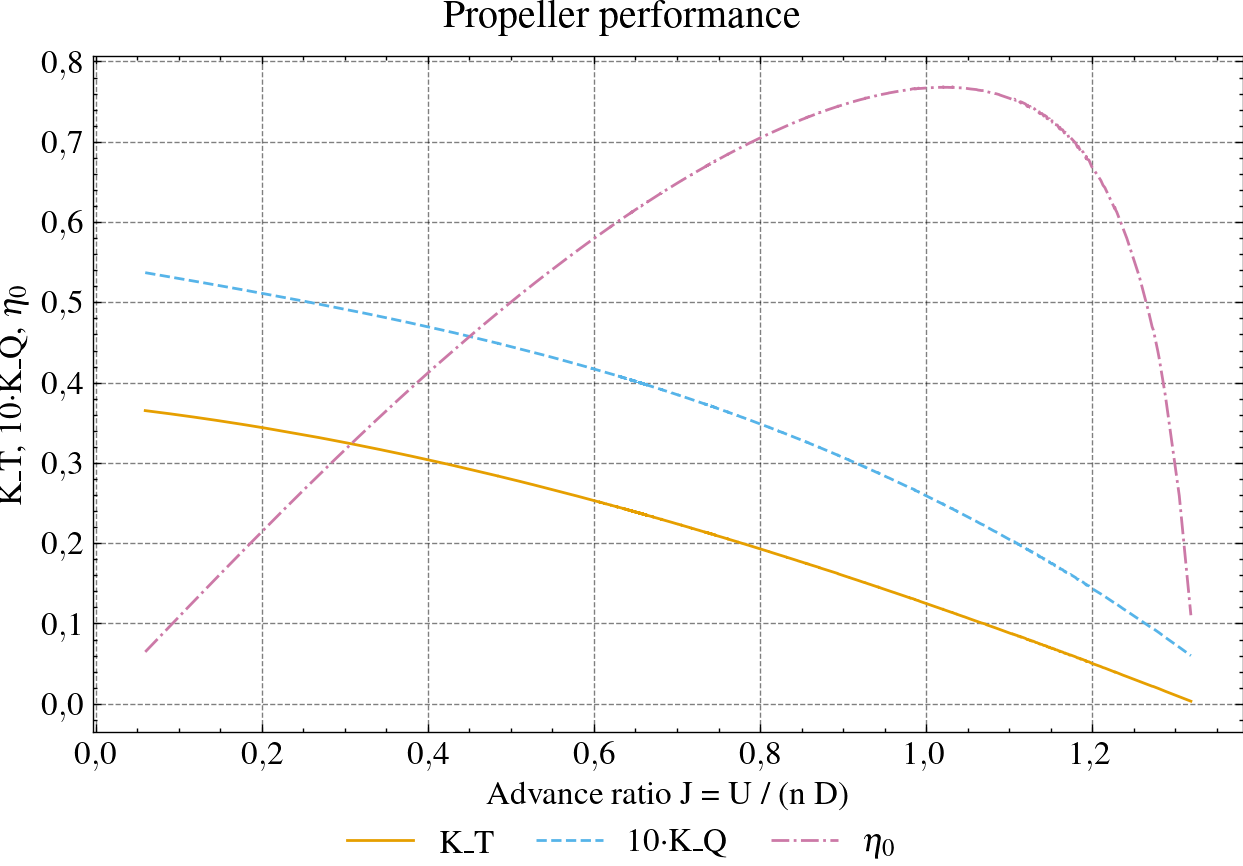

In [17]:
df_prop = filter_prop_p_outints(best_fit_data, model_params).sort_values("J")

fig, ax1 = plt.subplots(figsize=figsize())
ax1.plot(df_prop["J"], df_prop["K_T"], label="K_T")
ax1.plot(df_prop["J"], 10.0 * df_prop["K_Q"], label="10·K_Q")
ax1.plot(df_prop["J"], df_prop["eta0"], label=r'$\eta_0$')
ax1.set_xlabel("Advance ratio J = U / (n D)")
ax1.set_ylabel(r'K_T, 10·K_Q, $\eta_0$')
ax1.grid(True)
fig_save_and_show(
    filename=f"{latex_img_path}/propeller_performance_from_simulation.pdf",
    show_title="Propeller performance",
    save_title="Performance do hélice",
    ncol=3,
    fig=fig,
);

In [18]:
test_section = test_sections[0]

df_test = df.loc[(df.index >= test_section['start']) & (df.index <= test_section['end']), ['t'] + data_cols + input_cols]

T = df_test['t'].to_numpy()
U = df_test[input_cols].to_numpy().T
X0 = model.initial_state(X0=input_initial_state, U0=U[:,0], params=model_params)

df_pred = model_function(T, U, X0, **(model_params))
display(df_pred[['esc_i_in', 'prop_j', 'prop_k_q', 'prop_k_t', 'prop_q', 'prop_t', 'hull_u', 'hull_r_t']].describe().T[['mean', 'min', 'max']])
# df_pred[['esc_i_in', 'prop_j', 'prop_k_q', 'prop_k_t', 'prop_q', 'prop_t', 'hull_u', 'hull_r_t']].describe().T[['mean', 'min', 'max']].T.to_dict()

mean  min          max
esc_i_in   36.144929  0.0   245.314321
prop_j      0.739150  0.0     1.500000
prop_k_q    0.035619  0.0     0.054733
prop_k_t    0.211911  0.0     0.372178
prop_q      8.342816  0.0    35.312945
prop_t    215.798781  0.0  1008.719718
hull_u      2.815460  0.0     5.496075
hull_r_t  205.406263  0.0   664.719305

MSE        MAE       RMSE            AE        R2
section data                                                               
D       motor_w    540.015614  11.654396  23.238236 -1.266379e+06  0.899229
        esc_i_in    90.430520   5.690170   9.509496 -5.144434e+05  0.854377
        hull_u       0.177807   0.195031   0.421672 -2.275645e+04  0.903395
E       motor_w    758.885437  13.501277  27.547875 -2.878985e+05  0.848232
        esc_i_in   405.424426   8.122266  20.135154 -1.338948e+05  0.402382
        hull_u       0.206291   0.174033   0.454192 -3.780870e+03  0.891305
F1      motor_w    940.757041  17.457700  30.671763 -5.260682e+04  0.885942
        esc_i_in    84.098057   4.951931   9.170499 -2.667877e+04  0.961963
        hull_u       0.434065   0.473182   0.658836 -2.331676e+03  0.834236
F2      motor_w    542.573366  13.444023  23.293204 -6.419674e+04  0.927139
        esc_i_in   165.218684   4.690639  12.853742 -1.760614e+04  0.892045
        hull_u       0.519563   0.608121   0.720807 -5.051513e+03  0.789687
F3      motor_w   1489.753748  18.006428  38.597328 -1.080306e+05  0.850079
        esc_i_in   661.176117  11.071314  25.713345 -8.597784e+04  0.664568
        hull_u       0.554692   0.535544   0.744777 -4.080498e+03  0.850288
F4      motor_w    408.637720  12.176570  20.214790 -9.836546e+04  0.954939
        esc_i_in   125.298217   5.446084  11.193669 -2.200427e+04  0.902149
        hull_u       0.334822   0.427550   0.578638 -5.166189e+03  0.889603

/home/joaoantoniocardoso/workspace_TCC/repo/thesis/assets/generated//propulsion_optimization_test_residuals_motor_w_test_d.pdf


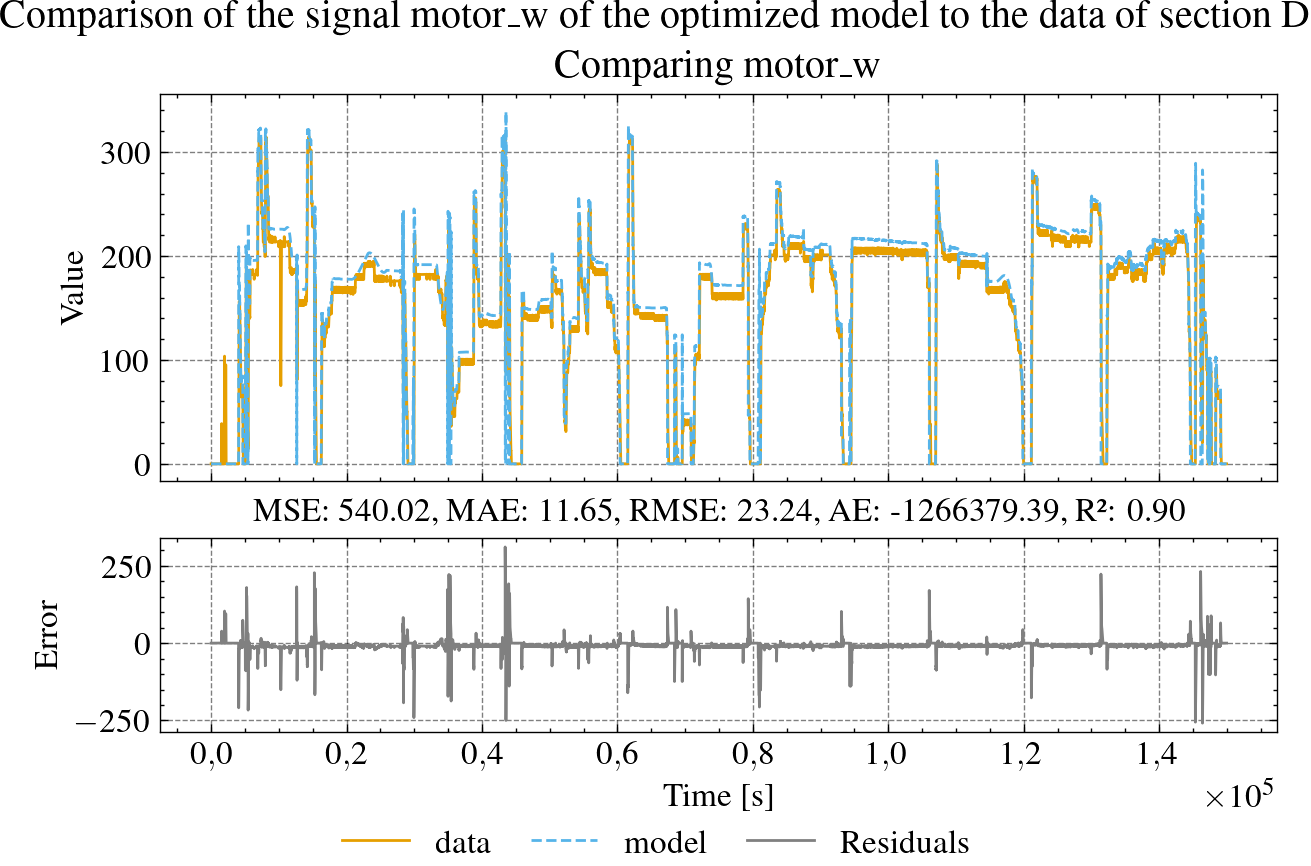

/home/joaoantoniocardoso/workspace_TCC/repo/thesis/assets/generated//propulsion_optimization_test_residuals_esc_i_in_test_d.pdf


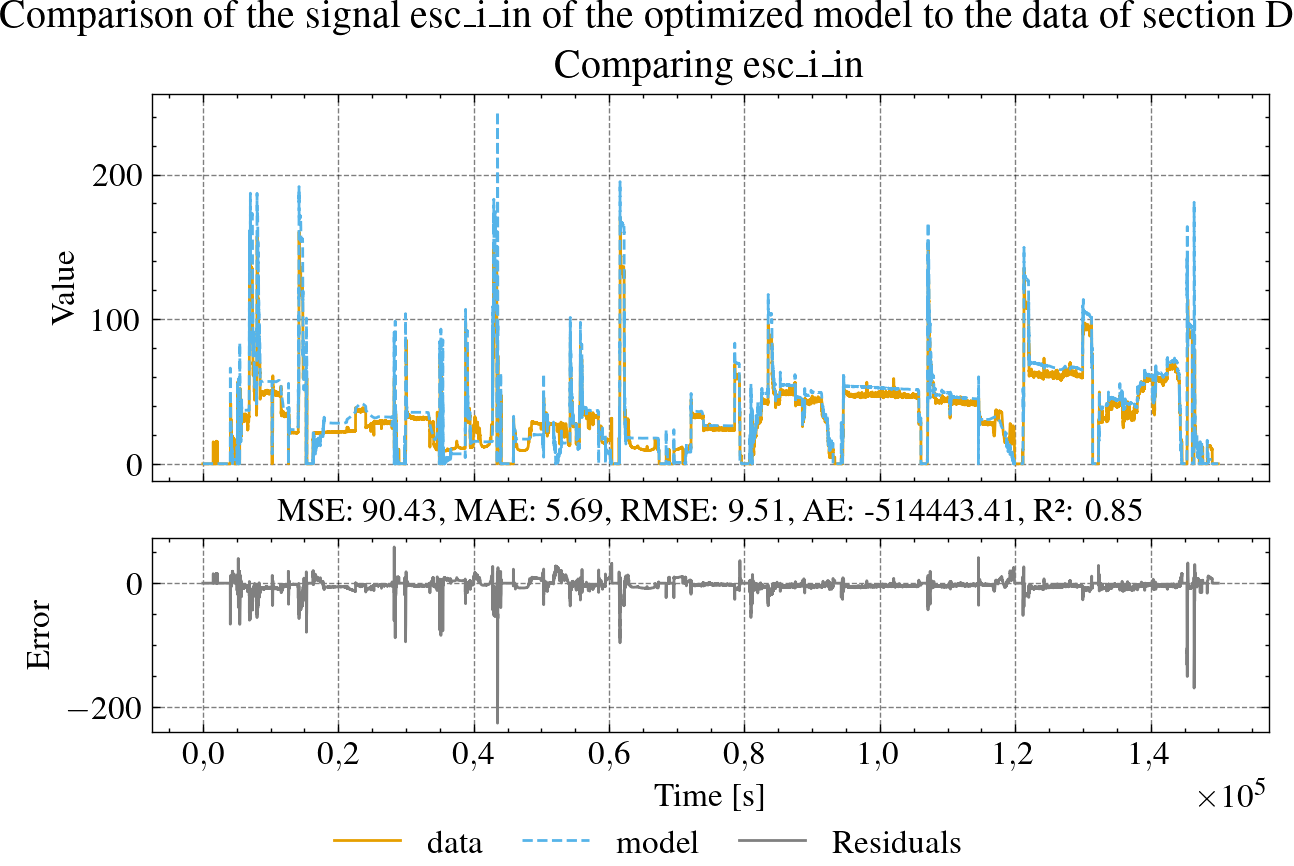

/home/joaoantoniocardoso/workspace_TCC/repo/thesis/assets/generated//propulsion_optimization_test_residuals_hull_u_test_d.pdf


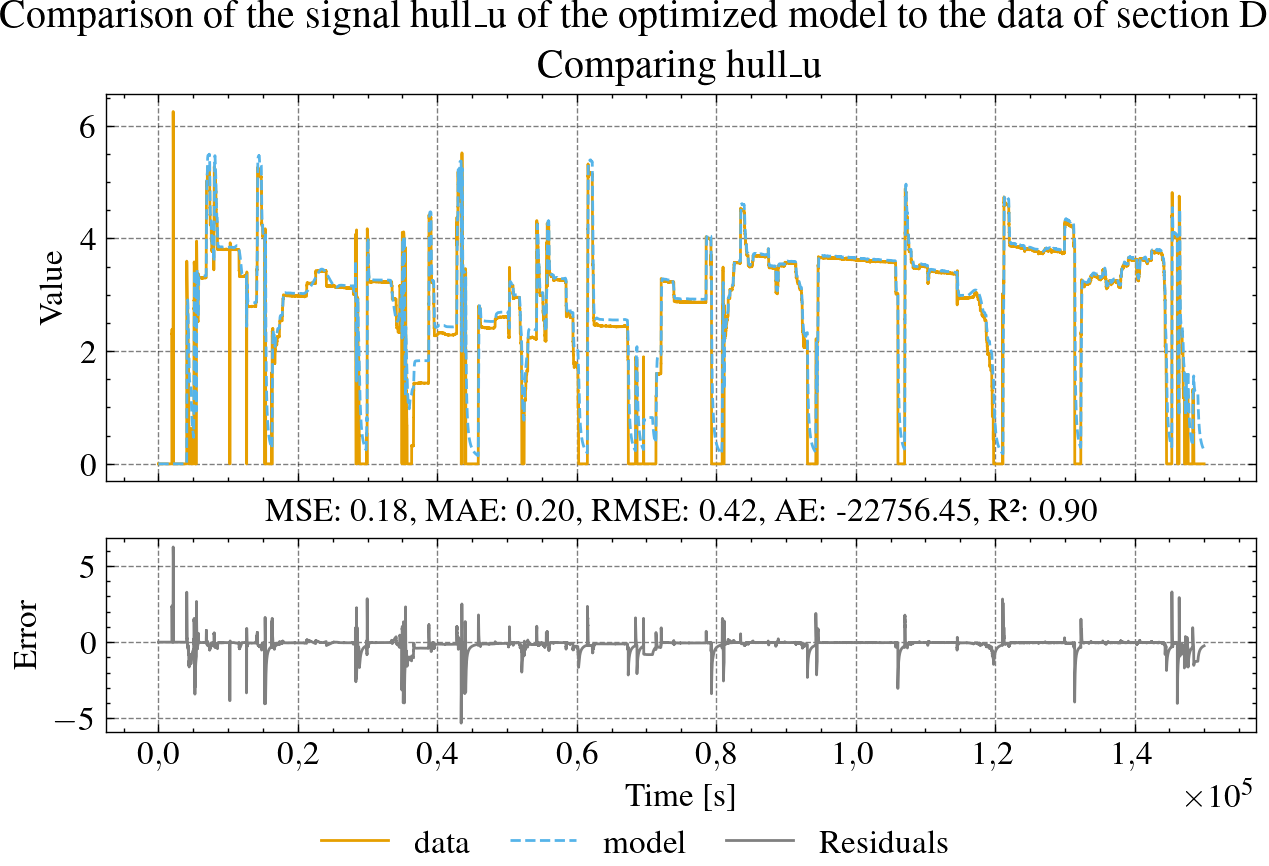

/home/joaoantoniocardoso/workspace_TCC/repo/thesis/assets/generated//propulsion_optimization_test_residuals_motor_w_test_e.pdf


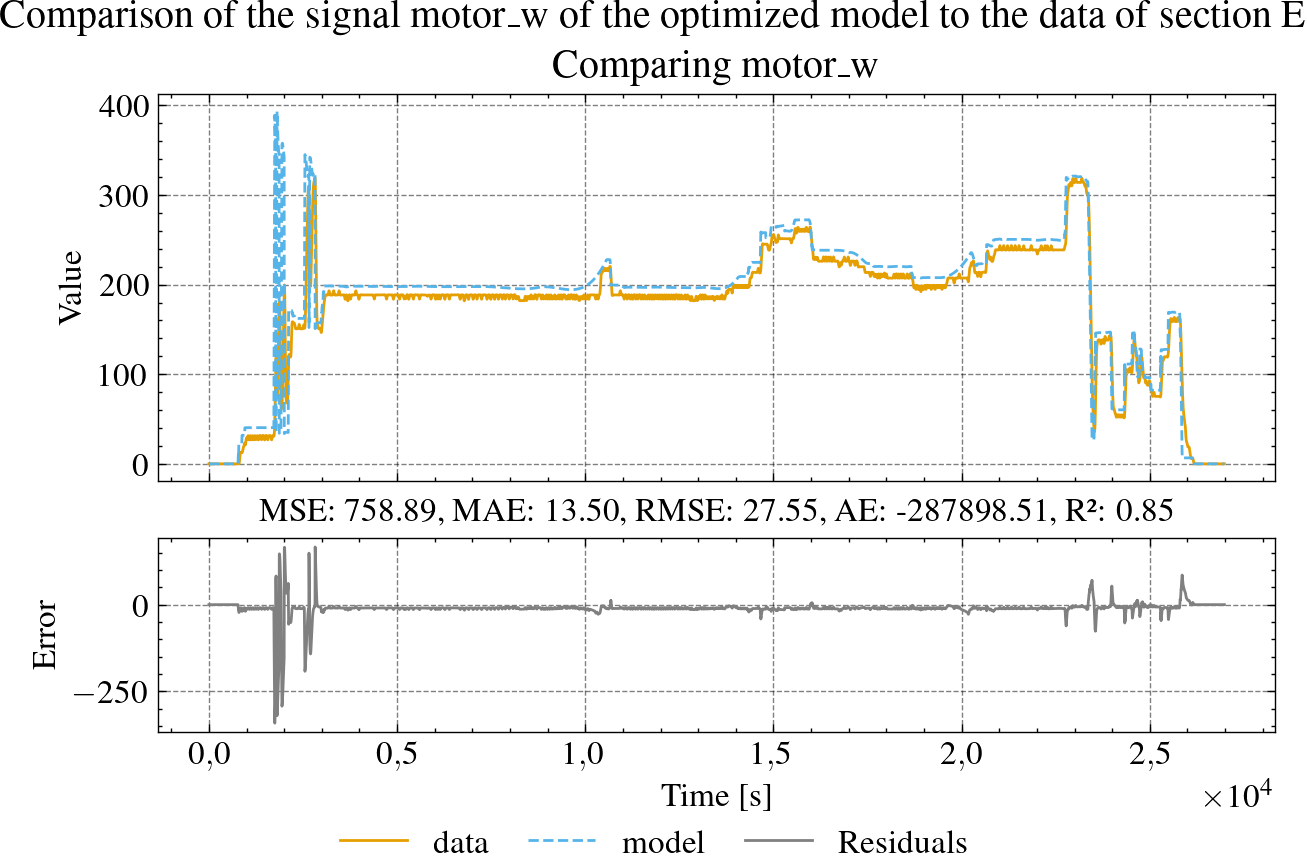

/home/joaoantoniocardoso/workspace_TCC/repo/thesis/assets/generated//propulsion_optimization_test_residuals_esc_i_in_test_e.pdf


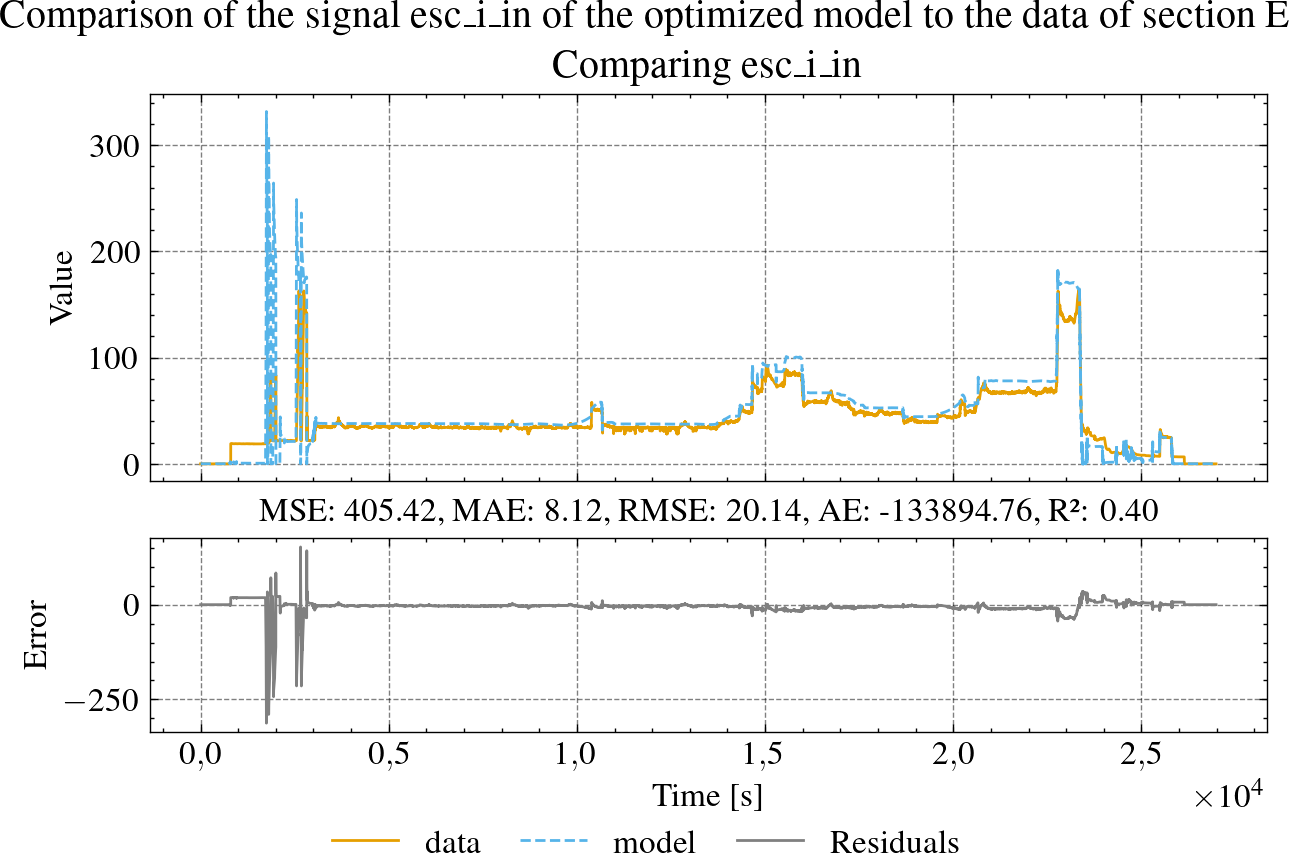

/home/joaoantoniocardoso/workspace_TCC/repo/thesis/assets/generated//propulsion_optimization_test_residuals_hull_u_test_e.pdf


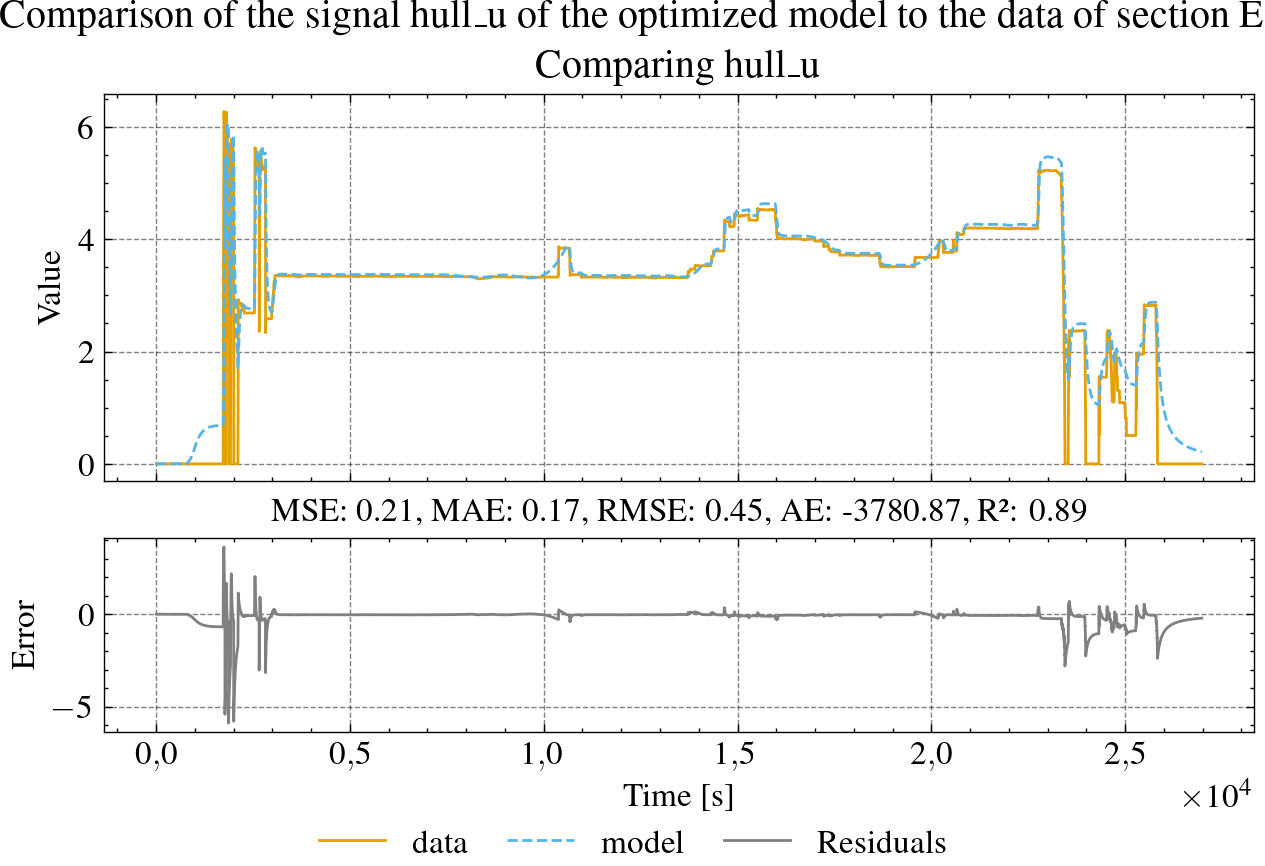

/home/joaoantoniocardoso/workspace_TCC/repo/thesis/assets/generated//propulsion_optimization_test_residuals_motor_w_test_f1.pdf


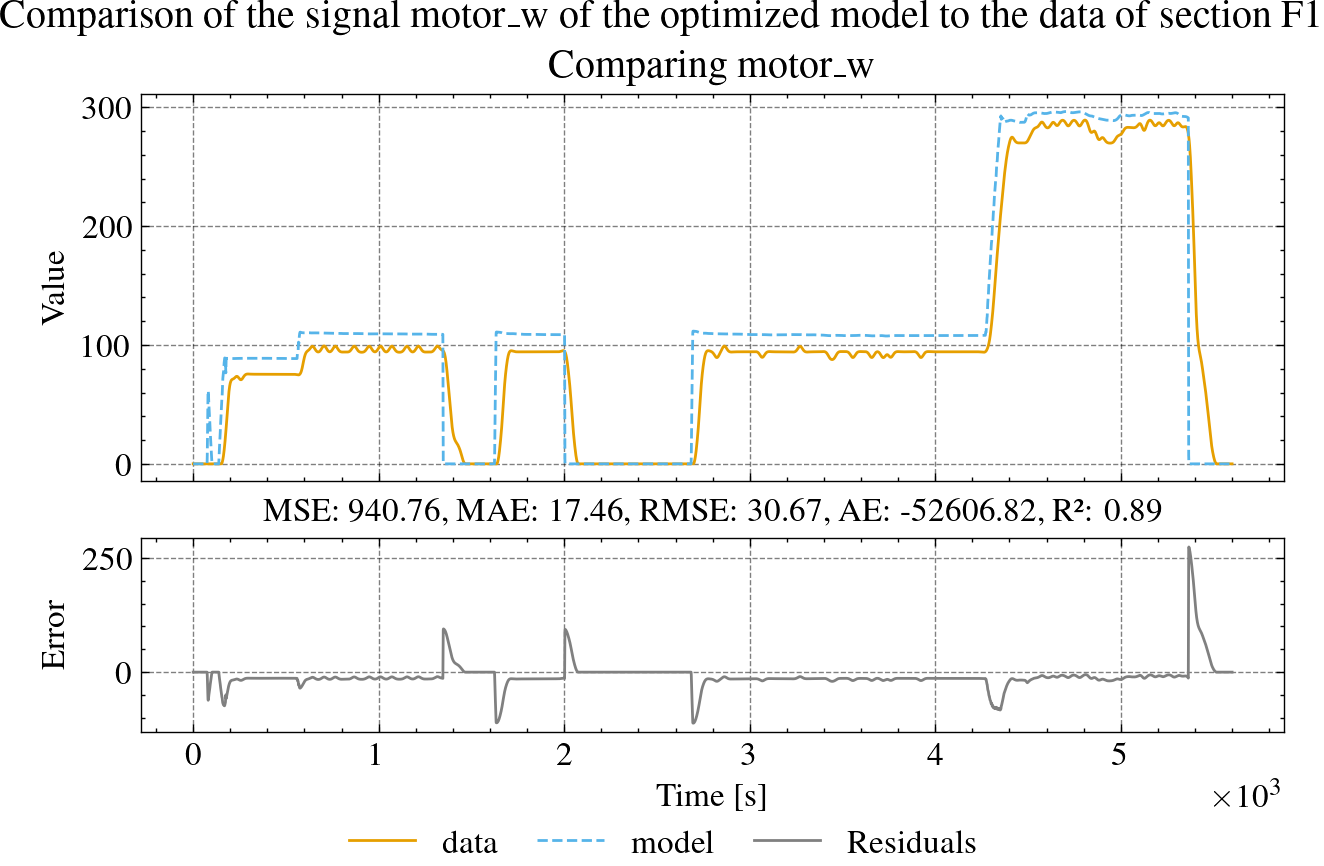

/home/joaoantoniocardoso/workspace_TCC/repo/thesis/assets/generated//propulsion_optimization_test_residuals_esc_i_in_test_f1.pdf


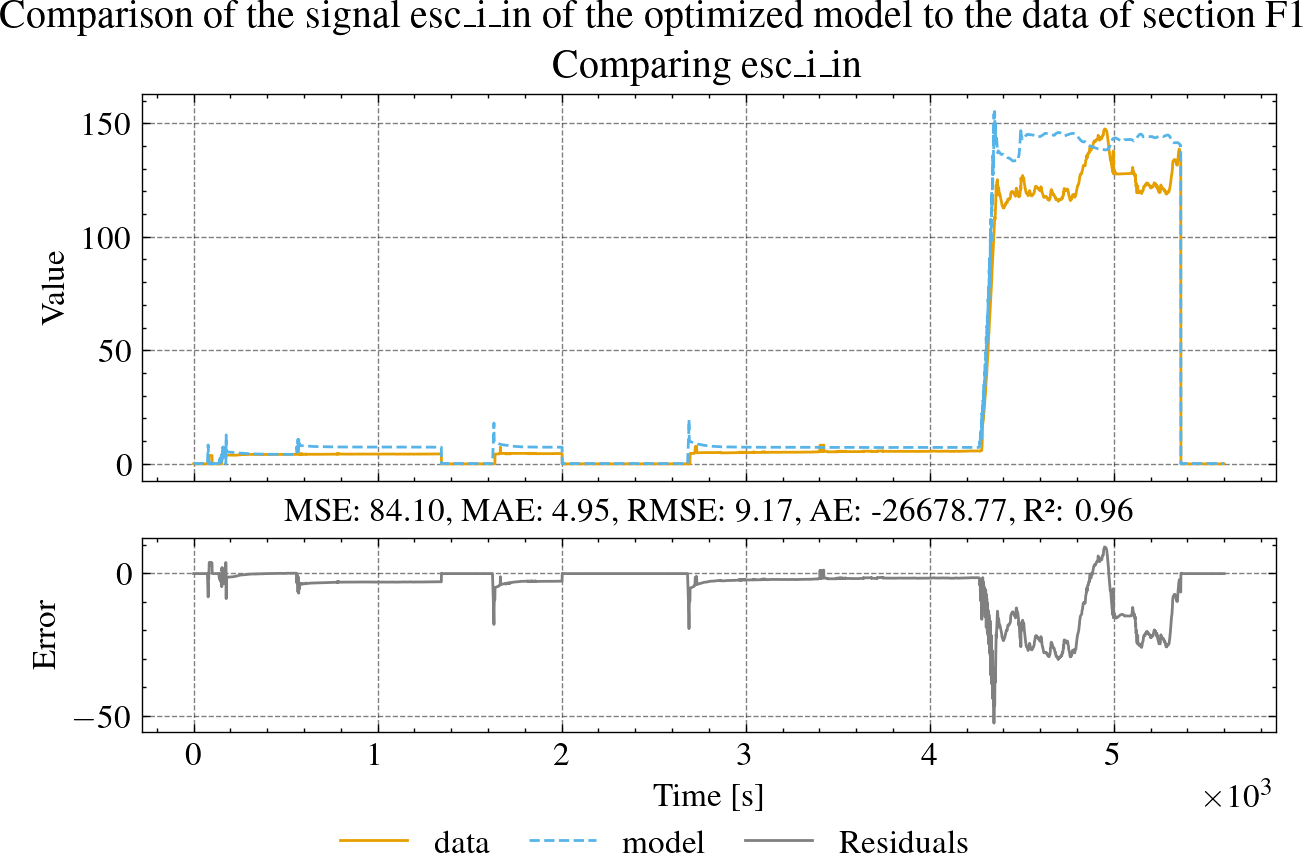

/home/joaoantoniocardoso/workspace_TCC/repo/thesis/assets/generated//propulsion_optimization_test_residuals_hull_u_test_f1.pdf


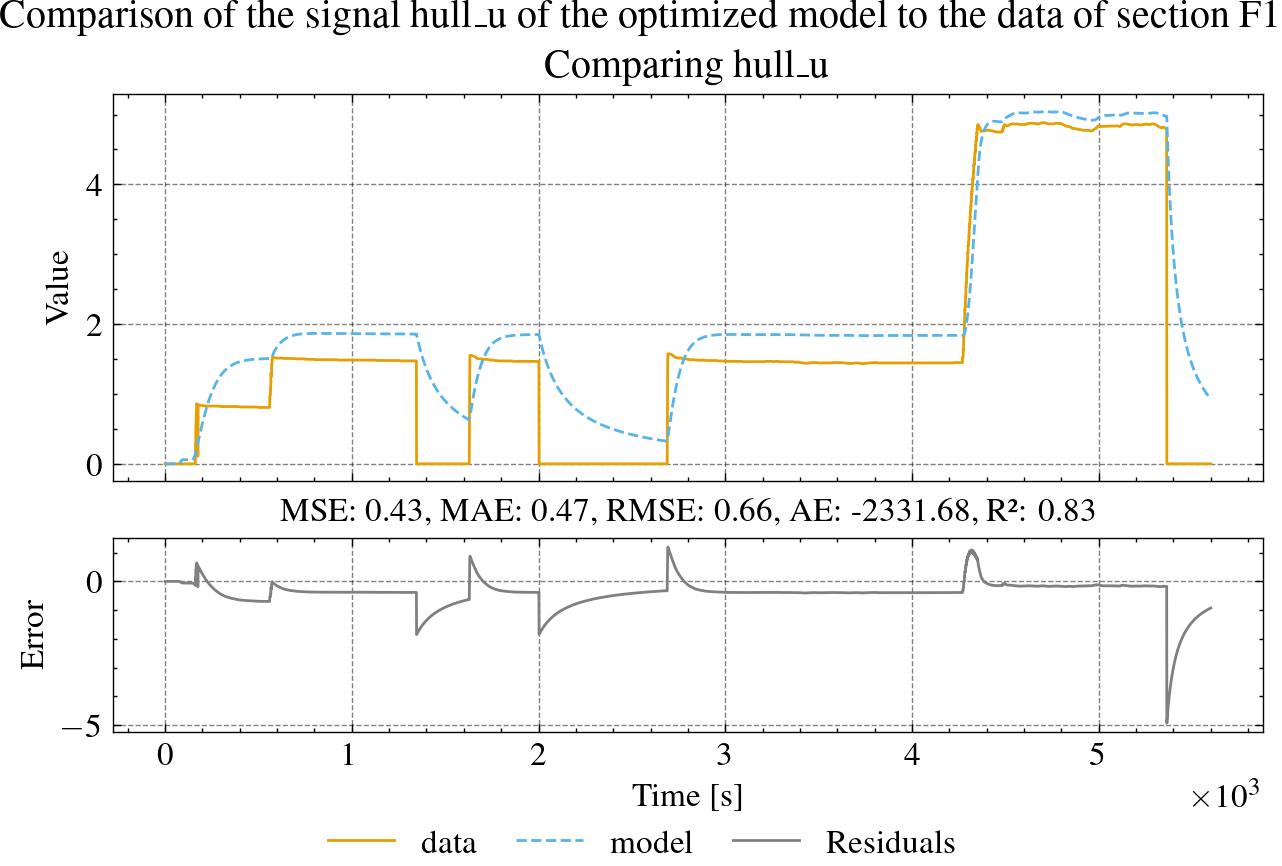

/home/joaoantoniocardoso/workspace_TCC/repo/thesis/assets/generated//propulsion_optimization_test_residuals_motor_w_test_f2.pdf


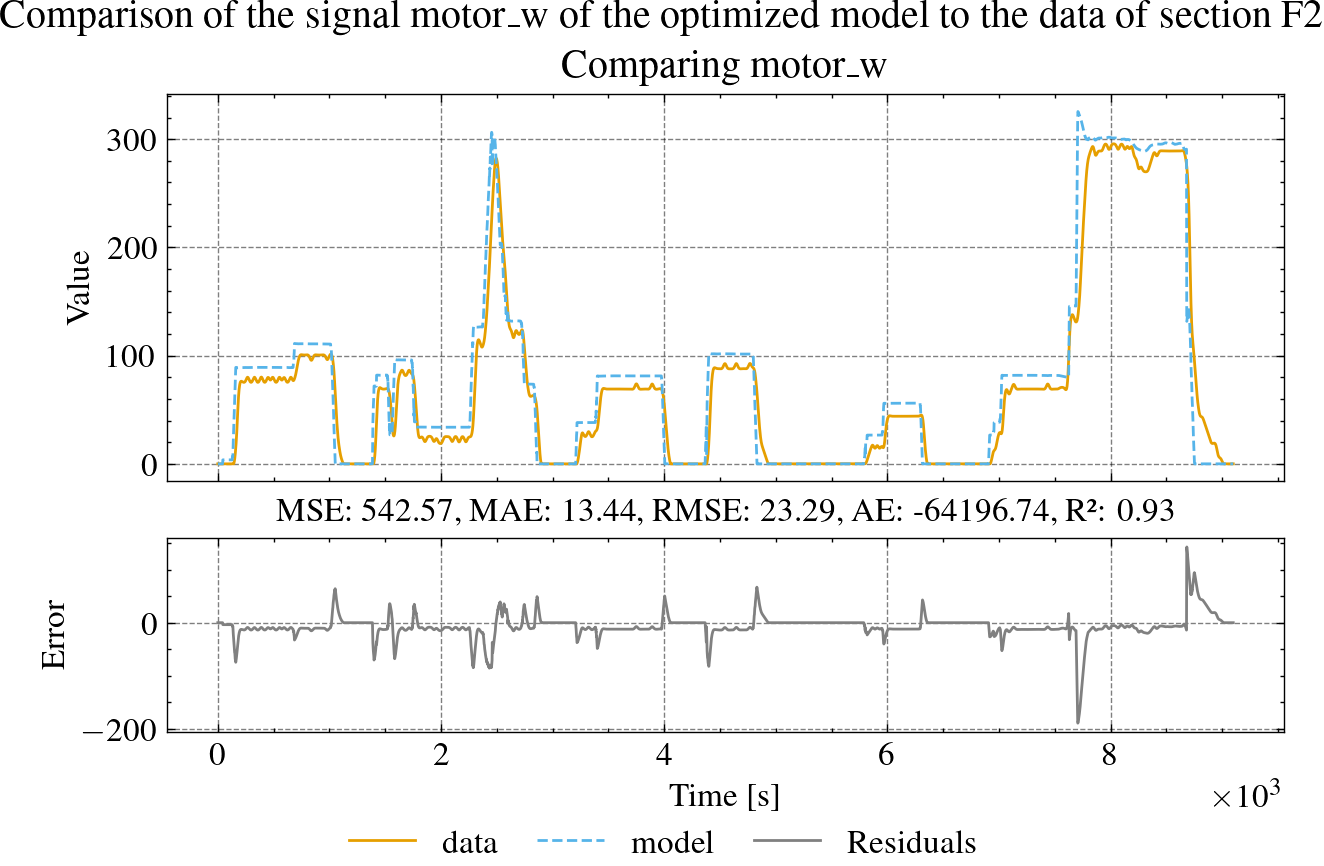

/home/joaoantoniocardoso/workspace_TCC/repo/thesis/assets/generated//propulsion_optimization_test_residuals_esc_i_in_test_f2.pdf


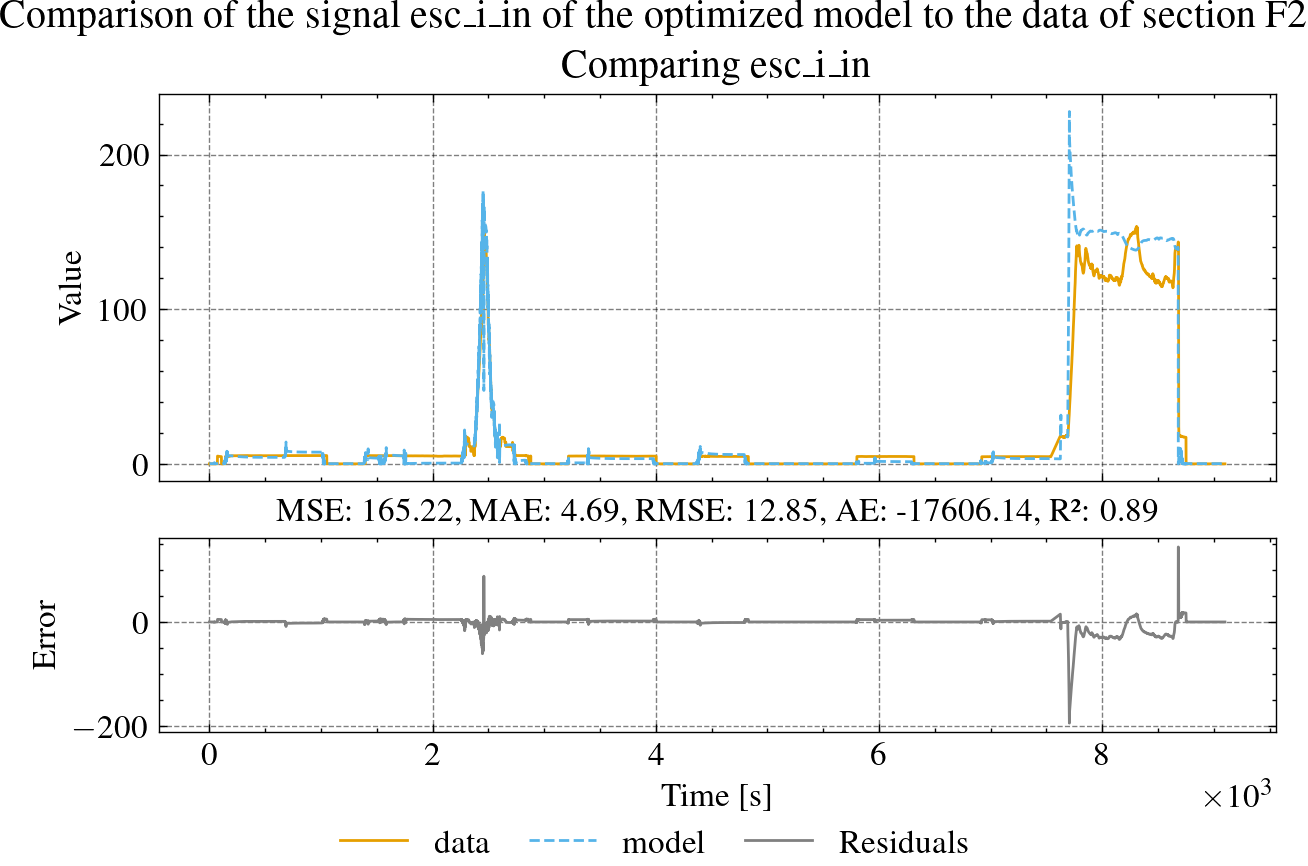

/home/joaoantoniocardoso/workspace_TCC/repo/thesis/assets/generated//propulsion_optimization_test_residuals_hull_u_test_f2.pdf


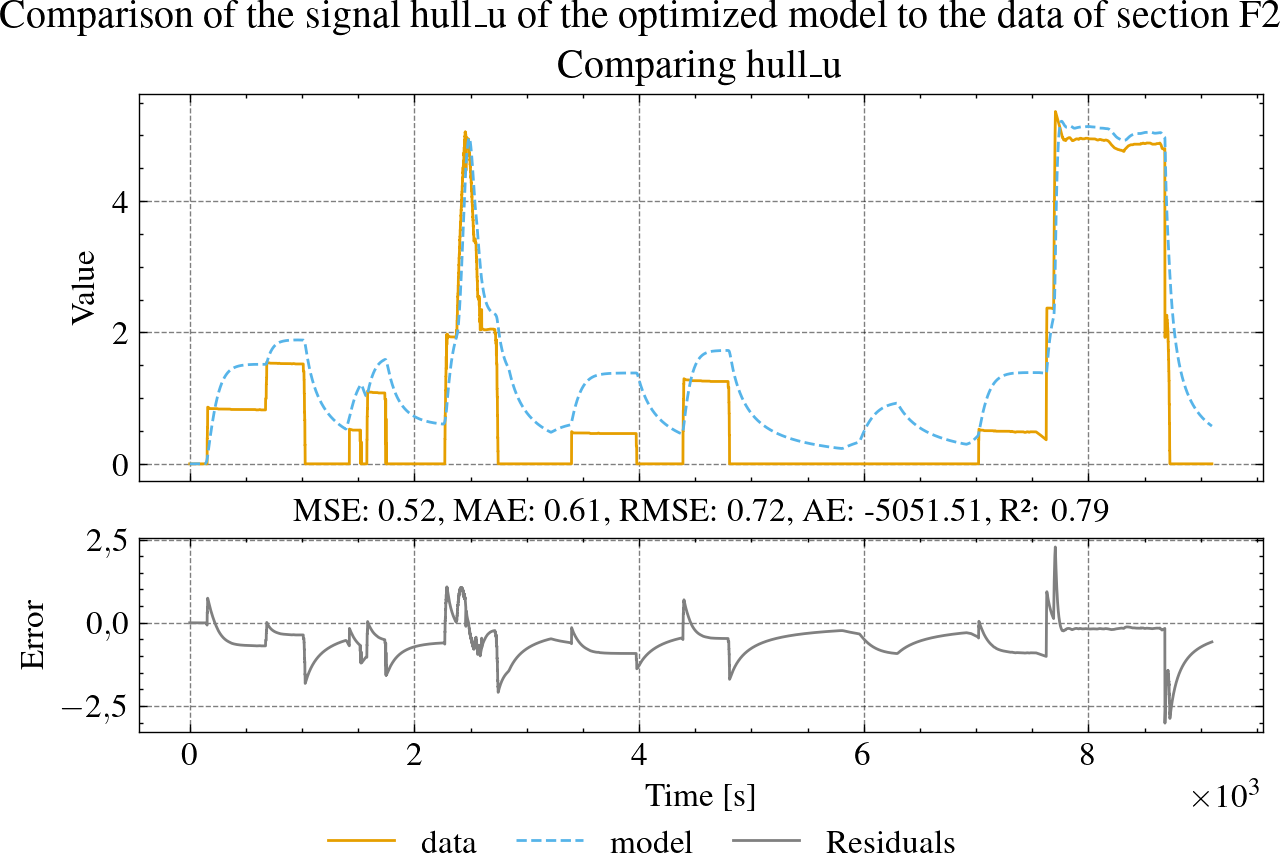

/home/joaoantoniocardoso/workspace_TCC/repo/thesis/assets/generated//propulsion_optimization_test_residuals_motor_w_test_f3.pdf


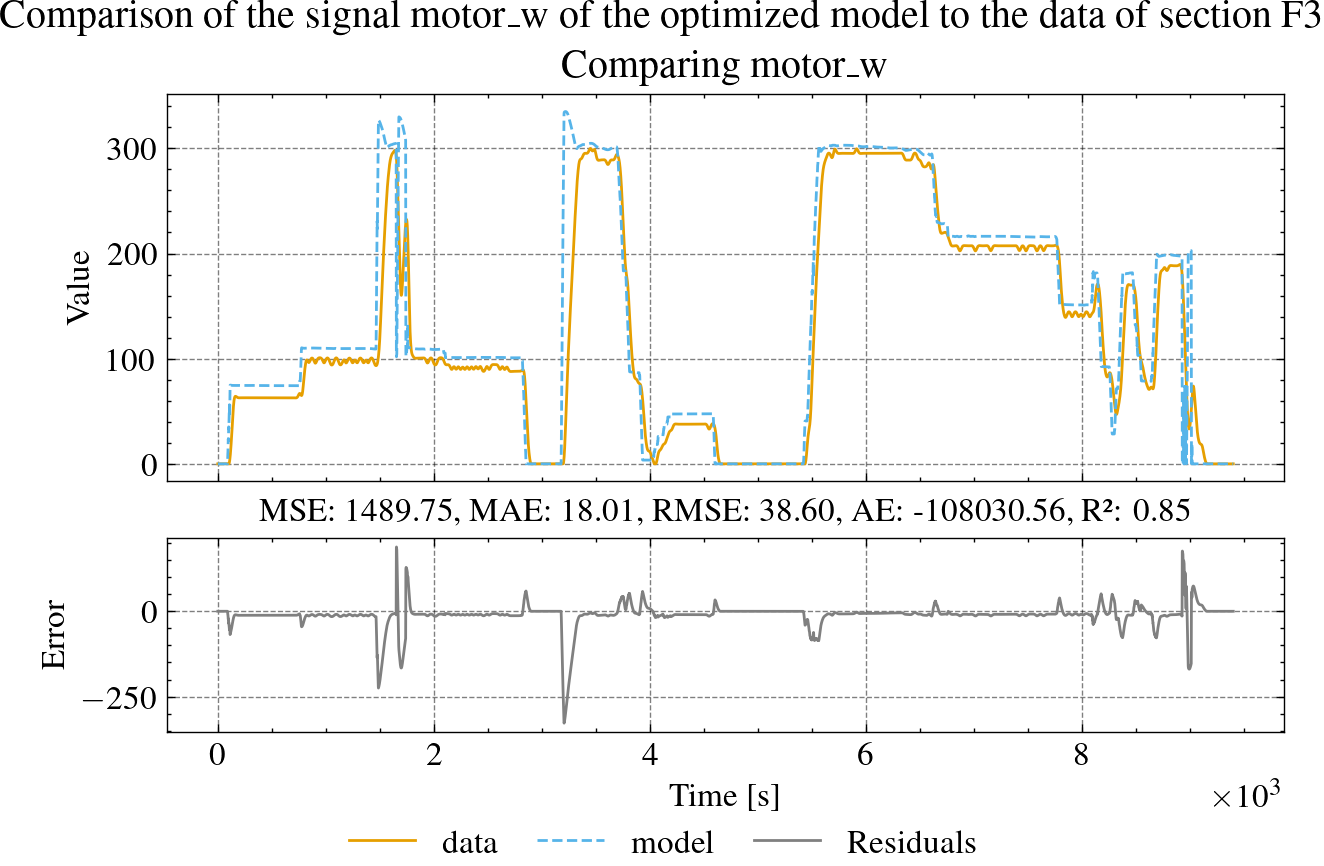

/home/joaoantoniocardoso/workspace_TCC/repo/thesis/assets/generated//propulsion_optimization_test_residuals_esc_i_in_test_f3.pdf


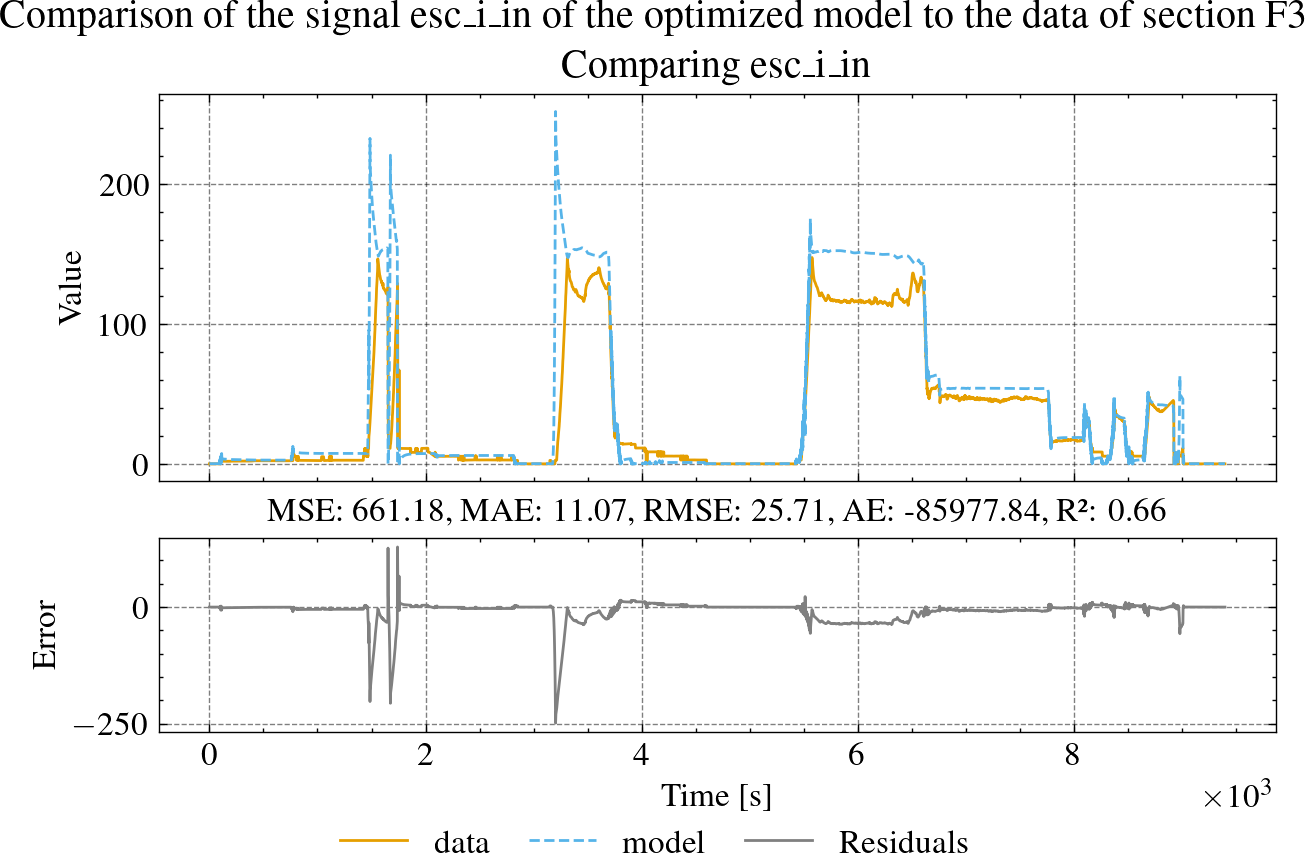

/home/joaoantoniocardoso/workspace_TCC/repo/thesis/assets/generated//propulsion_optimization_test_residuals_hull_u_test_f3.pdf


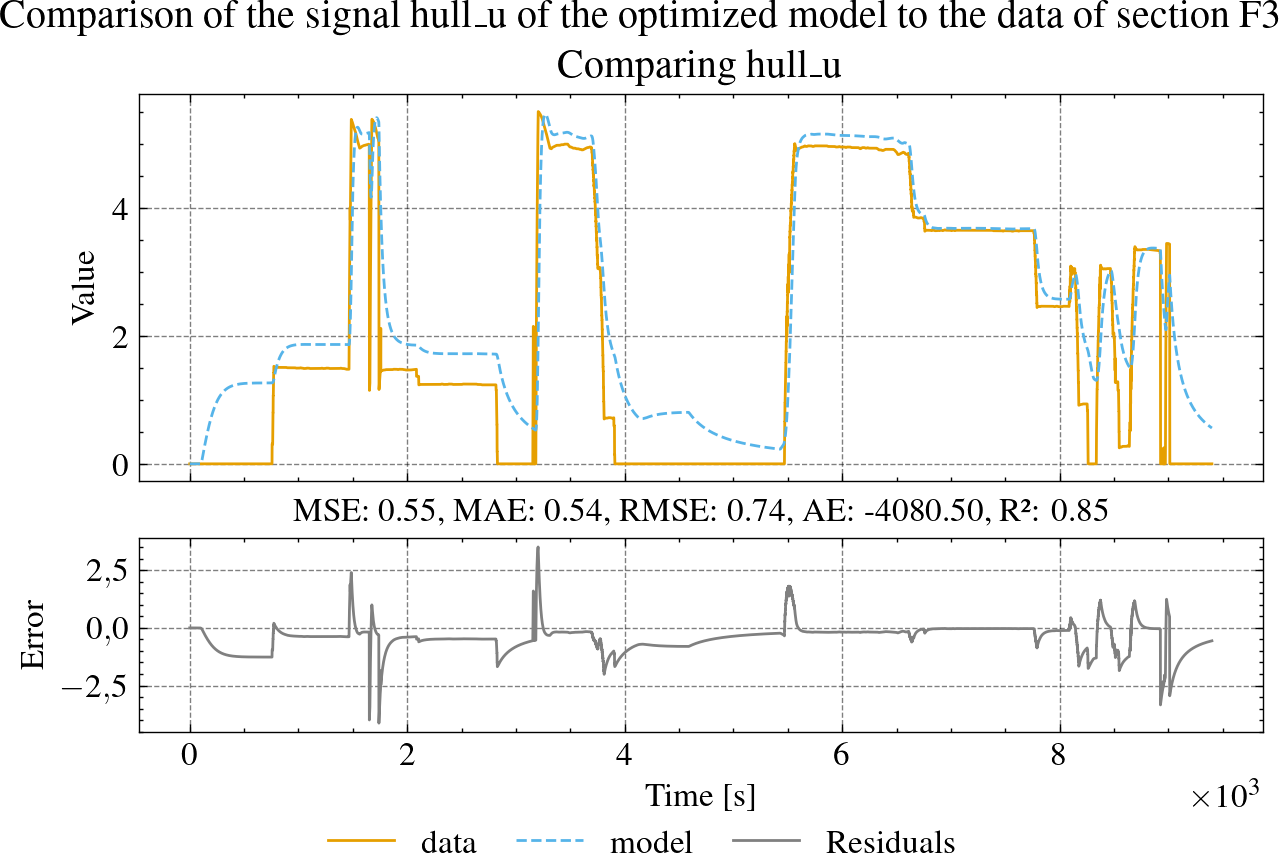

/home/joaoantoniocardoso/workspace_TCC/repo/thesis/assets/generated//propulsion_optimization_test_residuals_motor_w_test_f4.pdf


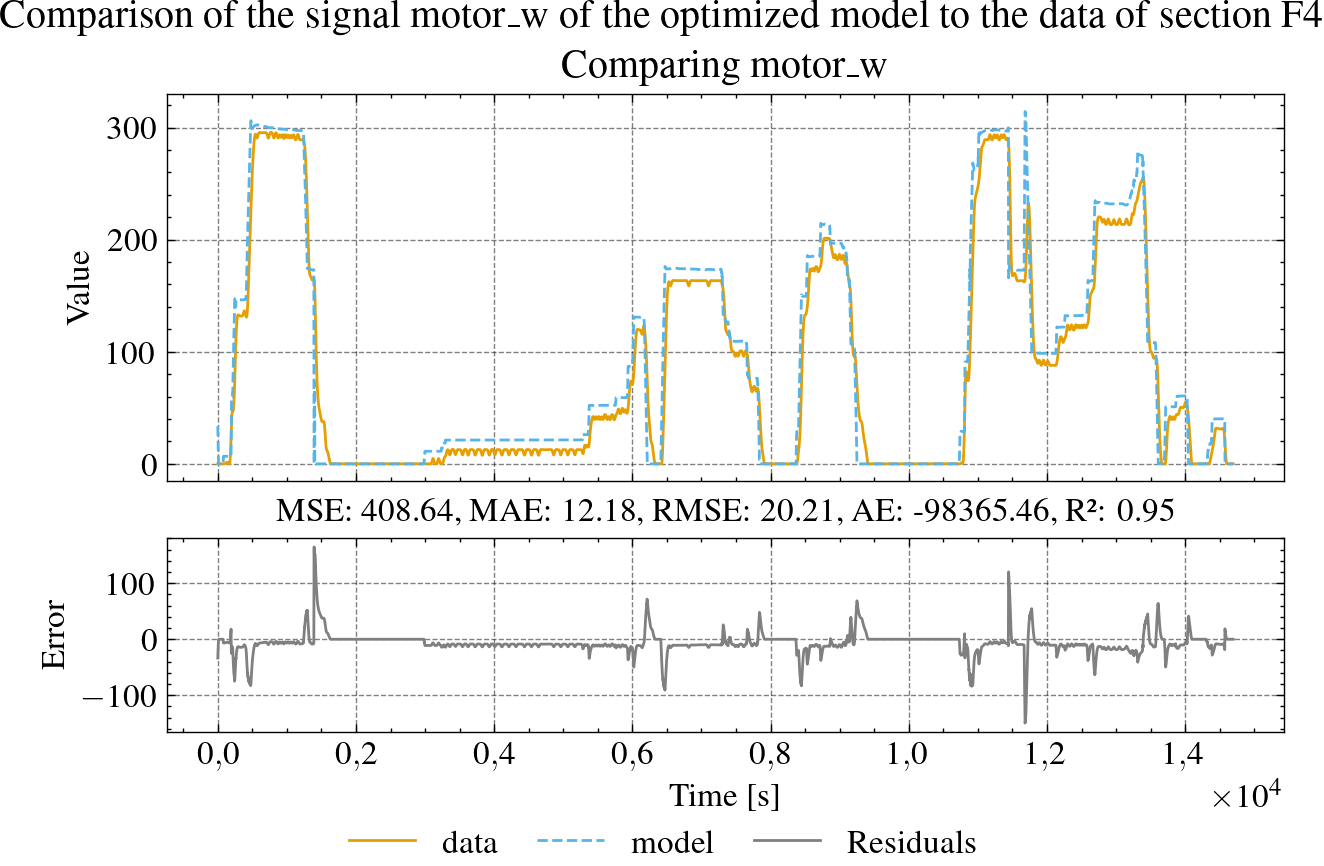

/home/joaoantoniocardoso/workspace_TCC/repo/thesis/assets/generated//propulsion_optimization_test_residuals_esc_i_in_test_f4.pdf


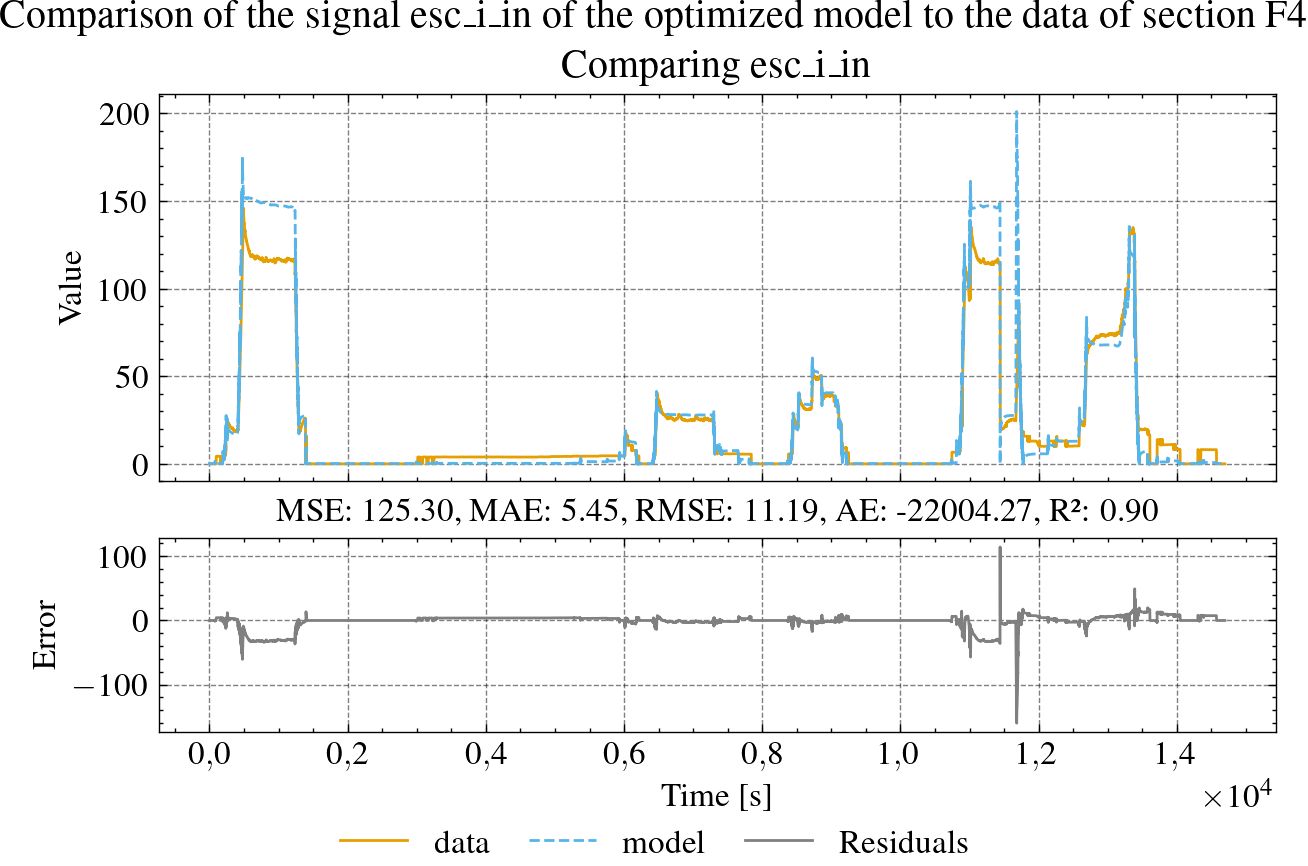

/home/joaoantoniocardoso/workspace_TCC/repo/thesis/assets/generated//propulsion_optimization_test_residuals_hull_u_test_f4.pdf


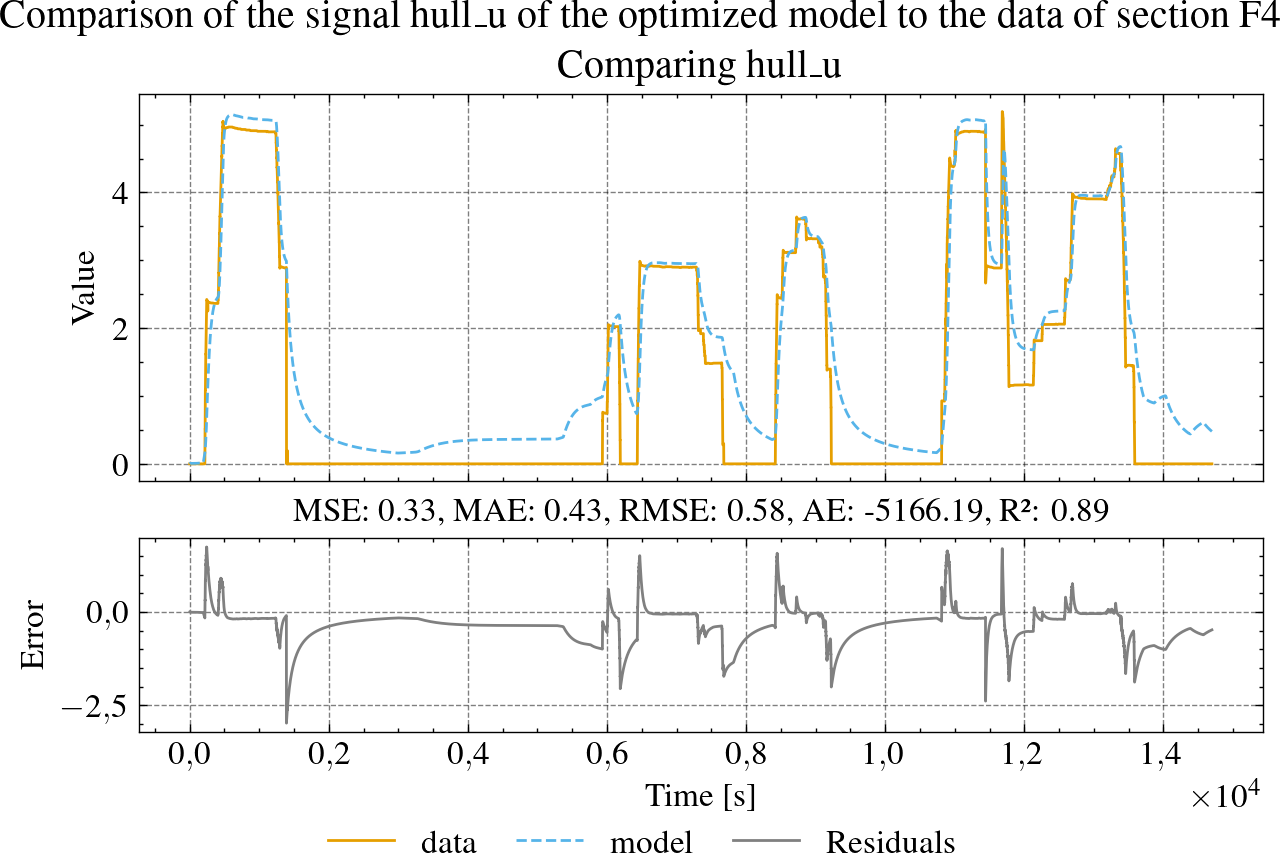

In [19]:
# Initialize a list to store metrics
metrics_list = []
for section in sections.reset_index().to_dict(orient='records'):
    section_name = section['name'].replace('Section ', '')

    # Select the data and simulate
    df_test = df.loc[(df.index >= section['start']) & (df.index <= section['end']), ['t'] + data_cols + input_cols].dropna()
    if df_test.size == 0:
        print('Ignoring section', section_name, ' because of insufficient size')
        continue

    # Simulate
    T = df_test['t'].to_numpy()
    U = df_test[input_cols].to_numpy().T
    X0 = model.initial_state(X0=input_initial_state, U0=U[:,0], params=model_params)

    df_pred = model_function(T, U, X0, **(model_params))

    # Compute metrics for each data column
    for col in data_cols:
        metrics = compute_metrics(df_test[col].to_numpy(), df_pred[col].to_numpy())
        metrics['section'] = section_name
        metrics['data'] = col

        metrics_list.append(metrics)

# Create a DataFrame from the metrics list
df_metrics = pd.DataFrame(metrics_list).drop(columns=['residuals']).set_index(['section', 'data'])
display(df_metrics)

metrics_table_latex = df_metrics.to_latex(
    index=True,
    caption="Métricas de avaliação do modelo da Geração",
    label="table:propulsion_optimization_metrics_table",
    float_format="%.2f",
    column_format="l|l" + "|c" * (len(df_metrics.columns)),
    escape=True,
    decimal=',',
    position='H',
    multicolumn=True,
).replace('\\toprule', '\\hline').replace('\\bottomrule\n', '').replace('\\midrule', '\\hline').replace('\\end{table}', '\\fonte{Elaboração Própria (\\the\\year)}\n\\end{table}')

with open(f"{latex_tex_path}/propulsion_optimization_metrics_table.tex", "w") as f:
    f.write(metrics_table_latex)

for section in sections.reset_index().to_dict(orient='records'):
    section_name = section['name'].replace('Section ', '')

    df_test = df.loc[(df.index >= section['start']) & (df.index <= section['end']), ['t'] + data_cols + input_cols].dropna()
    if df_test.size == 0:
        print('Ignoring section', section_name, ' because of insufficient size')
        continue

    # Simulate
    T = df_test['t'].to_numpy()
    U = df_test[input_cols].to_numpy().T
    X0 = model.initial_state(X0=input_initial_state, U0=U[:,0], params=model_params)

    df_pred = model_function(T, U, X0, **(model_params))

    # Plot comparison for each data column
    for col in data_cols:
        filename = f'{latex_img_path}/propulsion_optimization_test_residuals_{col}_test_{section_name.lower()}.pdf'
        print(filename)
        fig_save_and_show(
            filename=filename,
            show_title=f'Comparison of the signal {col} of the optimized model to the data of section {section_name}',
            save_title=f'Comparação do sinal {col} do modelo otimizado com os dados da seção {section_name}',
            ncol=3,
            fig=plot_compare(df_test, df_pred, col, show=False),
        )


In [20]:
from utils.plot import plot_efficiency_map_scattered
from utils.control import get_steady_state_map

In [21]:
def model_function(T, U, X0, **params) -> pd.DataFrame:
    resp = ct.input_output_response(
        Propulsion.build(params=params),
        T=np.asarray(T, float),
        U=np.asarray(U, float),
        X0=np.asarray(X0, float),
        solve_ivp_method='Radau',
    ).to_pandas()
    
    # Params
    hull_T_ded = params['hull_T_ded']
    hull_W = params['hull_W']

    # Signals
    motor_v = np.asarray(resp['motor_v'], float)
    motor_q_load = np.asarray(resp['motor_q_load'], float)
    motor_i = np.asarray(resp['motor_i'], float)
    motor_w = np.asarray(resp['motor_w'], float)
    esc_i_in =  np.asarray(resp['esc_i_in'], float)
    esc_v_in = np.asarray(resp['batt_v'], float)
    hull_r_t = np.asarray(resp['hull_r_t'], float)
    hull_u = np.asarray(resp['hull_u'], float)
    prop_w = np.asarray(resp['prop_w'], float)
    prop_q = np.asarray(resp['prop_q'], float)
    prop_t = np.asarray(resp['prop_t'], float)

    # Motor
    motor_p_in = motor_v * motor_i
    motor_p_out = motor_w * motor_q_load
    motor_eta = np.ma.masked_invalid(motor_p_out / motor_p_in)
    resp['motor_p_in'] = motor_p_in
    resp['motor_p_out'] = motor_p_out
    resp['motor_eta'] = motor_eta

    # ESC
    esc_i_out =  motor_i
    esc_v_out = motor_v
    esc_p_in = esc_i_in * esc_v_in
    esc_p_out = esc_i_out * esc_v_out
    esc_eta = esc_p_out / esc_p_in
    resp['esc_p_in'] = esc_p_in
    resp['esc_p_out'] = esc_p_out
    resp['esc_eta'] = esc_eta

    # Hull
    hull_r_t_t = hull_r_t* (1 - hull_T_ded)
    hull_p_out = hull_r_t_t * hull_u
    hull_t = prop_t
    hull_p_in = hull_t * hull_u
    hull_eta = hull_p_out / hull_p_in
    resp['hull_p_in'] = hull_p_in
    resp['hull_p_out'] = hull_p_out
    resp['hull_eta'] = hull_eta

    # Prop
    prop_p_in = prop_w * prop_q
    prop_u = hull_u * (1 - hull_W)
    prop_p_out = prop_t * prop_u
    prop_eta = prop_p_out / prop_p_in
    resp['prop_p_in'] = prop_p_in
    resp['prop_p_out'] = prop_p_out
    resp['prop_eta'] = prop_eta

    # Trans
    trans_w_in = motor_w
    trans_w_out = prop_w
    trans_q_in = motor_q_load
    trans_q_out = prop_q
    trans_p_in = trans_w_in * trans_q_in
    trans_p_out = trans_w_out * trans_q_out
    trans_eta = trans_p_out / trans_p_in
    resp['trans_p_in'] = trans_p_in
    resp['trans_p_out'] = trans_p_out
    resp['trans_eta'] = trans_eta

    resp['propulsive_eta'] = hull_p_out / esc_p_in
    resp['propulsive_electrical_eta'] = motor_p_out / esc_p_in
    resp['propulsive_mechanical_eta'] = hull_p_out / prop_p_in

    return resp


Y_ss = get_steady_state_map(
    model_class=Propulsion,
    model_function=model_function,
    model_params=model_params,
    sweep_bounds={
        'batt_v': dict(min=36, max=36),
        'esc_d': dict(min=0, max=1),
    },
    sweep_steps=100,
    dt=1,
    ss_len=10,
    ss_tail_len=2,
)

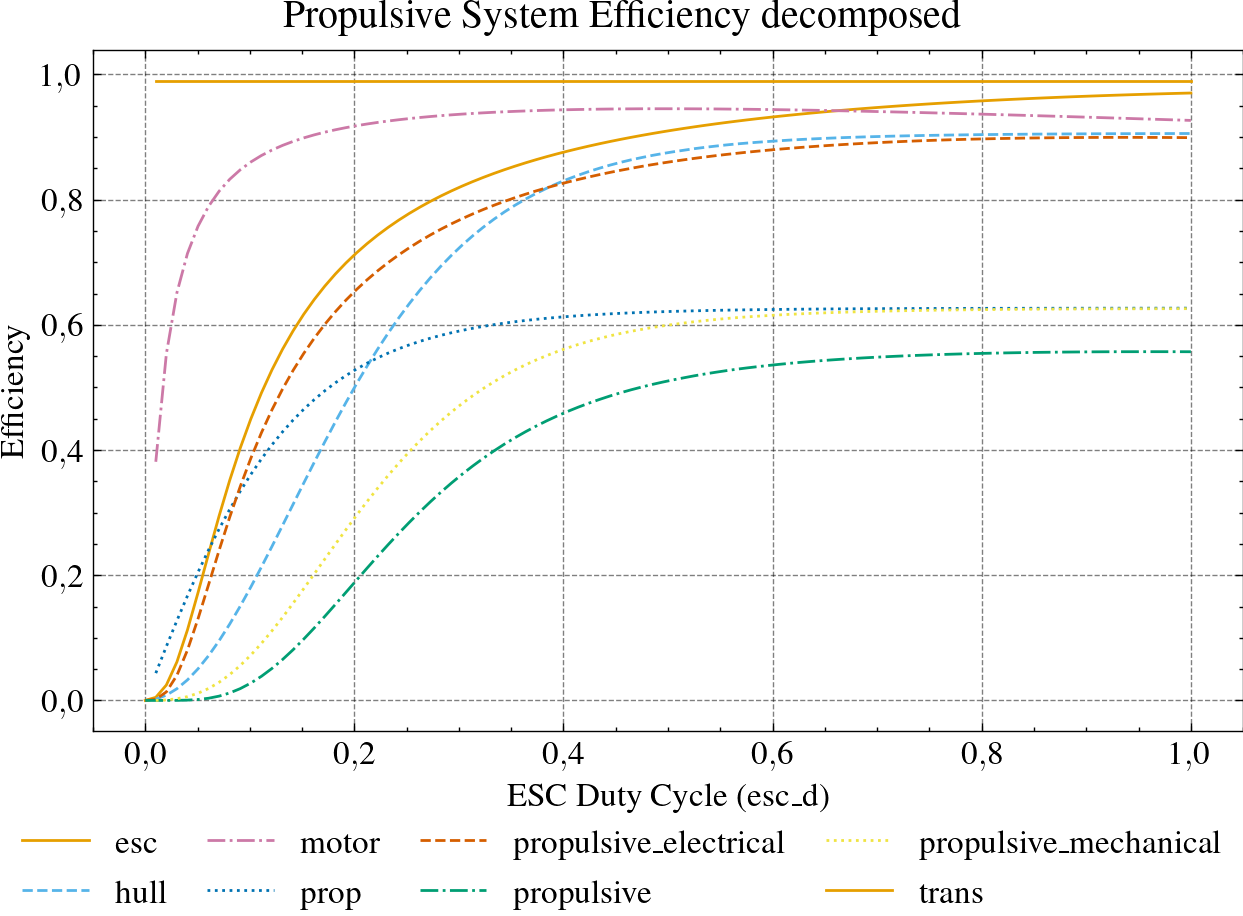

In [22]:
eta_cols = sorted(set([c for c in Y_ss.columns if c.endswith('_eta')]))

Y_ss2 = Y_ss.copy().groupby('esc_d').mean().reset_index()

fig = plt.figure(figsize=figsize())
for eta_col in eta_cols:
    plt.plot(Y_ss2['esc_d'], Y_ss2[eta_col], label=eta_col[:-4])

plt.xlabel('ESC Duty Cycle (esc_d)')
plt.ylabel('Efficiency')
fig_save_and_show(
    filename=f"{latex_img_path}/propulsive_system_efficiency_decomposed.pdf",
    show_title="Propulsive System Efficiency decomposed",
    save_title="Eficiência do sistema propulsivo decomposta",
    ncol=4,
    fig=fig,
);

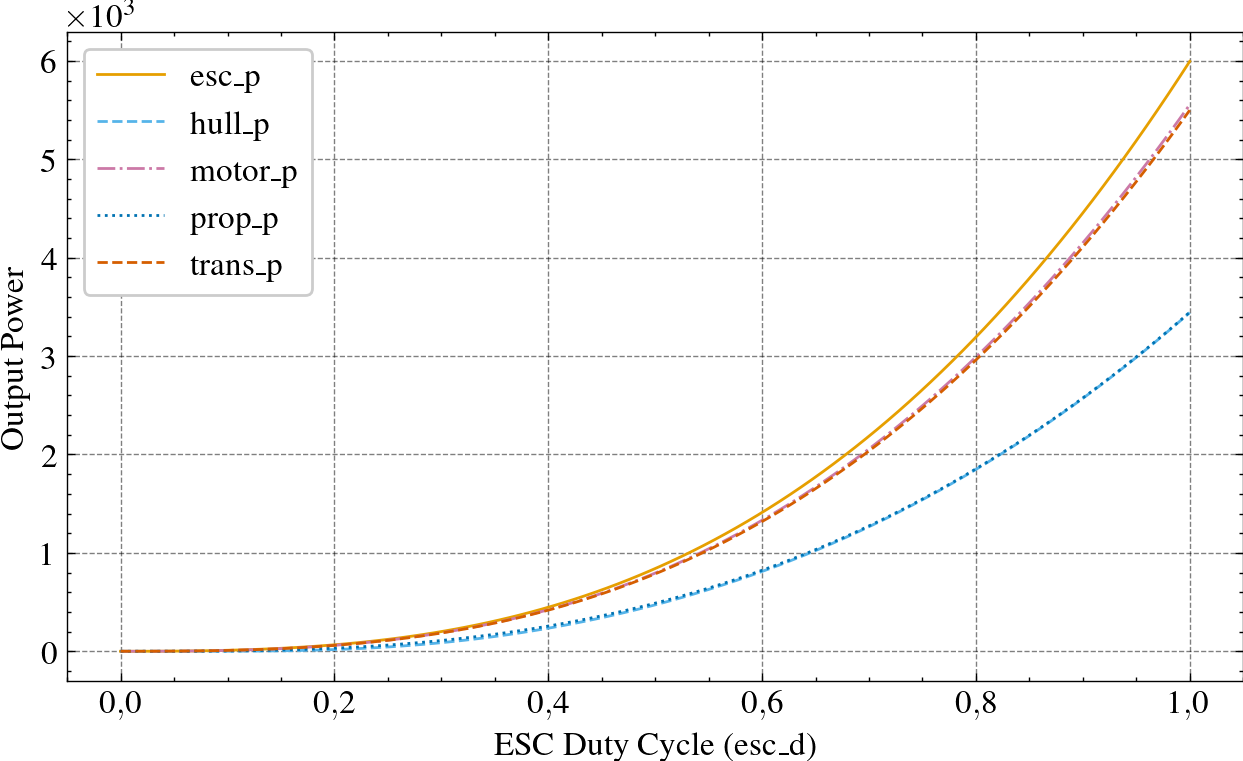

In [24]:
p_out_cols = sorted(set([c for c in Y_ss.columns if c.endswith('_p_out')]))

Y_ss2 = Y_ss.copy().groupby('esc_d').mean().reset_index()
for p_out_col in sorted(p_out_cols):
    plt.plot(Y_ss2['esc_d'], Y_ss2[p_out_col], label=p_out_col[:-4])

plt.xlabel('ESC Duty Cycle (esc_d)')
plt.ylabel('Output Power')
plt.legend()
plt.show()


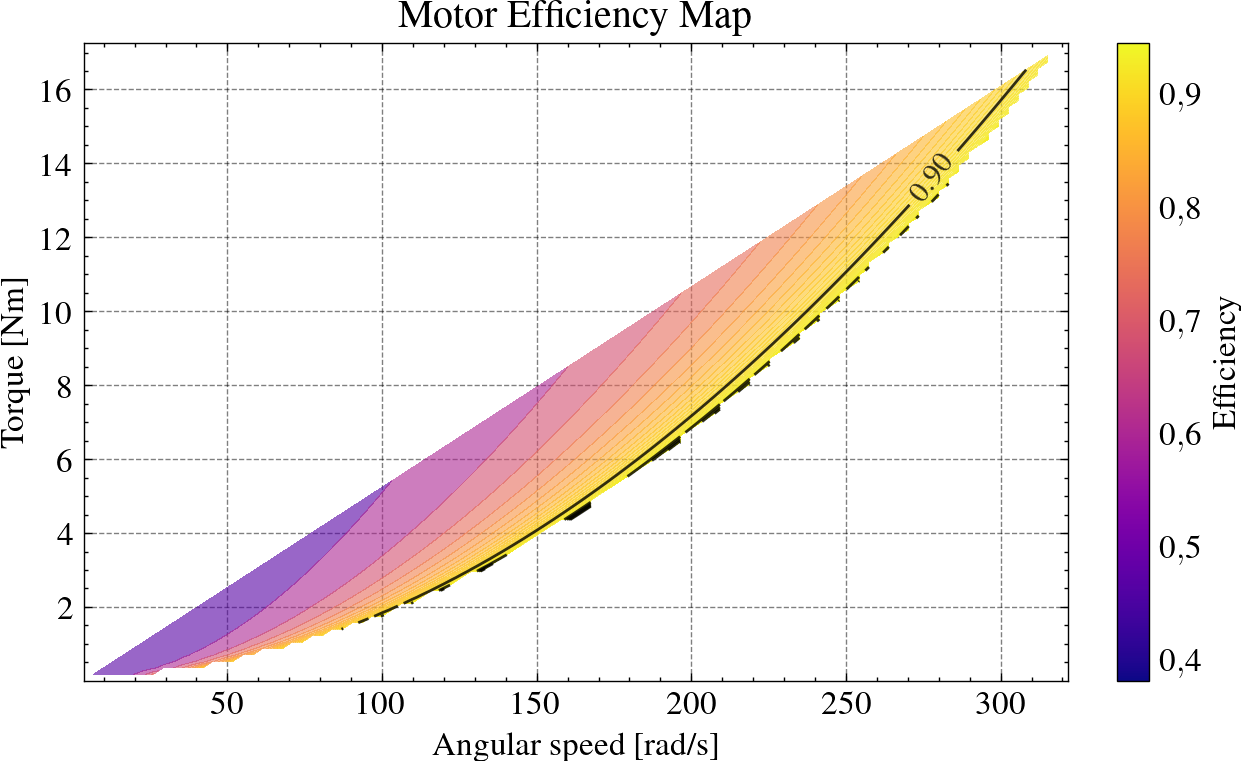

In [25]:
fig, ax, out = plot_efficiency_map_scattered(
    Y_ss,
    x='motor_w', y='motor_q_load', z='motor_eta',
    nx=100, ny=100,
    mask_col='motor_p_out', mask_min=0,
    level_pmin=0, level_pmax=100, level_n=100,
    contour_lines=True,
    line_pmin=0, line_pmax=95, line_n=7,
    line_colors='k',
    label_lines=1,
    title='Motor Efficiency Map',
    xlabel='Angular speed [rad/s]',
    ylabel='Torque [Nm]',
    cbar_label='Efficiency',
    cmap='plasma',
    fill_alpha=0.6,
)
plt.show()

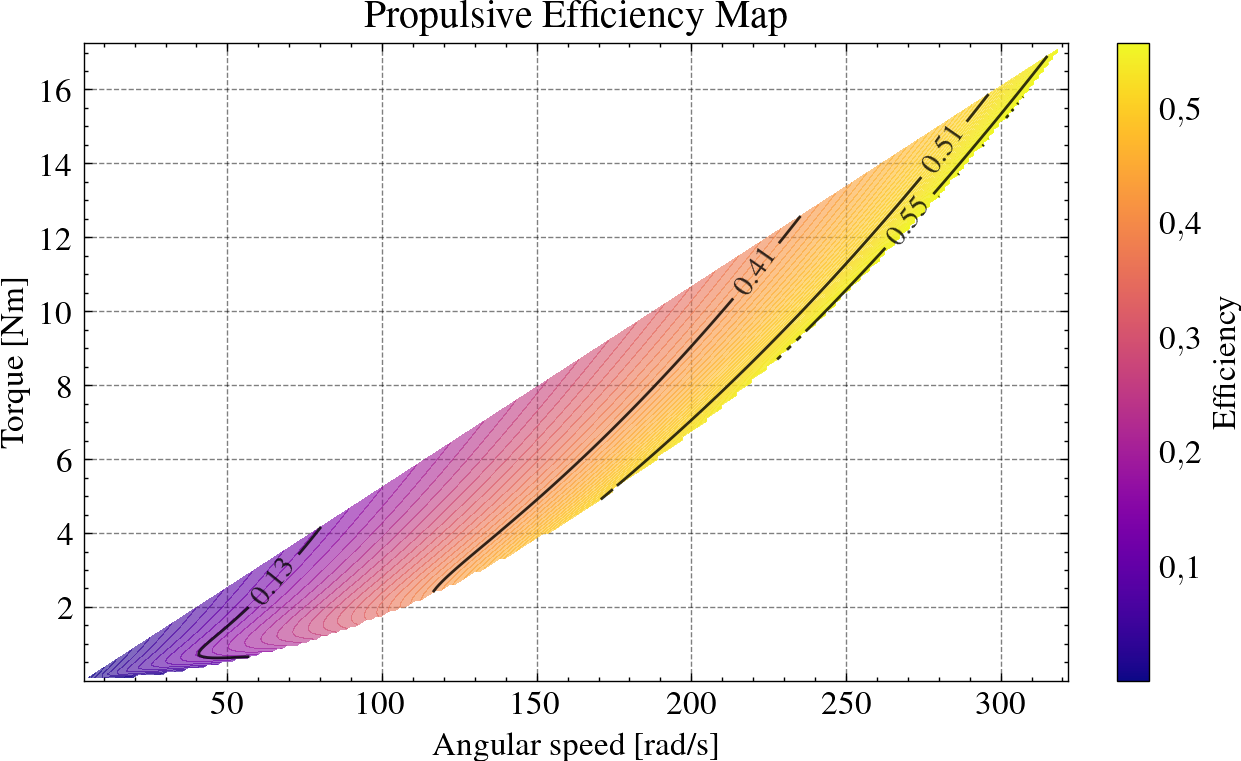

In [26]:
fig, ax, out = plot_efficiency_map_scattered(
    Y_ss,
    x='motor_w', y='motor_q_load', z='propulsive_eta',
    nx=200, ny=200,
    mask_col='motor_p_out', mask_min=0,
    level_pmin=0, level_pmax=100, level_n=100,
    contour_lines=True,
    line_pmin=0, line_pmax=100, line_n=7,
    line_colors='k',
    label_lines=1,
    title='Propulsive Efficiency Map',
    xlabel='Angular speed [rad/s]',
    ylabel='Torque [Nm]',
    cbar_label='Efficiency',
    cmap='plasma',
    fill_alpha=0.6,
)
plt.show()

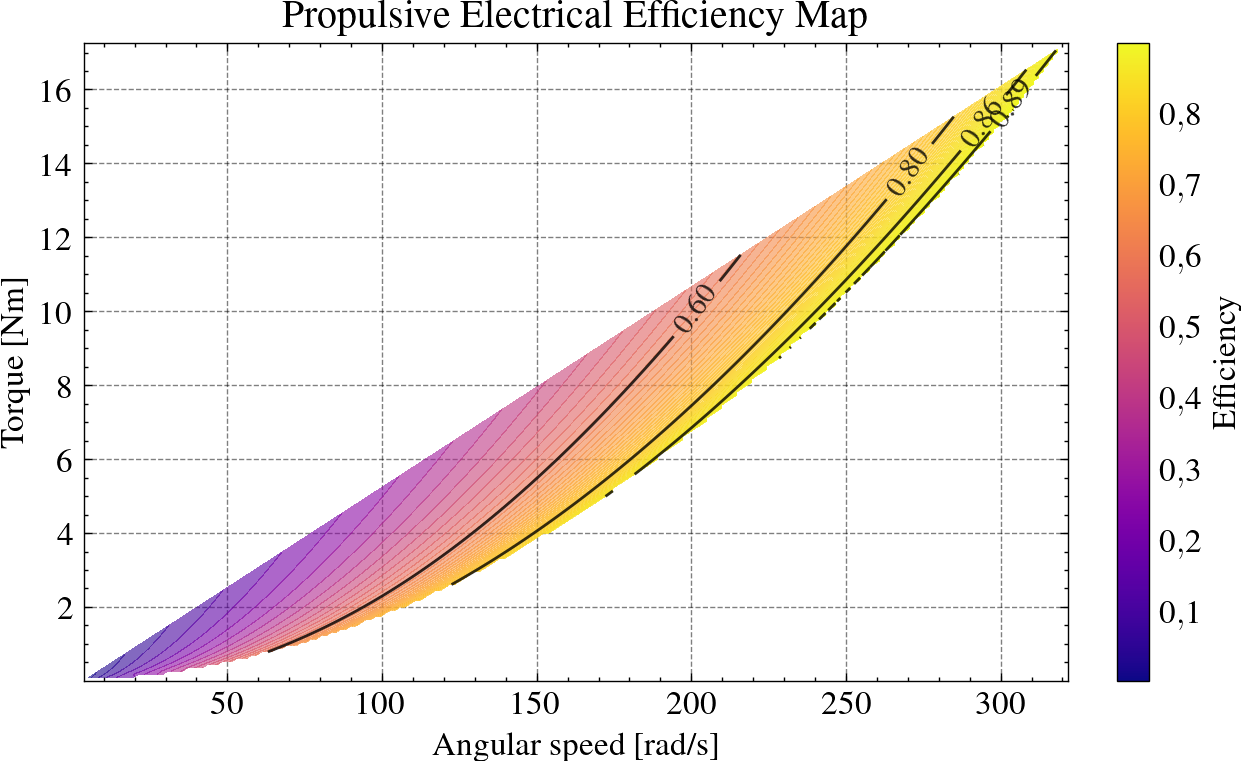

In [27]:
fig, ax, out = plot_efficiency_map_scattered(
    Y_ss,
    x='motor_w', y='motor_q_load', z='propulsive_electrical_eta',
    nx=200, ny=200,
    mask_col='motor_p_out', mask_min=0,
    level_pmin=0, level_pmax=100, level_n=100,
    contour_lines=True,
    line_pmin=0, line_pmax=100, line_n=7,
    line_colors='k',
    label_lines=1,
    title='Propulsive Electrical Efficiency Map',
    xlabel='Angular speed [rad/s]',
    ylabel='Torque [Nm]',
    cbar_label='Efficiency',
    cmap='plasma',
    fill_alpha=0.6,
)
plt.show()

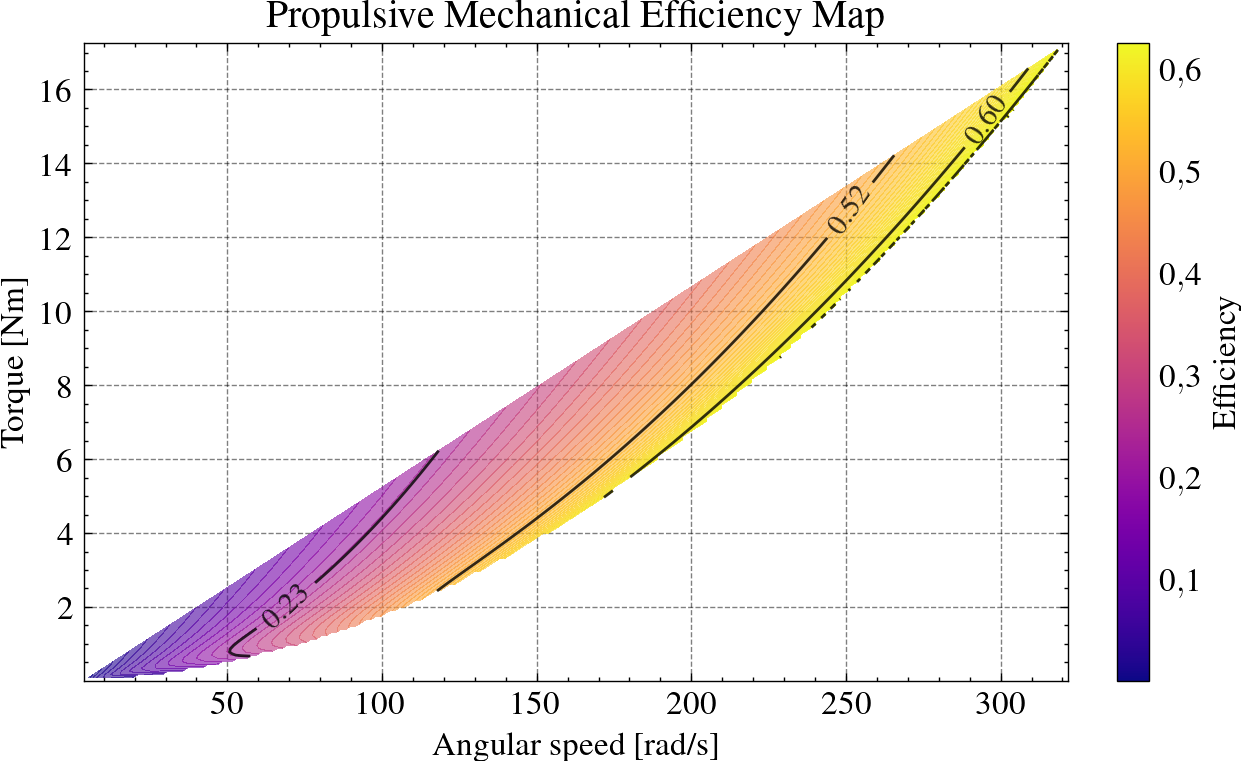

In [28]:
fig, ax, out = plot_efficiency_map_scattered(
    Y_ss,
    x='motor_w', y='motor_q_load', z='propulsive_mechanical_eta',
    nx=200, ny=200,
    mask_col='motor_p_out', mask_min=0,
    level_pmin=0, level_pmax=100, level_n=100,
    contour_lines=True,
    line_pmin=0, line_pmax=100, line_n=7,
    line_colors='k',
    label_lines=1,
    title='Propulsive Mechanical Efficiency Map',
    xlabel='Angular speed [rad/s]',
    ylabel='Torque [Nm]',
    cbar_label='Efficiency',
    cmap='plasma',
    fill_alpha=0.6,
)
plt.show()

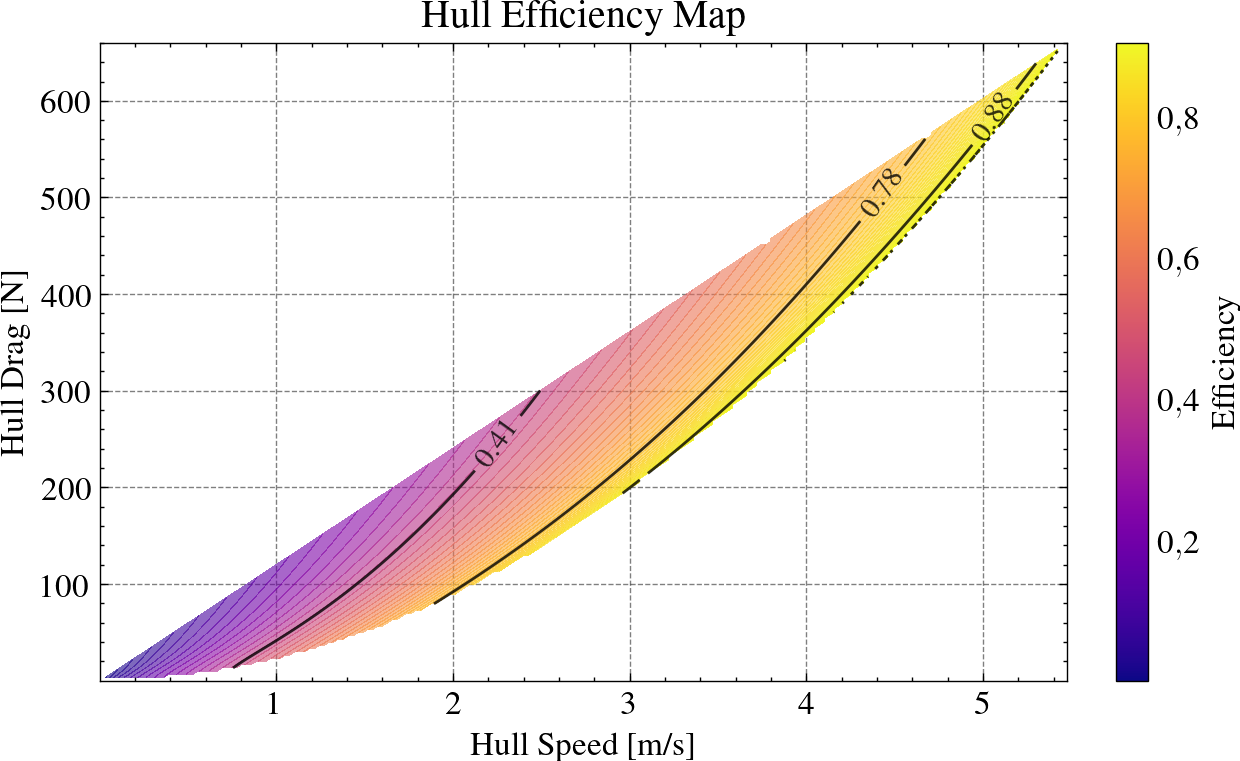

In [29]:
fig, ax, out = plot_efficiency_map_scattered(
    Y_ss,
    x='hull_u', y='hull_r_t', z='hull_eta',
    nx=200, ny=200,
    mask_col='motor_p_out', mask_min=0,
    level_pmin=0, level_pmax=100, level_n=100,
    contour_lines=True,
    line_pmin=0, line_pmax=100, line_n=7,
    line_colors='k',
    label_lines=1,
    title='Hull Efficiency Map',
    xlabel='Hull Speed [m/s]',
    ylabel='Hull Drag [N]',
    cbar_label='Efficiency',
    cmap='plasma',
    fill_alpha=0.6,
)
plt.show()

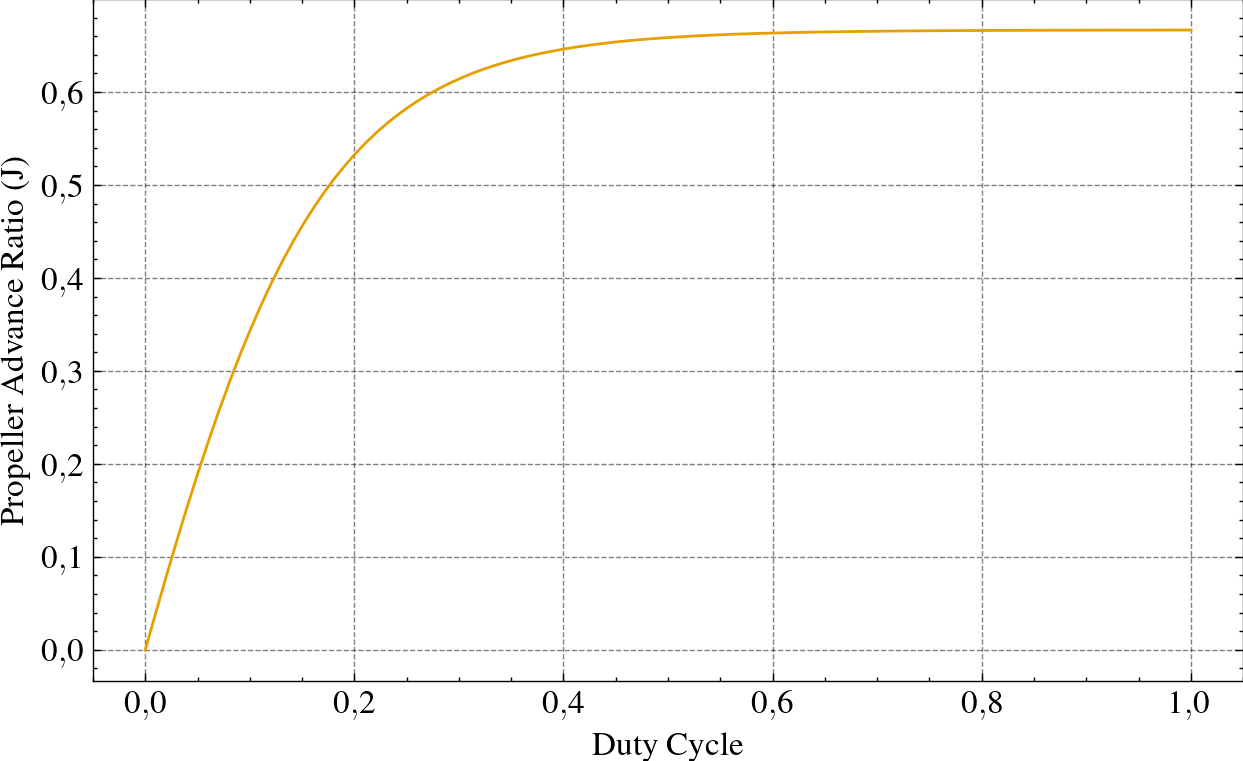

In [30]:
plt.plot(Y_ss2['esc_d'], Y_ss2['prop_j'])
plt.xlabel('Duty Cycle')
plt.ylabel('Propeller Advance Ratio (J)')
plt.show();

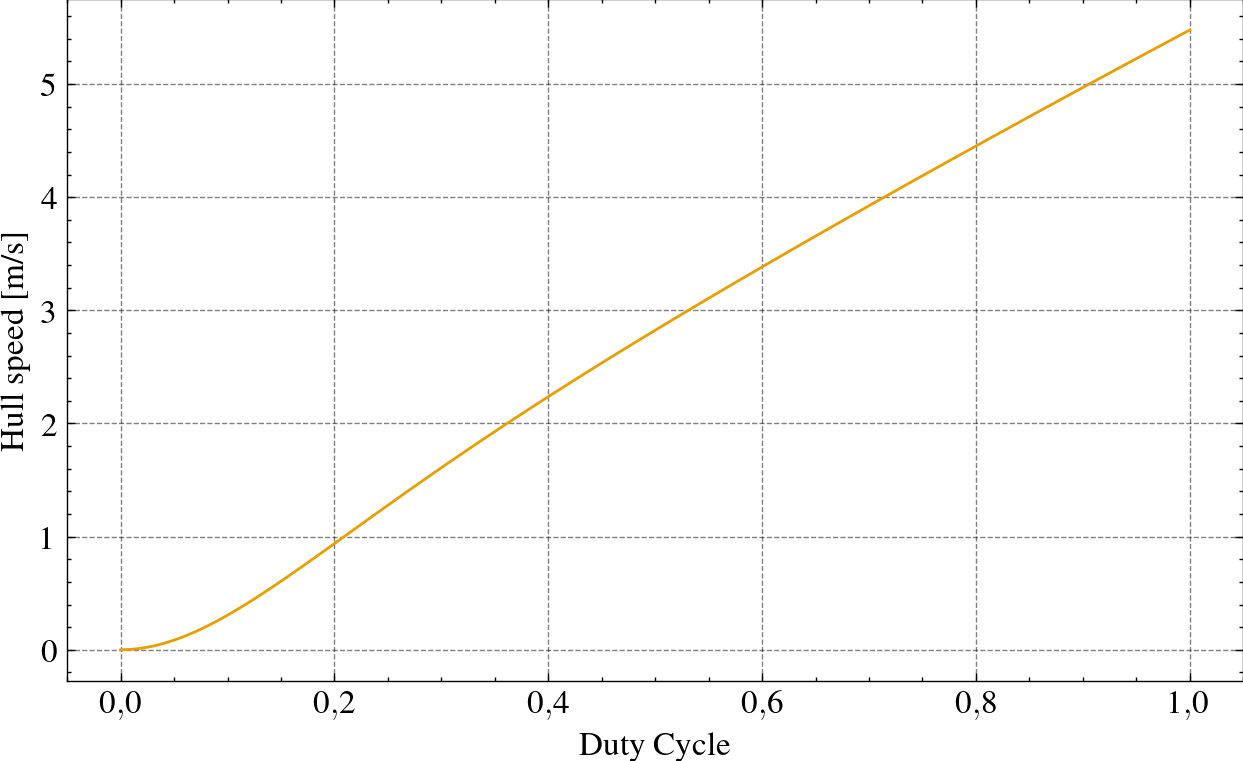

In [31]:
plt.plot(Y_ss2['esc_d'], Y_ss2['hull_u'])
plt.xlabel('Duty Cycle')
plt.ylabel('Hull speed [m/s]')
plt.show();

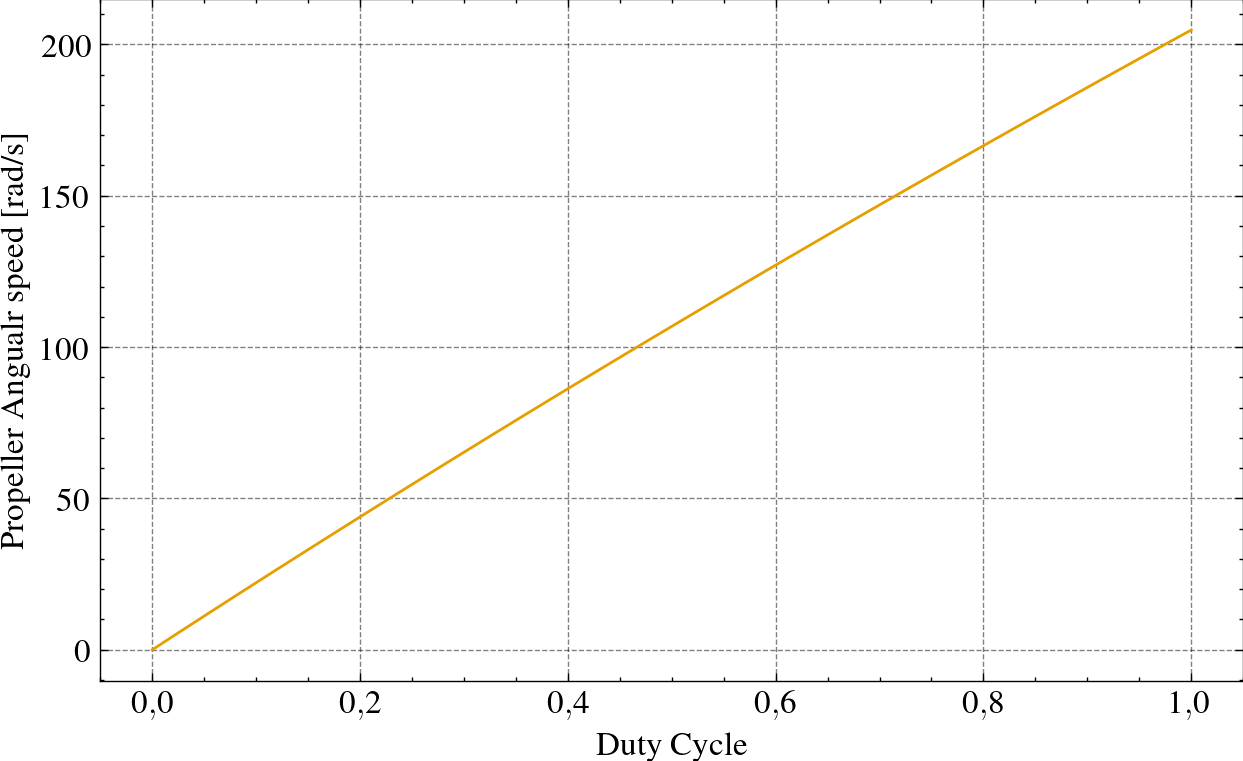

In [32]:
plt.plot(Y_ss2['esc_d'], Y_ss2['prop_w'])
plt.xlabel('Duty Cycle')
plt.ylabel('Propeller Angualr speed [rad/s]')
plt.show();

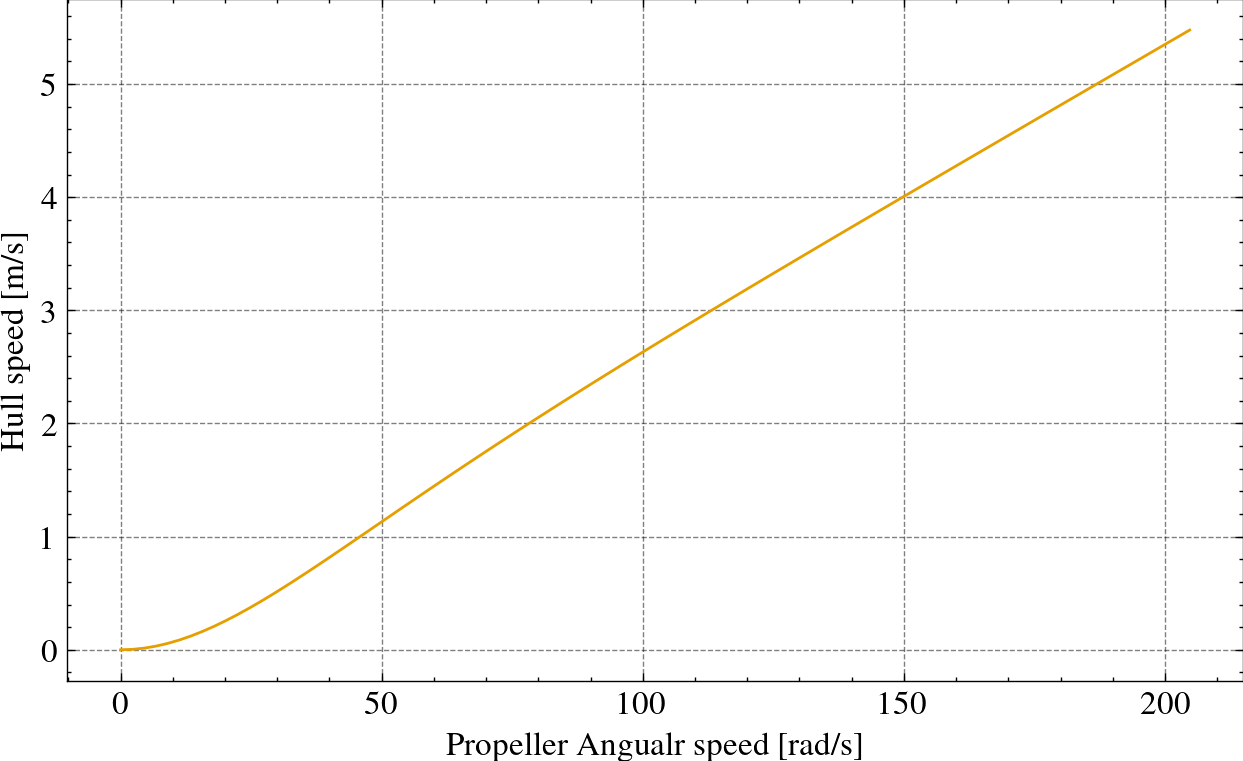

In [33]:
plt.plot(Y_ss2['prop_w'], Y_ss2['hull_u'])
plt.ylabel('Hull speed [m/s]')
plt.xlabel('Propeller Angualr speed [rad/s]')
plt.show();

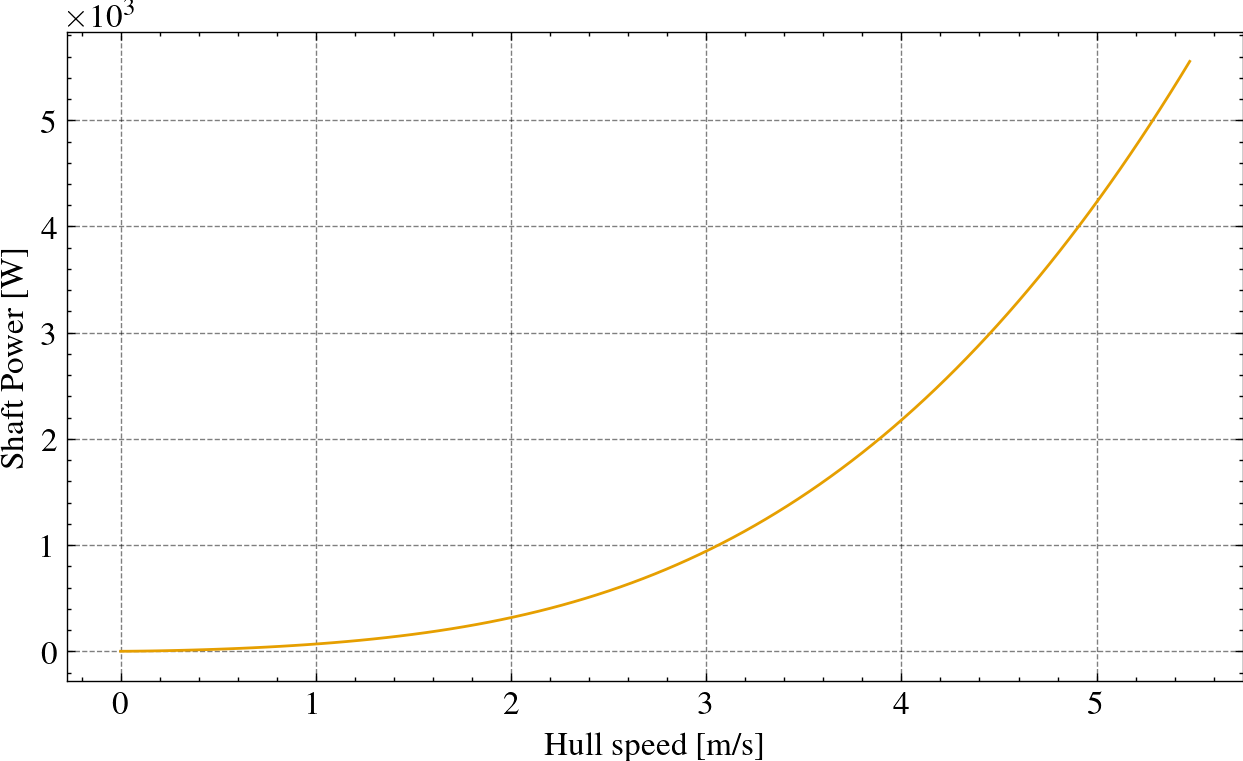

In [34]:
plt.plot(Y_ss2['hull_u'], Y_ss2['motor_p_out'])
plt.xlabel('Hull speed [m/s]')
plt.ylabel('Shaft Power [W]')
plt.show();